In [210]:
# The files "CNV1.gz" in each directory have already had the bad bins removed, and some bad cells as well

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob,re,time,os
from multiprocessing import Pool
import seaborn as sns
from IPython.display import clear_output
from datetime import date

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family' : 'normal',
        'font.weight' : 'normal',
        'font.size'   : 14})
today = date.today()

from matplotlib_venn import venn2
from tqdm import tqdm

In [212]:
# # Segregate duplicate RS2 samples
# rs2 = glob.glob('ginkgo_1000kb/CEMBA_RS2*')
# rs2 = pd.DataFrame(data=rs2,columns=['dir'])
# rs2['code'] = rs2['dir'].str.extract(r'CEMBA_RS2_(.*_rep[12]|[^_]+)')
# rs2['fname_length'] = rs2['dir'].str.len()
# rs2 = rs2.sort_values('fname_length')
# dups = rs2[rs2['code'].duplicated(keep='last')].sort_values('code')

# for f in dups['dir']:
#     x=f.replace('ginkgo_1000kb/','')
#     !mv -nv {f} ginkgo_1000kb/Duplicated/{x}
#     !mv -nv ginkgo_data2/{x} ginkgo_data2/Duplicated/{x}

In [213]:
# Load chromosome sizes
mm10 = pd.read_csv('/cndd/projects/genomes/mm10/mm10.genome',sep='\t').rename(columns={'chrom':'chr'}).set_index('chr')
all_samples=pd.read_csv('/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/all_samples.filtered.tsv',sep='\t')
all_samples=all_samples.rename(columns={'Unnamed: 0':'sample'})

In [6]:
%%time
# Metadata from Liu et al. paper
hanqing_clusters = pd.read_excel('LiuEtAl_2020_SuppTable5.xlsx')

CPU times: user 29.7 s, sys: 121 ms, total: 29.8 s
Wall time: 30 s


In [214]:
# Load cell clusters. 
ens='Ens266' # Fangming's "automated" clustering
cluster_fn = f'/cndd/projects/Public_Datasets/CEMBA/snmCSeq/Ensembles/{ens}/cluster/cluster_lv_npc50_k5_binc_mCH_100000_nmcc_{ens}.tsv'
cell_clusters = pd.read_csv(cluster_fn,sep='\t')

my_tsne = pd.read_csv(f'/cndd/projects/Public_Datasets/CEMBA/snmCSeq/Ensembles/{ens}/tsne/tsne_ndim2_perp40_npc50_binc_mCHmCG_100000_nmcc_{ens}.tsv',
                      sep='\t')
cell_clusters=cell_clusters.merge(my_tsne,on='sample')

In [215]:
# Convert the cell name to Hanqing's cellID
cells2cellID = pd.read_csv('/cndd2/Public_Datasets/CEMBA_cndd2/snmCSeq/Datasets/CURRENT_CELL_192115_2020-03-30.tsv.gz',sep='\t')
cells2cellID['sample'] = [i.split('/')[-1].replace('.tsv.gz','').replace('allc_','') for i in cells2cellID['AllcPath']]

In [216]:
cells2cellID = cells2cellID[['cell','sample']]

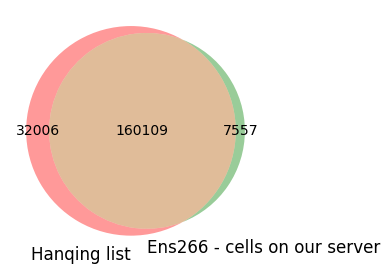

In [217]:
# Hanqing's inventory is missing some samples from 2018 and also the SCI_2017 samples (7557 cells)
# Our inventory (Ens266) is missing ~32k cells, presumably low quality that were not uploaded to NeMO
# In total there are 187k cells (allc tables) on our server
venn2((set(cells2cellID['sample']), set(cell_clusters['sample'])), set_labels=['Hanqing list','Ens266 - cells on our server'])

In [218]:
ncells=pd.read_csv('/cndd2/Public_Datasets/CEMBA_cndd2/snmCSeq/Datasets/ncells.csv',header=None,names=['sample','ncells'])
ncells.ncells.sum(), cells2cellID.shape[0], cell_clusters.shape[0]

(187483, 192115, 167666)

In [219]:
cell_clusters = cell_clusters.merge(cells2cellID, on='sample',how='left')

In [220]:
cell_clusters = cell_clusters.merge(hanqing_clusters,left_on='cell',right_on='CellID',how='left')

In [221]:
cell_clusters['CellID'].isna().value_counts()

False    101879
True      65787
Name: CellID, dtype: int64

In [222]:
# Load Ginkgo results for a set of cells
datadir='/cndd2/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/CEMBA_*/status.xml'
ginkgo_list = glob.glob(datadir)
ginkgo_list = [i.split('/')[-2] for i in ginkgo_list]
ginkgo_list = np.sort(ginkgo_list)
print(f'Found {len(ginkgo_list)} ginkgo processed datasets')

Found 327 ginkgo processed datasets


In [223]:
# Give every cell a standardized name
def samples2cells(samples):
    # Convert sample names (e.g. 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_....) to cell names
    # (e.g. CEMBA171206.3C.1.CEMBA171206.3C.3.A10_ad001)
    cells = samples.copy()
    cells = [re.sub(r'^X?[0-9]{6}_CEMBA_mm_P56_P63_',r'',i) for i in cells]
    cells = [re.sub(r'.indexed[.]?',r'',i) for i in cells]
    cells = [re.sub(r'[_-]',r'.',i) for i in cells]
    cells = [re.sub(r'\.(AD|ad)([0-9]+)$',r'_ad\2',i) for i in cells]
    return cells
cell_clusters['cell'] = samples2cells(cell_clusters['sample'])

In [224]:
# Add MAD (median absolute deviation) information for all cells
stats_dfs = []
for sample in tqdm(ginkgo_list):
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    stats = pd.read_csv('%s/SegStats.gz' % sampledir, sep='\t')
    mad = pd.read_csv('%s/SegMAD.gz'%sampledir,sep='\t',names=['cell','MAD'])
    stats['sample']=sample
    stats_dfs.append(mad.join(stats,on='cell',how='right').set_index('cell'))

stats = stats_dfs[0].append(stats_dfs[1:])
stats['cell'] = samples2cells(stats.index)
stats.index = stats.index.rename('cell_index')

100%|██████████| 327/327 [00:02<00:00, 116.15it/s]


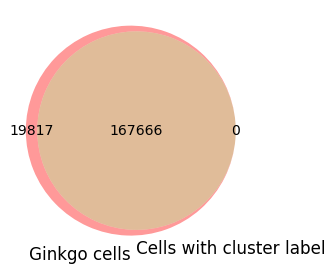

In [226]:
venn2((set(stats['cell']), set(cell_clusters.cell)), set_labels=['Ginkgo cells','Cells with cluster label'])

(0.0, 1.4)

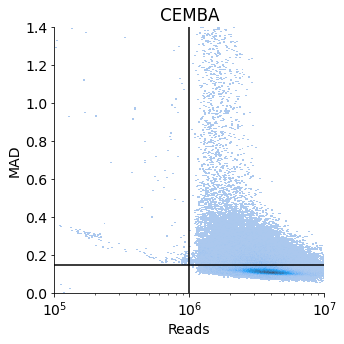

In [227]:
# MAD vs. number of reads
sns.displot(data=stats,x='Reads',y='MAD',kind='hist',log_scale=[True,False])
plt.vlines(1e6, *plt.ylim(),'k')
plt.hlines(.15, *plt.xlim(),'k')
# plt.xscale('log')
plt.title('CEMBA')
plt.xlim([1e5,1e7])
plt.ylim([0,1.4])

In [228]:
# Load list of good cells for each sample (from 03.badbins)
# 
def _goodcells(sample):
    df=pd.read_csv(f'ginkgo_1000kb/{sample}/SegCopy.global_goodbins.goodcells.tsv.gz',sep='\t',nrows=0,index_col=['CHR','START','END'])
    df = df.columns.to_frame().reset_index(drop=True).rename(columns={0:'cell'})
    df['sample'] = sample
    return df
    
with Pool() as p:
    all_goodcells = list(tqdm(p.imap(_goodcells,ginkgo_list),total=len(ginkgo_list)))

all_goodcells = pd.concat(all_goodcells,axis=0).reset_index(drop=True)
all_goodcells.to_csv('all_goodcells.tsv',sep='\t')

100%|██████████| 327/327 [00:05<00:00, 56.40it/s] 


In [229]:
tot_cells = all_goodcells.shape[0]
tot_cells

160332

In [230]:
all_goodcellsu = all_goodcells.drop(columns='sample').copy()
all_goodcellsu['PassQC'] = True
statsu = all_goodcellsu.set_index('cell').join(stats,how='right')
statsu['PassQC'].fillna(False,inplace=True)

(0.0, 1.4)

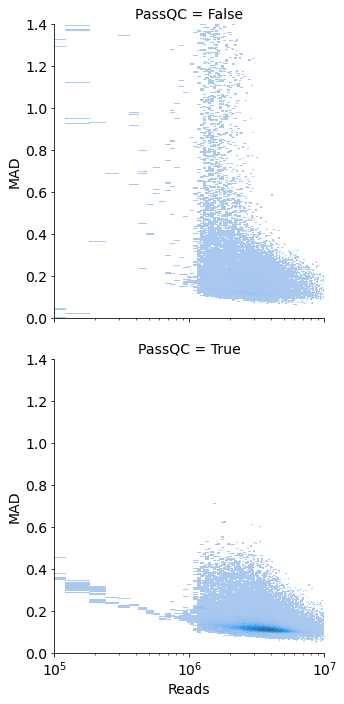

In [231]:
# MAD vs. number of reads
sns.displot(data=statsu,x='Reads',y='MAD',row='PassQC',kind='hist')
plt.xscale('log')
plt.xlim([1e5,1e7])
plt.ylim([0,1.4])

In [232]:
min_reads = 1e6
max_mad = 0.15
tot_cells = statsu[(statsu.MAD<max_mad) & (statsu.Reads>min_reads) & (statsu.PassQC)].shape[0]
tot_cells

139535

# Determine "blacklist" bins which have too many CNVs

In [ ]:
# See the notebook: 03.badbins....

QC criteria for cells:
- Fraction of genome with a CNV < 

QC criteria for bins:
- Fraction of cells with a CNV < 

In [21]:
def resample_bins(df,binsize,normalize=False):
    df = df.reset_index(drop=True)
    df['bin']=np.floor(df['bin']/binsize)*binsize
    if normalize:
        df=df.groupby(['chr','bin']).mean()
    else:
        df=df.groupby(['chr','bin']).sum()
    return df

def load_segcopy(sample,cells=None,binsize=1e6):
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_data2/%s' % sample
    t0=time.time()
    if cells is not None:
        usecols=['CHR','START','END']+list(cells)
    else:
        usecols=None
    segcopy = pd.read_csv(sampledir+'/SegCopy.gz', sep='\t',
                  usecols=usecols)
    segnorm = pd.read_csv(sampledir+'/SegNorm.gz', sep='\t',
                  usecols=usecols)
#     goodbins = (segcopy['END']-segcopy['START'] == 99999) & (segcopy['CHR']!='1')
#     segcopy = segcopy.loc[goodbins]
#     segnorm = segnorm.loc[goodbins]
#     return segcopy,segnorm

    # Keep only the bins with the normative binsize
    goodbins = (segcopy['END']-segcopy['START'] == 99999) & (segcopy['CHR']!='1')
    segcopy = segcopy.loc[goodbins]
    segcopy = segcopy.drop(columns='END')
    segcopy = segcopy.reset_index(drop=True).rename(columns={'START':'bin','CHR':'chr'})
    segcopy = resample_bins(segcopy,binsize=binsize,normalize=True)
    segcopy = pd.concat({sample: segcopy}, names=['Sample'],axis=1)
    
    goodbins = (segnorm['END']-segnorm['START'] == 99999) & (segnorm['CHR']!='1')
    segnorm = segnorm.loc[goodbins]
    segnorm = segnorm.drop(columns='END')
    segnorm = segnorm.reset_index(drop=True).rename(columns={'START':'bin','CHR':'chr'})
    segnorm = resample_bins(segnorm,binsize=binsize,normalize=True)
    segnorm = pd.concat({sample: segnorm}, names=['Sample'],axis=1)

    return segcopy,segnorm

def my_binc_mean(sample):
    # Get mean CPM per bin for a sample
    binc=pd.read_csv(f'ginkgo_1000kb/{sample}/binc_{sample}_1000kb.tsv.gz',sep='\t',index_col=['chr','bin_end'],
                     dtype=int,converters={0:str}
                    )
    binc_cpm = 1e6*binc.divide(binc.sum(axis=0),axis=1)
    binc_mean = binc_cpm.mean(axis=1)
    if re.match(r'.*_RS2_.*',sample) is None:
        sex='m'
        if 'X' in binc_mean.index:
            binc_mean[binc_mean.index.get_level_values(0)=='X']*=2
    else:
        sex=re.match(r'.*_RS2_[A-Z]([mf])[0-9].*',sample).group(1)
    binc_mean.name=sample
    return binc_mean

In [22]:
sample=ginkgo_list[10]
sample

'CEMBA_10G_190423'

In [23]:
%%time
x=my_binc_mean(sample)

/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column chr - only the converter will be used
  return func(*args, **kwargs)


ValueError: Index bin_end invalid

In [67]:
with Pool() as p:
    binc_mean = list(tqdm(p.imap(my_binc_mean, ginkgo_list[:20]),total=len(ginkgo_list)))   

  6%|▌         | 20/343 [03:07<50:27,  9.37s/it]  


In [ ]:
binc_mean_df = binc_mean[0].to_frame().join(binc_mean[1:],how='outer')

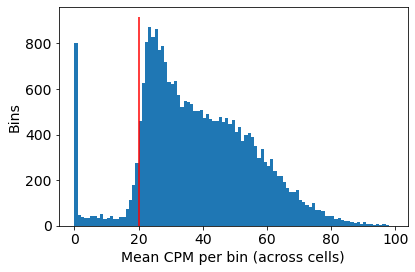

In [139]:
x.plot(kind='hist',bins=np.arange(0,100))
plt.xlabel('Mean CPM per bin (across cells)')
plt.ylabel('Bins')
plt.vlines(20,*plt.ylim(),'r')

In [37]:
binc_mean_df.mean(axis=1).plot(kind='hist',bins=np.arange(0,100))
# plt.loglog(0.1+binc_mean_df.mean(axis=1), .1+binc_mean_df.std(axis=1),'.')

NameError: name 'binc_mean_df' is not defined

In [82]:
badbins = binc_mean_df[binc_mean_df.mean(axis=1)<20].index.to_frame()
badbins['bin_end_end'] = badbins['bin_end']+100000
badbins.to_csv('badbins_meanCPM20.bed',sep='\t',header=None,index=False)

1	0	100000
1	100000	200000
1	200000	300000
1	300000	400000
1	400000	500000
1	500000	600000
1	600000	700000
1	700000	800000
1	800000	900000
1	900000	1000000


In [100]:
!cat badbins_meanCPM20.bed | awk '{OFS="\t"; print "chr"$1,$2,$3}'|bedtools sort -i -|bedtools merge -i - > badbins_meanCPM20_merge.bed

In [113]:
badbins=pd.read_csv('badbins_meanCPM20_merge.bed',sep='\t',names=['chr','start','end'])

In [102]:
xdf = x.reset_index()
xdf=xdf.rename(columns={'chr':'CHR','bin_end':'pos'})
chroms=list(np.arange(1,20))+['X']
chroms=np.array(chroms,dtype=str)

In [105]:
# Make a plot 
def zebra_stripes(xt,yt):
    # Show gray and white stripes for chromosomes
    plt.bar(xt[::2],yt[1],width=xt[1::2]-xt[::2],
            align='edge',
            color='gray',alpha=0.5)

def chromplot(df,y,x='pos',hue=None,ax=None,chroms=chroms,sample='',cell=''):
    # Plot the segnorm and segcopy information for a cell
    i=0
    xt=[]
    dfu=df.copy()
    dfu['chrom_pos'] = dfu[x]
    for chrom in chroms:
        df1=df[df['CHR']==chrom]
        dfu.loc[dfu['CHR']==chrom,'chrom_pos']+=i
        i=dfu.loc[dfu['CHR']==chrom,'chrom_pos'].max()
        xt.append(i)
    yt=[0,dfu[y].max()]
    zebra_stripes(np.array(xt),yt)
    sns.scatterplot(data=dfu,x='chrom_pos',y=y,hue=hue,
                    s=3,edgecolor=None
                   )
    plt.xlim([0,dfu['chrom_pos'].max()])
    

In [132]:
def mark_badbins(df,badbins=badbins):
    df_badbins = df[['CHR','pos']].copy()
    df_badbins['CHR']='chr'+df_badbins['CHR'].astype(str)
    df_badbins['badbins'] = False
    for i,b in badbins.iterrows():
        df_badbins['badbins'] += (df_badbins['CHR']==b['chr']) & (df_badbins['pos']>=b['start']) & (df_badbins['pos']<=b['end'])
    return df_badbins

In [135]:
xdf_badbins['badbins'].value_counts()

False    24724
True      1621
Name: badbins, dtype: int64

(0.0, 100.0)

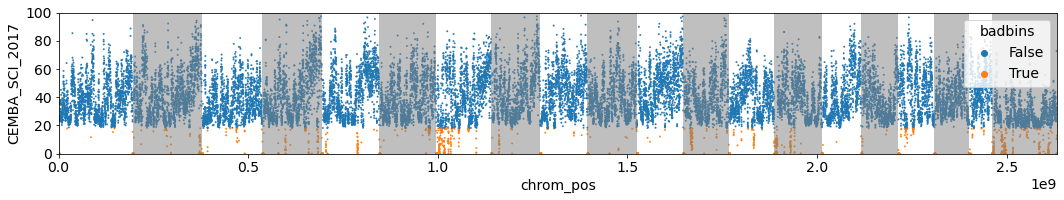

In [136]:
plt.figure(figsize=(15,3))
xdf_badbins = mark_badbins(xdf)

chromplot(xdf,y='CEMBA_SCI_2017',hue='badbins')
plt.ylim([0,100])

# Load CNVs

In [122]:
plotsdir='/cndd/emukamel/Aneuploidy/CEMBA/Plots/Plots_Aneuploid'
def load_cnv(sample,
             genome=mm10,
             sex=None,
             min_reads=1e6,
            ):
    # Load CNV1 file produced by Ginkgo.
    # NOTE: This file has already been filtered for bad bins
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    fn_cnv = '%s/CNV1.gz' % sampledir
    cnv1 = pd.read_csv(fn_cnv, sep='\t', header=None,names=['chr','start','end','cell','num'],
                      dtype={'chr':str,'start':int,'end':int,'cell':str,'num':int})
    ncells = cnv1['cell'].nunique()
    cnv1['length'] = cnv1.end-cnv1.start

    stats = pd.read_csv('%s/SegStats.gz' % sampledir, sep='\t')
    mad = pd.read_csv('%s/SegMAD.gz'%sampledir,sep='\t',names=['cell','MAD'])
    stats = mad.join(stats,on='cell',how='right').set_index('cell')

    if sex is None:
        if re.match(r'.*_RS2_.*',sample) is None:
            sex='m'
        else:
            sex=re.match(r'.*_RS2_[A-Z]([mf])[0-9].*',sample).group(1)

    # Remove the monoploidy on chrX and chrY
    if sex in ['m','male']:
        cnv1 = cnv1.loc[~((cnv1['chr']=='chrX') & (cnv1['num']==1)) & (cnv1['chr']!='chrY'), :]
    elif sex in ['f','female']:
        cnv1 = cnv1.loc[~((cnv1['chr']=='chrX') & (cnv1['num']==2)) & (cnv1['chr']!='chrY'), :]
    else:
        raise NameError('Sex must be m or f')

    # Remove chr='1'
    cnv1 = cnv1.loc[cnv1['chr']!='1']
    cnv1=cnv1.set_index('cell')
    cnv1 = cnv1[stats['Reads']>min_reads]
    
    return cnv1

In [123]:
sample=ginkgo_list[1]
cnv1=load_cnv(sample)

/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [391]:
# def remove_badbins(cnv1, badbins):
#     cnv_out = cnv1.copy()
#     for i,b in badbins.iterrows():
#         cnv_out = cnv_out[~((cnv_out['chr']==b['chr']) & (cnv_out['start']>=b['start']) & (cnv_out['end']<=b['end']))]
#     return cnv_out

# Characterize the number of CNVs as a function of criteria

In [153]:
%%time
import warnings
warnings.filterwarnings('ignore')

# Load CNVs for all cells
cells_df=pd.DataFrame(columns=['sample','cell','aneuploid','CNV_total_length','CNV_max_length'])
df_list = []
ncells_df = pd.DataFrame(columns=['ncells','naneuploid'])
t0=time.time()

def my_load_cnv(sample):
    try:
        c = load_cnv(sample)
        c['sample'] = sample
    except:
        print('*** Error on %s' % sample)
        c=pd.DataFrame()
    return c

t0=time.time()
with Pool() as p:
    dfs = list(tqdm(p.imap(my_load_cnv, ginkgo_list),total=len(ginkgo_list)))

In [ ]:
cells_df = dfs[0].append(dfs[1:]).reset_index() # Merge all the dataframes
print('*** Found %d aneuploid chromosomes in %d cells ' % (cells_df.shape[0], cells_df['cell'].nunique()))

cells_df = cells_df.merge(cell_clusters[['cluster_ID','cell','MajorRegion','SubRegion','DissectionRegion']],right_on='cell',left_on='cell',how='left')

# Add region information
cells_df['region code'] = [i.replace('CEMBA_','').replace('RS2_','').split('_')[0] for i in cells_df['sample']]
aba_regions=pd.read_csv('CEMBA RS1 LIMS - ABA regions.csv', usecols=range(5))
cells_df = cells_df.merge(aba_regions, left_on=['region code'],right_on=['Code'], how='left').drop(columns='Code')

In [227]:
cells_dfu = remove_badbins(cells_df,badbins)

index   chr      start        end  \
42          42  chr1    3000001    3200000   
43          43  chr1    3000001    3500000   
44          44  chr1    3000001    3500000   
45          45  chr1    3000001    3500000   
46          46  chr1    3000001    3600000   
...        ...   ...        ...        ...   
362883  134103  chrX  169300001  170100000   
362884  134127  chrX  156400001  170100000   
362885  134135  chrX  169500001  170100000   
362891  134166  chrX  139800001  170900000   
362893  134169  chrX   98200001  170900000   

                                                 cell  num    length  \
42      CEMBA190423.10A.1.CEMBA190423.10A.2.F11_ad006    1    199999   
43       CEMBA190423.10A.3.CEMBA190423.10A.4.F1_ad008    1    499999   
44      CEMBA190423.10A.3.CEMBA190423.10A.4.F12_ad007    1    499999   
45       CEMBA190423.10A.1.CEMBA190423.10A.2.H3_ad004    1    499999   
46       CEMBA190423.10A.1.CEMBA190423.10A.2.B2_ad004    1    599999   
...                                               ...  ...       ...   
362883  CEMBA190725.10B.1.CEMBA190725.10B.2.B12_ad004    0    799999   
362884  CEMBA190725.10B.1.CEMBA190725.10B.2.G11_ad002    0  13699999   
362885   CEMBA190725.10B.3.CEMBA190725.10B.4.G9_ad012    0    599999   
362891  CEMBA190725.10B.3.CEMBA190725.10B.4.H10_ad004    0  31099999   
362893   CEMBA190725.10B.3.CEMBA190725.10B.4.F4_ad010    0  72699999   

                  sample  cluster_ID MajorRegion SubRegion DissectionRegion  \
42      CEMBA_10A_190423  cluster_26         NaN       NaN              NaN   
43      CEMBA_10A_190423  cluster_26         NaN       NaN              NaN   
44      CEMBA_10A_190423  cluster_18         NaN       NaN              NaN   
45      CEMBA_10A_190423  cluster_37         NaN       NaN              NaN   
46      CEMBA_10A_190423  cluster_47         NaN       NaN              NaN   
...                  ...         ...         ...       ...              ...   
362883  CEMBA_10B_190725  cluster_18         NaN       NaN              NaN   
362884  CEMBA_10B_190725  cluster_20         NaN       NaN              NaN   
362885  CEMBA_10B_190725  cluster_31         NaN       NaN              NaN   
362891  CEMBA_10B_190725  cluster_66         NaN       NaN              NaN   
362893  CEMBA_10B_190725  cluster_66         NaN       NaN              NaN   

       region code ABA name (based on posterior face of the slice)  \
42             10A                                             RSP   
43             10A                                             RSP   
44             10A                                             RSP   
45             10A                                             RSP   
46             10A                                             RSP   
...            ...                                             ...   
362883         10B                  (VISam+VISpm+VISp+VISrl+VISal)   
362884         10B                  (VISam+VISpm+VISp+VISrl+VISal)   
362885         10B                  (VISam+VISpm+VISp+VISrl+VISal)   
362891         10B                  (VISam+VISpm+VISp+VISrl+VISal)   
362893         10B                  (VISam+VISpm+VISp+VISrl+VISal)   

       ABA name (all regions included in this dissection) Broad region  \
42                                      Retrospenial area    Isocortex   
43                                      Retrospenial area    Isocortex   
44                                      Retrospenial area    Isocortex   
45                                      Retrospenial area    Isocortex   
46                                      Retrospenial area    Isocortex   
...                                                   ...          ...   
362883  Anteromedial visual area+Posteromedial visual ...    Isocortex   
362884  Anteromedial visual area+Posteromedial visual ...    Isocortex   
362885  Anteromedial visual area+Posteromedial visual ...    Isocortex   
362891  Anteromedial visual area+Posteromedial visual ...    

# Load CNVs per chromosome from all samples

In [244]:
def load_cnv_per_chrom(sample,
             genome=mm10,
             sex=None,
             min_cnv_length=0, 
             max_cnvl_per_cell=2e9,
             min_frac_aneuploid=0,
             min_reads=1e6,
             max_mad = 0.2,
             max_aneuploid_chroms=5,
             max_nonaneuploid_cnvl=1e9,
                       badbins=None,
            ):
    # Load CNV1 file produced by Ginkgo.
    # Find the cells with potential aneuploidies and create a directory of
    # symlinks to their plots
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    fn_cnv = '%s/CNV1.gz' % sampledir
    cnv1 = pd.read_csv(fn_cnv, sep='\t', header=None,names=['chr','start','end','cell','num'],
                      dtype={'chr':str,'start':int,'end':int,'cell':str,'num':int})
    ncells = cnv1['cell'].nunique()
    cnv1['length'] = cnv1.end-cnv1.start

    stats = pd.read_csv('%s/SegStats.gz' % sampledir, sep='\t')
    mad = pd.read_csv('%s/SegMAD.gz'%sampledir,sep='\t',names=['cell','MAD'])
    stats = mad.join(stats,on='cell',how='right').set_index('cell')

    if sex is None:
        if re.match(r'.*_RS2_.*',sample) is None:
            sex='m'
        else:
            sex=re.match(r'.*_RS2_[A-Z]([mf])[0-9].*',sample).group(1)
#             print('Detected sex=%s' % sex)

    # Remove the monoploidy on chrX and chrY
    if sex in ['m','male']:
        cnv1 = cnv1.loc[~((cnv1['chr']=='chrX') & (cnv1['num']==1)) & (cnv1['chr']!='chrY'), :]
    elif sex in ['f','female']:
        cnv1 = cnv1.loc[~((cnv1['chr']=='chrX') & (cnv1['num']==2)) & (cnv1['chr']!='chrY'), :]
    else:
        raise NameError('Sex must be m or f')

    # Remove chr='1'
    cnv1 = cnv1.loc[cnv1['chr']!='1']
    
    # Keep only "large" CNVs. Not really using this anymore
    cnv1 = cnv1.loc[cnv1['length']>=min_cnv_length]

    # Remove badbins
    if badbins is not None:
        cnv1=remove_badbins(cnv1,badbins)
        
    # CNV per chromosome
    cnv1 = cnv1.rename(columns={'num':'ploidy'})
    cnv_per_chrom = cnv1.groupby(['cell','chr','ploidy'])[['length']].sum()
    cnv_per_chrom['FracAneuploid'] = cnv_per_chrom['length']/genome['size']
    cnv_per_chrom = cnv_per_chrom.join(stats,on='cell')
    
    # Select just the aneuploid, high-quality cells and chromosomes
    cnv_per_chrom = cnv_per_chrom[cnv_per_chrom['Reads']>=min_reads]
    cnv_per_chrom = cnv_per_chrom[cnv_per_chrom['MAD']<=max_mad]
    cnv_per_chrom = cnv_per_chrom[cnv_per_chrom['FracAneuploid']>=min_frac_aneuploid]
    
    # If the genome appears to be globally aneuploid, normalize
    cnvl_per_cell = (cnv_per_chrom.groupby('cell')['length'].sum()) # Total amount of aneuploidy
    naneuploid_chroms_per_cell = cnv_per_chrom.groupby('cell')['Reads'].count()
    goodcells = cnvl_per_cell[(cnvl_per_cell<=max_cnvl_per_cell) & (naneuploid_chroms_per_cell<=max_aneuploid_chroms)].index
    cnv_per_chrom = cnv_per_chrom.loc[goodcells]
    cnv_per_chrom['sample'] = sample
    cnv_per_chrom['sex'] = sex

    cnv_per_chrom['NonAneuploid_CNV_length'] = cnv1.groupby('cell')['length'].sum()-cnv_per_chrom['length']
    good_cnvs = cnv_per_chrom['NonAneuploid_CNV_length']<max_nonaneuploid_cnvl
    cnv_per_chrom = cnv_per_chrom.loc[good_cnvs]
   
    return cnv_per_chrom

In [245]:
%%time
# Load CNVs for all cells
cnvs_df=pd.DataFrame(columns=['sample','cell','aneuploid','CNV_total_length','CNV_max_length'])
df_list = []
ncnvs_df = pd.DataFrame(columns=['ncells','naneuploid'])

min_frac_aneuploid=0
max_mad = 0.15
min_cnv_length=1e6
def my_load_cnv(sample):
    try:
        c = load_cnv_per_chrom(sample,
                     min_frac_aneuploid=min_frac_aneuploid,
                     max_aneuploid_chroms=100,
                     max_nonaneuploid_cnvl=np.inf,
                     max_cnvl_per_cell=np.inf,
                               min_cnv_length=min_cnv_length,
                     max_mad = max_mad,
                    )
    except:
        print('*** Error on %s' % sample)
        c=pd.DataFrame()
    return c

t0=time.time()
with Pool(6) as p:
    dfs = list(tqdm(p.imap(my_load_cnv, ginkgo_list), total=len(ginkgo_list)))
    
cnvs_df = dfs[0].append(dfs[1:]).reset_index() # Merge all the dataframes
print('*** Found %d aneuploid chromosomes in %d cells ' % (cnvs_df.shape[0], cnvs_df['cell'].nunique()))

100%|██████████| 327/327 [00:01<00:00, 178.78it/s]


*** Found 351556 aneuploid chromosomes in 90938 cells 
CPU times: user 971 ms, sys: 355 ms, total: 1.33 s
Wall time: 2.58 s


In [294]:
# Add region information
def add_regions(df,sample_column='sample'):
    # Add region code
    df['region code'] = [i.replace('CEMBA_','').replace('RS2_','').split('_')[0] for i in df[sample_column]]
    df['source region code'] = df['region code'].replace(r'^[A-Z][mf]','',regex=True)
    aba_regions=pd.read_csv('CEMBA RS1 LIMS - ABA regions.csv', usecols=range(5))
    aba_regions=aba_regions.append({'Code':'SCI',
                                'ABA name (based on posterior face of the slice)':'Frontal',
                                    'ABA name (all regions included in this dissection)':'Frontal',
                                'Broad region':'Frontal','Broad region description':'Frontal'
                               },ignore_index=True)
    aba_regions['region name'] = aba_regions['ABA name (based on posterior face of the slice)']+' '+aba_regions['Code']

    df = df.merge(aba_regions, left_on=['source region code'],right_on=['Code'], how='left').drop(columns='Code')
#     df['region name'] = df['ABA name (based on posterior face of the slice)']+' '+df['source region code']
    
    # Handle RS2 region names that come from combinations of regions
    def split_regions(allcodes):
        codes=re.split(r'([0-9]+[A-Z])',allcodes)[1::2]

        region_names=aba_regions.loc[codes,'ABA name (based on posterior face of the slice)'].unique()
        if len(codes)>1:
            region_names=[re.sub(r' \([A-Za-z\+]+\)','',x) for x in region_names]
            region_names=np.unique(region_names)
        region_names=';'.join(region_names)
        region_names += ' '+allcodes

        return region_names

    df['region name2']=df['region name']
    df.loc[df['region name'].isna(),'region name2'] = [split_regions(i) for i in df.loc[cnvs_df['region name'].isna(),'source region code']]
    df.loc[cnvs_df['source region code']=='SCI','region name2']='Frontal SCI'
    df['region name'] = df['region name2']
    df = df.drop(columns='region name2')
    
    return df

In [247]:
cnvs_df = add_regions(cnvs_df)

aba_regions=pd.read_csv('CEMBA RS1 LIMS - ABA regions.csv', usecols=range(5))
aba_regions=aba_regions.append({'Code':'SCI',
                            'ABA name (based on posterior face of the slice)':'Frontal',
                                'ABA name (all regions included in this dissection)':'Frontal',
                            'Broad region':'Frontal','Broad region description':'Frontal'
                           },ignore_index=True)
aba_regions=aba_regions.set_index('Code')
aba_regions['region name'] = aba_regions['ABA name (based on posterior face of the slice)']+' '+aba_regions.index
aba_regions

# Handle RS2 region names that come from combinations of regions
def split_regions(allcodes):
    codes=re.split(r'([0-9]+[A-Z])',allcodes)[1::2]
        
    region_names=aba_regions.loc[codes,'ABA name (based on posterior face of the slice)'].unique()
    if len(codes)>1:
        region_names=[re.sub(r' \([A-Za-z\+]+\)','',x) for x in region_names]
        region_names=np.unique(region_names)
    region_names=';'.join(region_names)
    region_names += ' '+allcodes
    
    return region_names

cnvs_df['region name2']=cnvs_df['region name']
cnvs_df.loc[cnvs_df['region name'].isna(),'region name2'] = [split_regions(i) for i in cnvs_df.loc[cnvs_df['region name'].isna(),'source region code']]
cnvs_df.loc[cnvs_df['source region code']=='SCI','region name2']='Frontal SCI'
cnvs_df['region name'] = cnvs_df['region name2']
cnvs_df = cnvs_df.drop(columns='region name2')
# cnvs_df['region name'] = cnvs_df['source region code'].map(split_regions)

In [250]:
# *** Found 458492 aneuploid chromosomes in 108088 cells 
# CPU times: user 1.65 s, sys: 239 ms, total: 1.89 s
# Wall time: 3.63 s

# *** Found 88998 aneuploid chromosomes in 3756 cells 
# CPU times: user 207 ms, sys: 869 ms, total: 1.08 s
# Wall time: 2.51 s

In [251]:
# cnvs_length_per_chrom = cnvs_df.groupby(['sample','cell','chr','ploidy'])['length'].sum().groupby(['sample','cell']).max()
# cnvs_length_per_chrom

In [252]:
cells_df=cnvs_df.groupby(['sample','cell']).agg({'length':'sum','chr':'nunique','Reads':'mean','Mean':'mean','Std':'mean','MAD':'mean'})
cells_df=cells_df.rename(columns={'length':'CNV total length per cell','chr':'Num. CNV chromosomes'})
# cells_df['max_CNV_frac_per_chrom'] = cnvs_df.groupby(['sample','cell','chr','ploidy'])['length'].sum().groupby(['sample','cell']).max()

cnvs_frac_per_chrom = cnvs_df.groupby(['sample','cell','chr','ploidy'])[['length']].sum().div(mm10['size'],axis=0,level='chr')
cnvs_maxfrac_per_chrom = cnvs_frac_per_chrom.groupby(['sample','cell']).max()
cells_df['max_CNV_frac_per_chrom'] = cnvs_maxfrac_per_chrom

# Add region information to cells_df
cells_df=cells_df.reset_index()
cells_df=add_regions(cells_df)
cells_df=cells_df.set_index('cell')

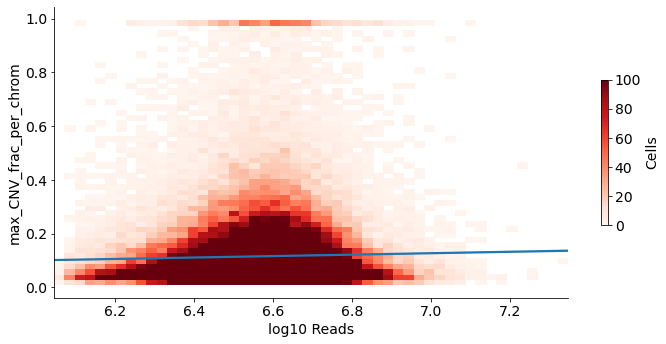

In [253]:
cells_df['log10 Reads'] = np.log10(cells_df['Reads']+1)
ax=sns.displot(data=cells_df,x='log10 Reads',y='max_CNV_frac_per_chrom',
#                 edgecolor=None,s=3,
               kind='hist',bins=50,
               cbar=True,
               vmin=0,vmax=100,
               aspect=2,
               cmap='Reds',
               cbar_kws={'shrink':0.5,'label':'Cells'}
               )
sns.regplot(data=cells_df,x='log10 Reads',y='max_CNV_frac_per_chrom',
            scatter=False)
plt.savefig('Plots/CEMBA_logReads_vs_maxCNVfrac_hist2.pdf')

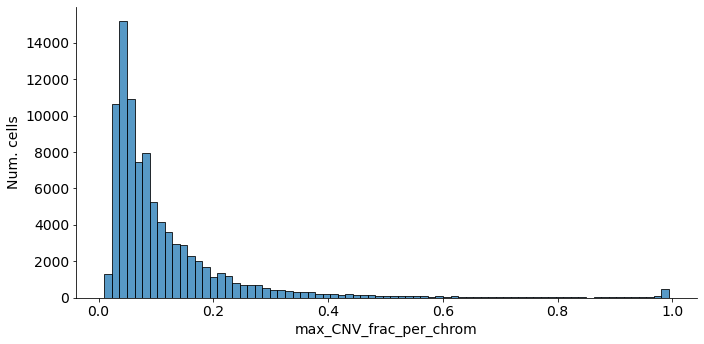

In [254]:
ax=sns.displot(data=cells_df,x='max_CNV_frac_per_chrom',
#                 edgecolor=None,s=3,
               bins=75,
               aspect=2,
               kind='hist',
               )
plt.ylabel('Num. cells')
# plt.savefig('Plots/CEMBA_maxCNVfrac_hist.pdf')

# Focused analysis of aneuploidies

In [269]:
min_frac_aneuploid=0.9
aneu_cells = cells_df[cells_df['max_CNV_frac_per_chrom']>min_frac_aneuploid].index.get_level_values('cell')
cells_df['Aneuploid'] = cells_df['max_CNV_frac_per_chrom']>0.9
print(f'Found {len(aneu_cells.unique())} cells with >{min_frac_aneuploid} covered by a CNV')

Found 634 cells with >0.9 covered by a CNV


In [270]:
allcells_df = cell_clusters.set_index('cell').join(stats.set_index('cell'),how='outer',rsuffix='_stats').rename(columns={'sample':'cell_id1'})
df1=all_goodcells.copy().set_index('cell')
df1.index = samples2cells(df1.index)
allcells_df=allcells_df.join(df1,how='inner')

assert (allcells_df['sample_stats']==allcells_df['sample']).all()
allcells_df=allcells_df.drop(columns='sample_stats')

In [271]:
aneu_cells_df = cnvs_df[cnvs_df['cell'].isin(aneu_cells)]
cnvs_df['Aneuploid cell'] = cnvs_df['cell'].isin(aneu_cells)

Text(0.5, 1.0, 'Showing 351556/2790700 chroms with a CNV\n(i.e. 87.403% of chroms have no CNV)')

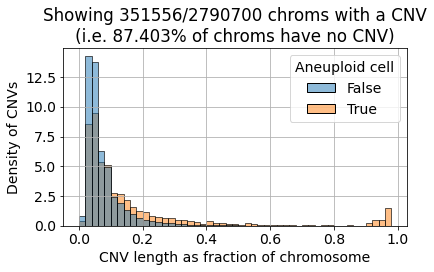

In [272]:
# For the aneu cells, characterize the # of aneu chroms etc.
# aneu_cells_df['FracAneuploid'].plot(kind='hist',bins=100)
sns.histplot(data=cnvs_df,
            x='FracAneuploid',
            common_norm=False,
            stat='density',
#             kde=True,kde_kws={'cut':0},
#             element='poly',
            hue='Aneuploid cell',
            bins=np.arange(0,1,0.02)
           )
plt.xlabel('CNV length as fraction of chromosome')
plt.ylabel('Density of CNVs')
plt.grid()
cnv_frac = cnvs_df.shape[0]/(tot_cells*20)
plt.title(f'Showing {cnvs_df.shape[0]}/{tot_cells*20} chroms with a CNV\n(i.e. {(1-cnv_frac)*100:.3f}% of chroms have no CNV)')
# plt.savefig('Plots/CEMBA_FracAneuploid_hist.pdf')

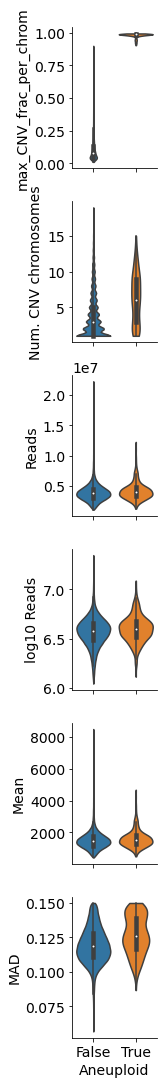

In [273]:
g = sns.PairGrid(data=cells_df,x_vars=['Aneuploid'],
                 y_vars=['max_CNV_frac_per_chrom','Num. CNV chromosomes','Reads','log10 Reads','Mean','MAD'])
g.map(sns.violinplot, cut=0)

In [185]:
# # Gather symlinks to the aneuploid cells
# # aneu_cells = cells_df[cells_df['Aneuploid']].index.get_level_values('cell').unique()
# !mkdir -p Plots/aneu_cells_1000kb
# for sample,cell in tqdm(cells_df[cells_df['Aneuploid']].index):
#     if not os.path.exists(f'Plots/aneu_cells_1000kb/{cell}_CN.jpeg'):
#         !ln -s /cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/{sample}/plots/{cell}_CN.jpeg Plots/aneu_cells_1000kb/

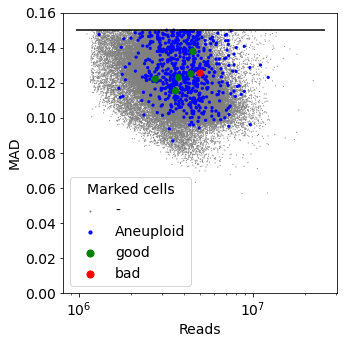

In [275]:
# Manually mark cells based on Ginkgo plots which look good or bad...
badcells = [
    'CEMBA190325.12B.3.CEMBA190325.12B.4.H3_ad010',
            'CEMBA191008.12A.1.CEMBA191008.12A.2.A8_ad010',
            'CEMBA190305.11F.3.CEMBA190305.11F.4.B7_ad012',
            'CEMBA190305.11F.3.CEMBA190305.11F.4.F4_ad007',
            'CEMBA190305.11F.3.CEMBA190305.11F.4.H2_ad002',
            'CEMBA190214.11F.3.CEMBA190214.11F.4.F4_ad002',
    'CEMBA190214.11E.1.CEMBA190214.11E.2.G9_ad006'
           ]

# This cell is good (high coverage): 
goodcells = ['CEMBA190314.12B.1.CEMBA190314.12B.2.G5_ad012',
'CEMBA191031.12D.3.CEMBA191031.12D.4.F9_ad001',
'CEMBA190314.12B.3.CEMBA190314.12B.4.E3_ad007',
             'CEMBA190305.11F.3.CEMBA190305.11F.4.E2_ad007',
             'CEMBA190314.11B.1.CEMBA190314.11B.2.A9_ad010'
            ]

cells_df['Marked cells'] = cells_df['Aneuploid'].map({True:'Aneuploid',False:'-'})
cells_df.loc[cells_df.index.get_level_values('cell').isin(goodcells),'Marked cells'] = 'good'
cells_df.loc[cells_df.index.get_level_values('cell').isin(badcells),'Marked cells'] = 'bad'

plt.figure(figsize=(5,5))
sns.scatterplot(data=cells_df.sort_values('Marked cells'),
                x='Reads',y='MAD',
                hue='Marked cells',hue_order=['-','Aneuploid','good','bad'],
                palette=['gray','b','g','r'],
                size='Marked cells',sizes={'-':1,'Aneuploid':10,'good':50,'bad':50},
                edgecolor=None)
plt.xscale('log')
plt.ylim([0,.16])
plt.hlines(0.15,*plt.xlim(), color='k')
# plt.savefig()

In [276]:
# # Gather symlinks to the aneuploid cells
# # aneu_cells = cells_df[cells_df['Aneuploid']].index.get_level_values('cell').unique()
# !mkdir -p Plots/aneu_cells_1000kb_mad0.15
# for sample,cell in tqdm(cells_df[cells_df['Aneuploid2']].index):
#     mad = cells_df.loc[(sample,cell),'MAD']
#     mad = f'{mad:.3f}'
#     !ln -sf /cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/{sample}/plots/{cell}_CN.jpeg Plots/aneu_cells_1000kb_mad0.15/MAD{mad}__{cell}_CN.jpeg


In [284]:
# Define 
cnvs_df_good = cnvs_df[cnvs_df['cell'].isin(aneu_cells) & (cnvs_df['FracAneuploid']>min_frac_aneuploid)].copy()

cnvs_df_good['Hypo'] = ((cnvs_df_good['ploidy']<2)&(cnvs_df_good['sex']=='f'))
cnvs_df_good['Hypo'] += ((cnvs_df_good['ploidy']<2)&(cnvs_df_good['chr']!='chrX')&(cnvs_df_good['sex']=='m'))
cnvs_df_good['Hypo'] += ((cnvs_df_good['ploidy']<1)&(cnvs_df_good['chr']=='chrX')&(cnvs_df_good['sex']=='m'))

cnvs_df_good['Hyper'] = ((cnvs_df_good['ploidy']>2)&(cnvs_df_good['sex']=='f'))
cnvs_df_good['Hyper'] += ((cnvs_df_good['ploidy']>2)&(cnvs_df_good['chr']!='chrX')&(cnvs_df_good['sex']=='m'))
cnvs_df_good['Hyper'] += ((cnvs_df_good['ploidy']>1)&(cnvs_df_good['chr']=='chrX')&(cnvs_df_good['sex']=='m'))

cnvs_df_good['T16'] = ((cnvs_df_good['ploidy']>2)&(cnvs_df_good['chr']==16))

In [326]:
aneu_cells = samples2cells(cells_df[cells_df['Aneuploid']].index.get_level_values('cell'))

allcells_df['Aneuploid'] = 'Euploid'
allcells_df.loc[aneu_cells,'Aneuploid'] = 'Aneuploid'
allcells_df_good = allcells_df[(allcells_df.MAD<max_mad) & (allcells_df.Reads>min_reads)]
print(f'Keeping {allcells_df_good.shape[0]}/{allcells_df.shape[0]} cells')
# Keeping 139535/160332 cells

statsuu = statsu.copy()
statsuu.index = samples2cells(statsuu.index)
_,allcells_df_good = statsuu[statsuu.PassQC].align(allcells_df_good,join='right',axis=0)

Keeping 139535/160332 cells


In [328]:
# Add region information
def add_regions(df,sample_column='sample'):
    # Add region code
    df['region code'] = [i.replace('CEMBA_','').replace('RS2_','').split('_')[0] for i in df[sample_column]]
    df['source region code'] = df['region code'].replace(r'^[A-Z][mf]','',regex=True)
    aba_regions=pd.read_csv('CEMBA RS1 LIMS - ABA regions.csv', usecols=range(5))
    aba_regions=aba_regions.append({'Code':'SCI',
                                'ABA name (based on posterior face of the slice)':'Frontal',
                                    'ABA name (all regions included in this dissection)':'Frontal',
                                'Broad region':'Frontal','Broad region description':'Frontal'
                               },ignore_index=True)

    df = df.merge(aba_regions, left_on=['source region code'],right_on=['Code'], how='left').drop(columns='Code')
    df['region name'] = df['ABA name (based on posterior face of the slice)']+' '+df['source region code']
    
    aba_regions.set_index('Code',inplace=True)
    
    # Handle RS2 region names that come from combinations of regions
    def split_regions(allcodes,aba_regions):
        codes=re.split(r'([0-9]+[A-Z])',allcodes)[1::2]

        region_names=aba_regions.loc[codes,'ABA name (based on posterior face of the slice)'].unique()
        if len(codes)>1:
            region_names=[re.sub(r' \([A-Za-z\+]+\)','',x) for x in region_names]
            region_names=np.unique(region_names)
        region_names=';'.join(region_names)
        region_names += ' '+allcodes

        return region_names

    df['region name2']=df['region name']
    df.loc[df['region name'].isna(),'region name2'] = [split_regions(i,aba_regions) for i in df.loc[df['region name'].isna(),'source region code']]
    df.loc[cnvs_df['source region code']=='SCI','region name2']='Frontal SCI'
    df['region name'] = df['region name2']
    df = df.drop(columns='region name2')
    
    return df

if allcells_df_good['region name'].isna().any():
    allcells_df_good=add_regions(allcells_df_good.reset_index()).set_index('index')
allcells_df_good['major region name']=allcells_df_good['region name'].str.replace(r' ([0-9]+[A-Z]+)+$','')

/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: The default value of regex will change from True to False in a future version.


In [330]:
allcells_df_good['Relative ploidy'] = 'Euploid'
allcells_df_good.loc[samples2cells(cnvs_df_good.loc[cnvs_df_good['Aneuploid cell'],'cell']),'Relative ploidy'] = ''
allcells_df_good.loc[samples2cells(cnvs_df_good.loc[cnvs_df_good['Hypo'],'cell']),'Relative ploidy'] += 'Hypo'
allcells_df_good.loc[samples2cells(cnvs_df_good.loc[cnvs_df_good['Hyper'],'cell']),'Relative ploidy'] += 'Hyper'

allcells_df_good['Relative ploidy'].value_counts()

Euploid      138901
Hypo            454
Hyper           154
HypoHyper        26
Name: Relative ploidy, dtype: int64

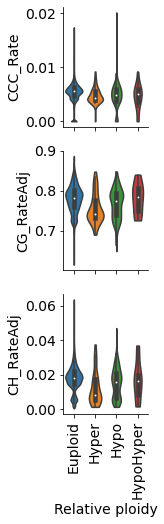

In [333]:
g = sns.PairGrid(data=allcells_df_good,x_vars=['Relative ploidy'],
                 y_vars=['CCC_Rate','CG_RateAdj','CH_RateAdj'])
g.map(sns.violinplot, cut=0)
for ax in g.axes:
    ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=90)

# Analyze number of aneuploid cells by categories

In [334]:
# Plot absolute number of aneuploid cells of each type
from scipy.stats import chi2_contingency,fisher_exact

def fisher_ncells(ncells):
    oe = ncells.div(ncells.sum(axis=0),axis=1)
    oe = oe.div(ncells.sum(axis=1),axis=0)
    oe = oe*(ncells.sum().sum())
    ncells_tot=ncells.sum(axis=0)
    for i,d in ncells.iterrows():
        tab = np.array([d.values, (ncells_tot-d).values])
        ncells.loc[i,['Odds ratio','p']]=fisher_exact(tab)
    ncells['Observed vs Expected'] = oe['Aneuploid']
    ncells['Total'] = ncells['Aneuploid']+ncells['Euploid']
    return ncells

def volcanoplot_ncells(allcells_df_good,groupclass,ax):
    ncells = allcells_df_good.groupby([groupclass,'Aneuploid'])['MAD'].count().unstack()
    ncells = ncells.fillna(0)
    ncells = fisher_ncells(ncells)
    ncells['sig_bool'] = ncells['p']<(0.05/ncells.shape[0])
    ncells['sig'] = ncells['sig_bool'].map({True:'p<0.05 (Bonferroni)',False:'n.s.'})
    
    ncells['Observed vs Expected'] = np.maximum(ncells['Observed vs Expected'],1e-2)
    ncells['Observed vs Expected'] = np.minimum(ncells['Observed vs Expected'],1e2)
    
    sns.scatterplot(data=ncells,
                    x='Observed vs Expected',y='p',ax=ax,
                    hue='sig',hue_order=['n.s.','p<0.05 (Bonferroni)'],palette=['k','r'],
                   )
    for i,nc in ncells.loc[ncells['sig_bool']].iterrows():
        ax.text(nc['Observed vs Expected'],nc['p'],i,fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.invert_yaxis()
    ax.grid()
    ax.set_title(groupclass)
    return ncells

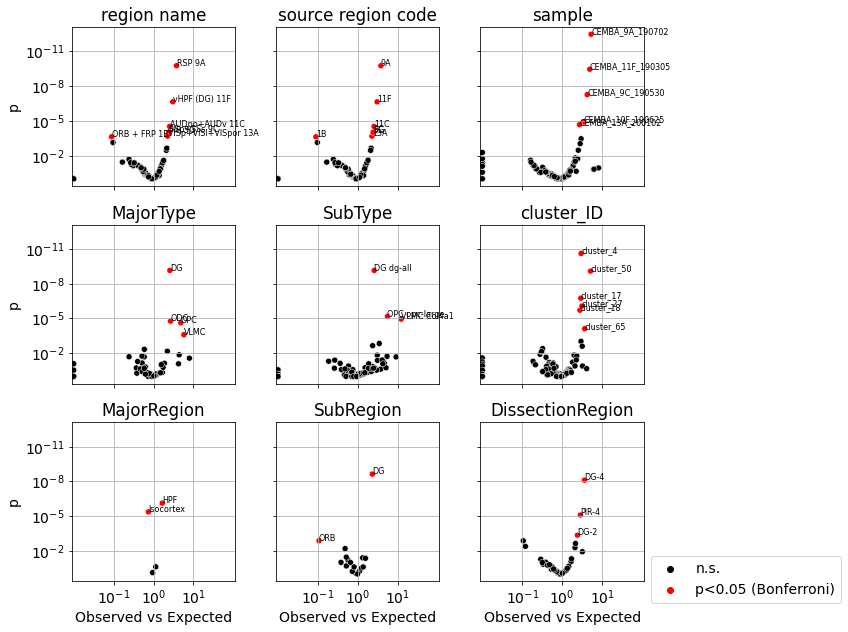

In [335]:
show_classes = ['region name','source region code','sample',
                'MajorType','SubType','cluster_ID',
                'MajorRegion','SubRegion','DissectionRegion',]
nrows=int(np.ceil(len(show_classes)/3))
fig,axs=plt.subplots(nrows,3,figsize=(12,3*nrows),
                     sharex=True,sharey=True)
axs=axs.flatten()
for ax,groupclass in zip(axs,show_classes):
    nc = volcanoplot_ncells(allcells_df_good,groupclass,ax=ax)
    ax.legend(bbox_to_anchor=[1,.2])
    if groupclass!=show_classes[-1]:
        ax.legend().remove()
ax.set_xlim([0.9e-2,1.1e2])
ax.set_xticks([.1,1,10]);
plt.savefig('Plots/CEMBA_VolcanoPlots_aneuploid_per_metadata.pdf')

In [708]:
# Plot absolute number of aneuploid cells of each type
def barplot_ncells(allcells_df_good,groupclass,
                   normalize=False,ax=None,
                   min_cells=50,
                   min_aneuploid_percent=0,
                  ):
    df=allcells_df_good.groupby([groupclass,'Relative ploidy'])['sample'].count()
    df=df.unstack().fillna(0)
    df['total']=df.sum(axis=1)
    df = df.loc[df['total']>min_cells]
    ncells = int(df['total'].sum())
    df_norm = 100*df.div(df['total'],axis=0)

    
    df_norm.index=df_norm.index+' (n='+df.total.astype(int).astype(str)+')'
    df_norm = df_norm.sort_values('Euploid') # Sort by the fraction of euploid cells
    
#     df=df.loc[df_norm['Euploid']<(100-min_aneuploid_percent)]
#     df_norm = df_norm.loc[]
#     df_norm = df_norm.drop(columns=['Euploid','total'])
    
    if ax is None:
        ax=plt.gca()
        figsize=(1.5+df_norm.shape[0]/5,5)
    else:
        figsize=(ax.figure.get_figwidth(),ax.figure.get_figheight())
    show = df_norm['Euploid']<(100-min_aneuploid_percent)
    df_norm.loc[show, ['Hypo','Hyper','HypoHyper']].plot(kind='bar',
                                                    figsize=figsize,
                                                    width=0.9,
                                                    ax=ax,
                                                    color=['b','r','gray'],
                                                    stacked=True)
    plt.ylabel('Percent aneuploid cells')
    plt.grid(axis='y')
    plt.legend(bbox_to_anchor=[1,1])
    plt.title(f'Grouped by {groupclass}, n={ncells} total cells')

    return df_norm,df

In [709]:
allcells_df_good['sample region name'] = allcells_df_good['region name']+';'+allcells_df_good['sample']

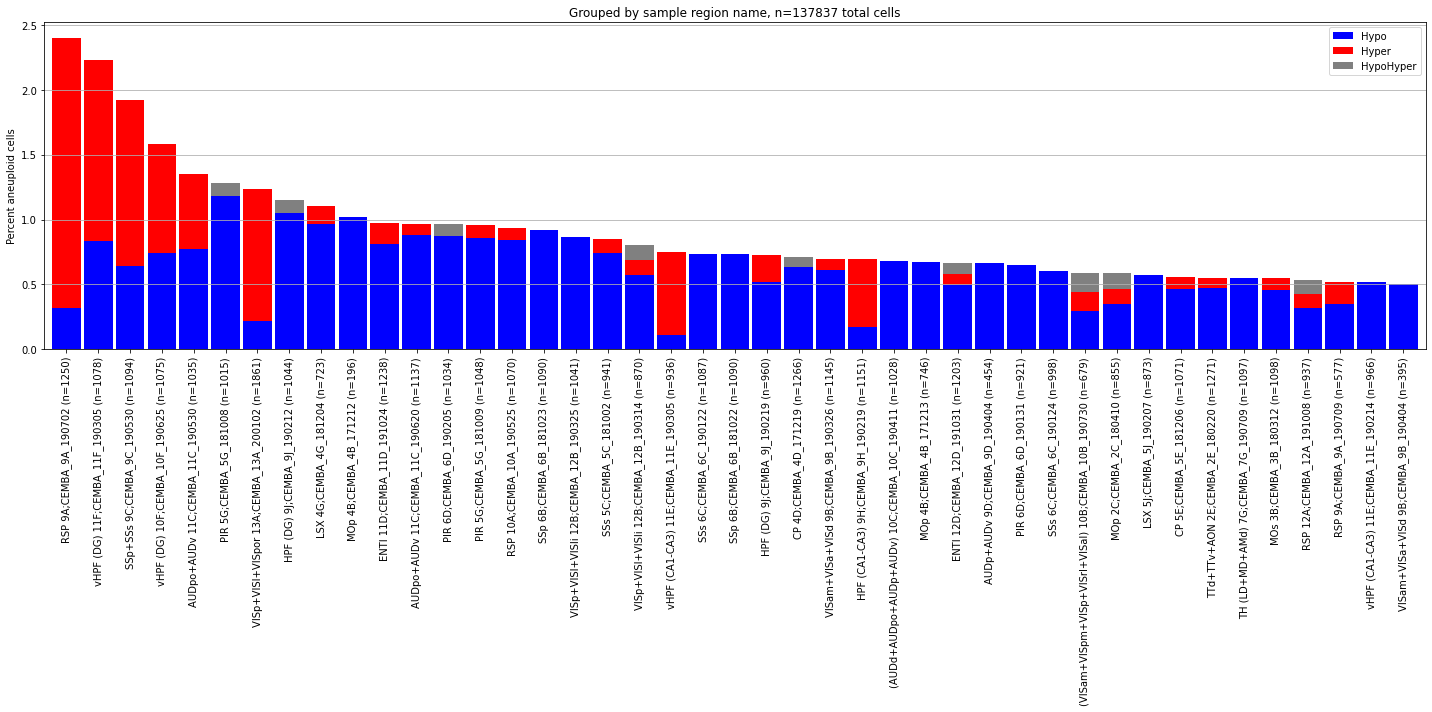

In [716]:
plt.figure(figsize=(20,10))
ax=plt.gca()
df_norm_barplot,df_barplot=barplot_ncells(allcells_df_good.fillna('-'),'sample region name',ax=ax,min_aneuploid_percent=.5);
# df_norm_barplot['Aneuploid'] = df_norm_barplot.sum(axis=1)

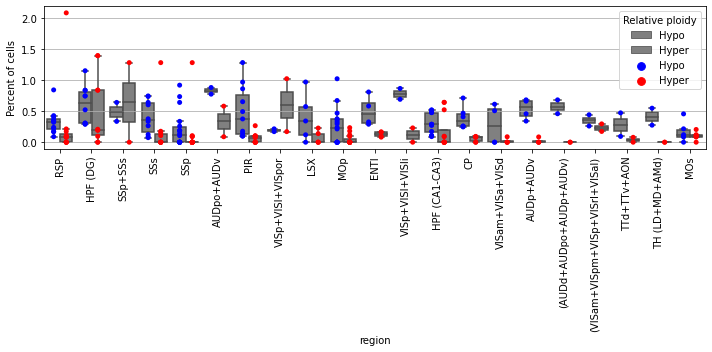

In [719]:
# Box plot of fraction of aneuploid cells by region
show_regions = df_norm_barplot['Euploid']<99.5
show_regions.index=show_regions.index.str.replace(r'[ ]+\(n=[0-9]+\)','',regex=True)
x=allcells_df_good.groupby('sample region name')[['sample','region name','source region code','major region name']].first()
use_regions = x.loc[show_regions[show_regions].index,'major region name'].unique()

df_show = df_norm_barplot.loc[[],:]
for r in use_regions:
    x1=df_norm_barplot.loc[df_norm_barplot.index.str.contains(r,regex=False)].copy()
    x1.loc[:,'region']=r
    df_show=df_show.append(x1)
df_show = df_show.sort_values('Euploid')

# Combine vHPF and HPF
df_show['region']=df_show['region'].str.replace('vHPF','HPF')

df_show['Hypo']+=df_show['HypoHyper']
df_show['Hyper']+=df_show['HypoHyper']
df_show=df_show.reset_index().melt(value_vars=['Hypo','Hyper'],
                                   id_vars=['index','region'],
                                   value_name='Percent of cells')

# Box plot
plt.figure(figsize=(10,5))
plt.rc('font',size=10)
g=sns.boxplot(data=df_show,
              x='region',y='Percent of cells',
              hue='Relative ploidy',
              palette=['gray','gray'],
              fliersize=0,
              )

g=sns.stripplot(data=df_show,
              x='region',y='Percent of cells',
              hue='Relative ploidy',
              palette=['b','r'],
                jitter=False,dodge=True,
              )
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.grid(axis='y')

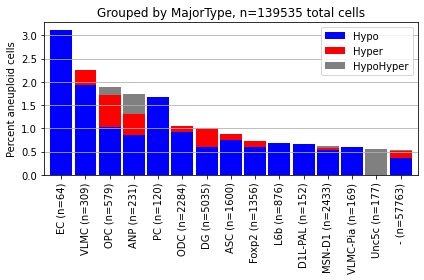

In [720]:
# plt.figure(figsize=(20,10))
ax=plt.gca()
df_norm_barplot,df_barplot=barplot_ncells(allcells_df_good.fillna('-'),
                                          'MajorType',ax=ax,min_aneuploid_percent=.5);

In [802]:
# Box plot of fraction of aneuploid cells by cell type
min_cells = 50
df_show=allcells_df_good.groupby(['Relative ploidy','MajorType','sample'])['cell_id1'].nunique()
df_show=df_show.unstack('Relative ploidy').fillna(0)
df_show['total'] =df_show.sum(axis=1)
df_show = df_show[df_show['total']>=min_cells]
df_show_norm = 100*df_show.div(df_show['total'],axis=0)
df_show_norm['Hypo']+=df_show_norm['HypoHyper']
df_show_norm['Hyper']+=df_show_norm['HypoHyper']
df_show_norm=df_show_norm[['Hypo','Hyper']].reset_index().melt(value_vars=['Hypo','Hyper'],
                                   id_vars=['MajorType','sample'],
                                   value_name='Percent of cells')
df_show_norm=df_show_norm.sort_values('Percent of cells',ascending=False)

Text(0.5, 1.0, 'Showing cell types with ≥50 cells')

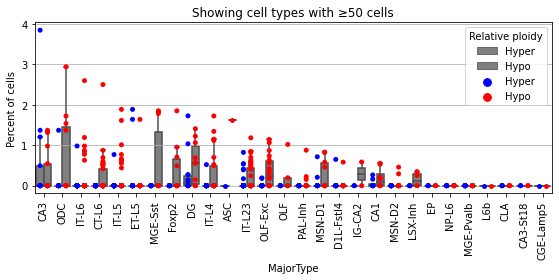

In [803]:
plt.figure(figsize=(8,4))
g=sns.boxplot(data=df_show_norm,
              x='MajorType',y='Percent of cells',
              hue='Relative ploidy',
              palette=['gray','gray'],
              fliersize=0,
              )
g=sns.stripplot(data=df_show_norm,
              x='MajorType',y='Percent of cells',
              hue='Relative ploidy',
              palette=['b','r'],
                jitter=False,dodge=True,
              )
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.grid(axis='y')
g.set_title(f'Showing cell types with ≥{min_cells} cells')

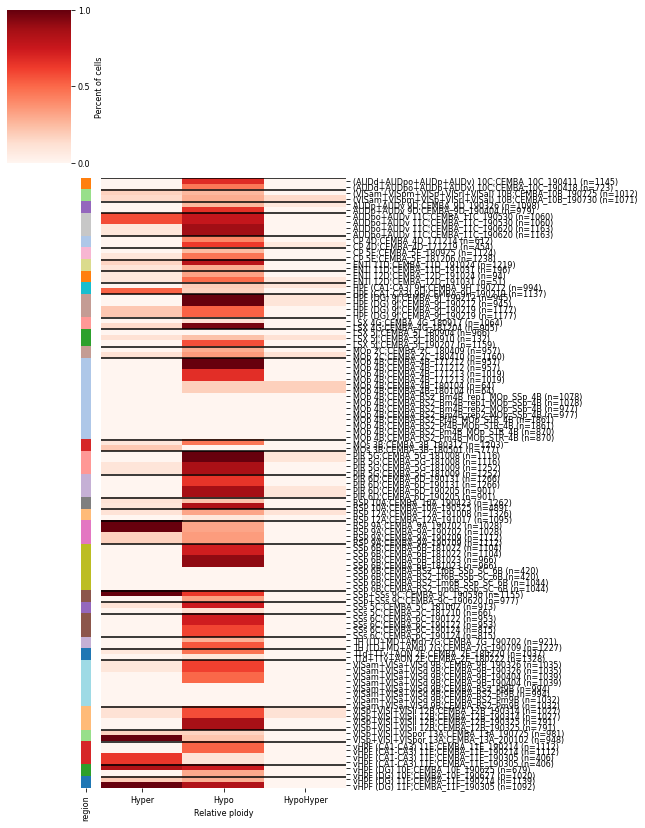

In [620]:
# Heatmap of % aneuploid cells per sample
def cat2colors(metadata_df):
    cm = plt.cm.tab20.colors*100
    col_df = pd.DataFrame(index=metadata_df.index)
    metadata_df=metadata_df.fillna('-')
    i=0
    for k in metadata_df:
        vals=metadata_df[k].unique()
        vals=np.random.choice(vals,replace=False,size=len(vals))
        lut = dict(zip(vals, cm[i:]))
        col_df[k] = metadata_df[k].map(lut)
        i+=metadata_df[k].nunique()
    return col_df

row_colors = cat2colors(df_show[['region']])
yticks=np.where(~df_show['region'].duplicated())

plt.rc('font',size=8)
g=sns.clustermap(data=df_show[['Hyper','Hypo','HypoHyper']],
                 vmin=0,vmax=1,
               row_colors=row_colors,
               row_cluster=False,col_cluster=False,
               yticklabels=True,xticklabels=True,
               cmap='Reds',
                 cbar_kws={'label':'Percent of cells','ticks':[0,.5,1]},
                 figsize=(9,1+0.1*df_show.shape[0]),
              )
# g.ax_heatmap.set_fontsize(8)
g.ax_heatmap.hlines(yticks,*g.ax_heatmap.get_xlim(),color='k')

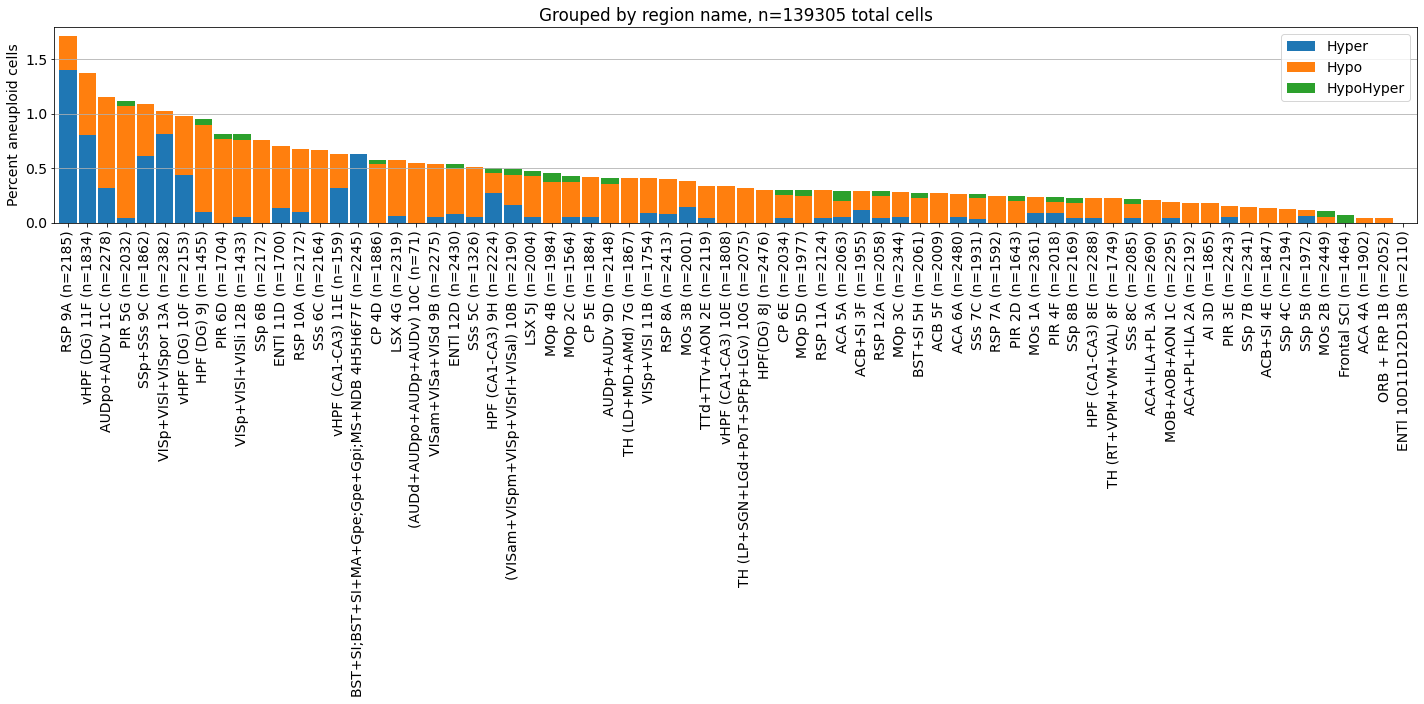

In [461]:
for groupclass in ['region name','major region name','SubType']:
    plt.figure(figsize=(20,10))
    ax=plt.gca()
    df_norm_barplot,df_barplot=barplot_ncells(allcells_df_good.fillna('-'),'region name',ax=ax);

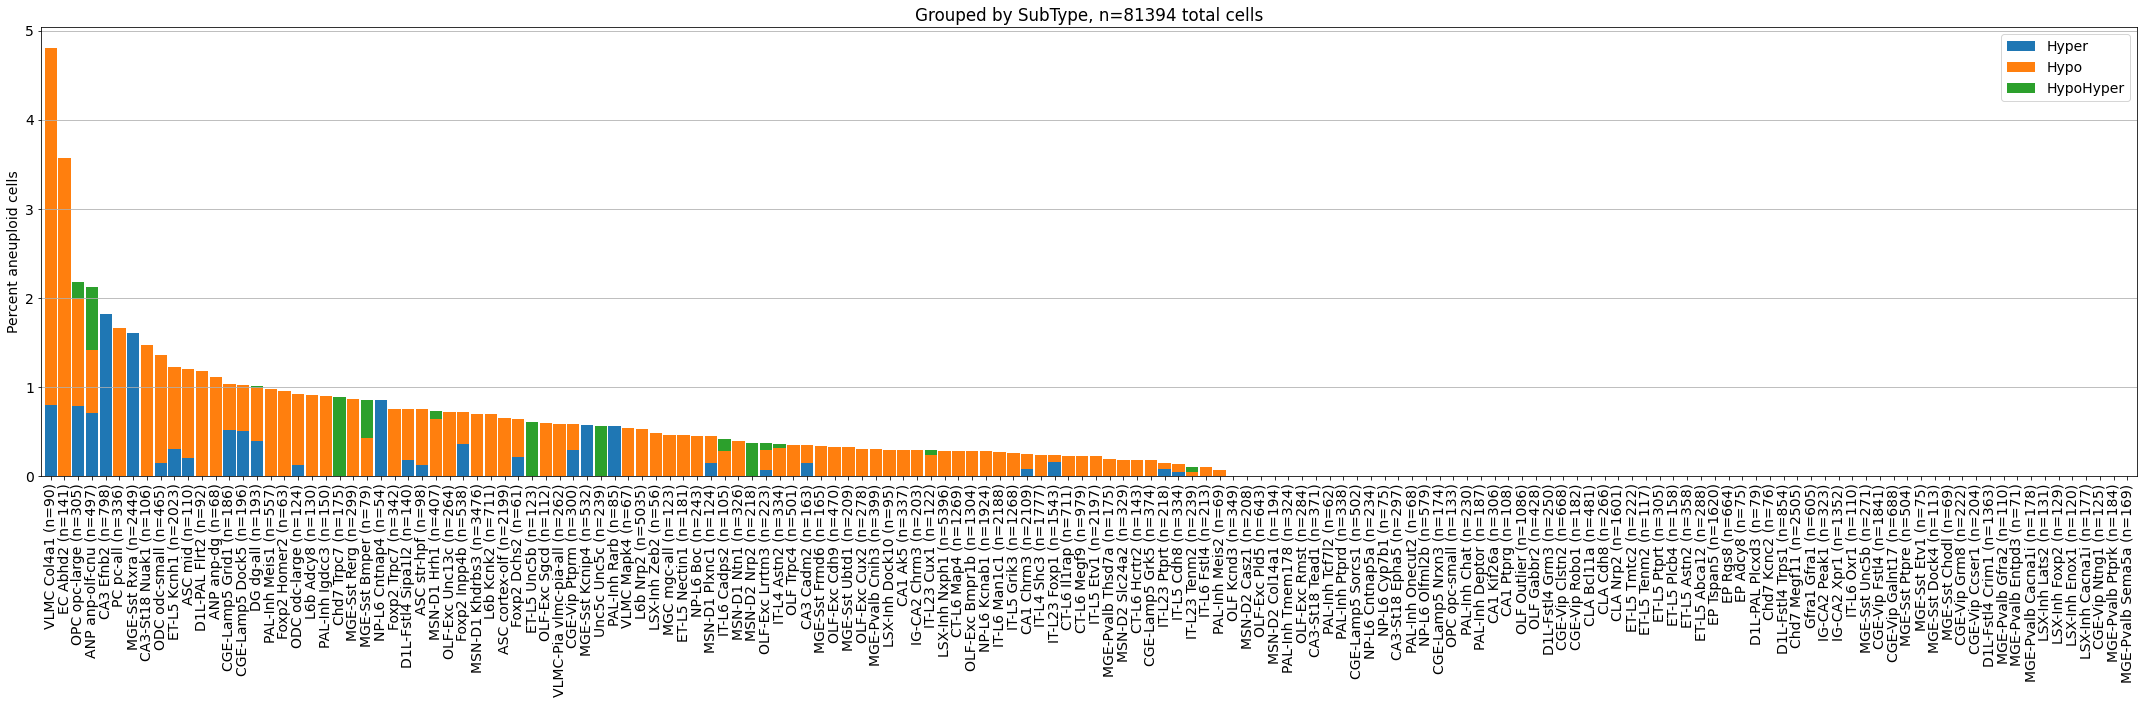

In [420]:
plt.figure(figsize=(30,10))
ax=plt.gca()
df_norm_barplot,df_barplot=barplot_ncells(allcells_df_good,'SubType',ax=ax);

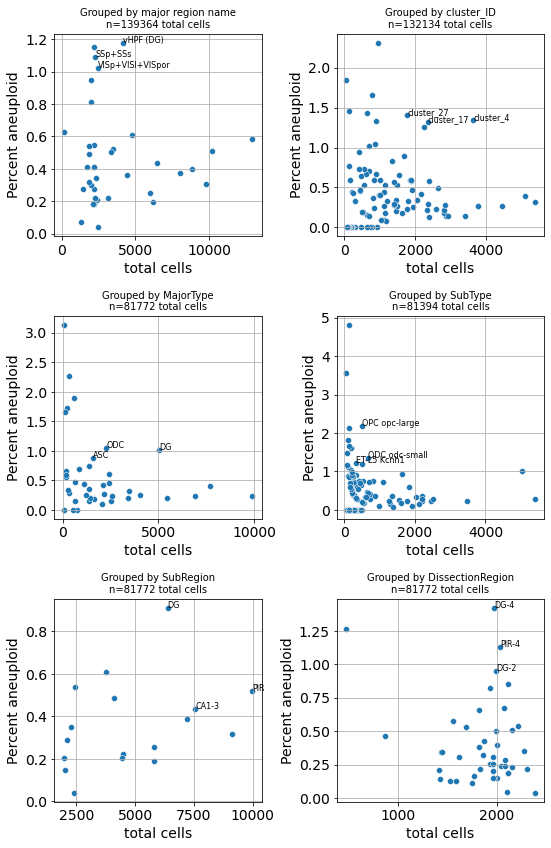

In [460]:
def maplot_ncells(allcells_df_good,
                  groupclass,
                ax=None,
                   min_cells=50,
                  ):
    # Show total cells vs. fraction aneuploid
    df=allcells_df_good.groupby([groupclass,'Relative ploidy'])['sample'].count()
    df=df.unstack().fillna(0)
    df['total cells']=df.sum(axis=1)
    df = df.loc[df['total cells']>min_cells]
    ncells = int(df['total cells'].sum())

    df['Frac. hyper'] = (df['Hyper']+df['HypoHyper'])/df['total cells']
    df['Frac. hypo'] = (df['Hypo']+df['HypoHyper'])/df['total cells']
    df['Percent aneuploid'] = 100-100*df['Euploid']/df['total cells']
    
    if ax is None:
        ax=plt.gca()
        figsize=(1.5+df_norm.shape[0]/5,5)
    else:
        figsize=(ax.figure.get_figwidth(),ax.figure.get_figheight())
    sns.scatterplot(data=df,
                    x='total cells',y='Percent aneuploid',
                    ax=ax,
                   )
    ax.grid(True)
    ax.set_title(f'Grouped by {groupclass}\nn={ncells} total cells',fontsize=10)

    label_cells = df[df['total cells']>df['total cells'].quantile(.5)]
    label_cells = label_cells.sort_values('Percent aneuploid').index[-3:]
    for c in label_cells:
        ax.text(df.loc[c,'total cells'],df.loc[c,'Percent aneuploid'],c,fontsize=8)
    
    return

fig,axs=plt.subplots(3,2,figsize=(8,12),sharex=False,sharey=False)
axs=axs.flatten()
for ax,groupclass in zip(axs,['major region name','cluster_ID', #'region name',
                              'MajorType','SubType',
                              'SubRegion',
                              'DissectionRegion',]):
    maplot_ncells(allcells_df_good,groupclass,ax=ax)

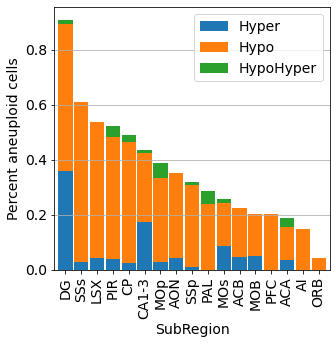

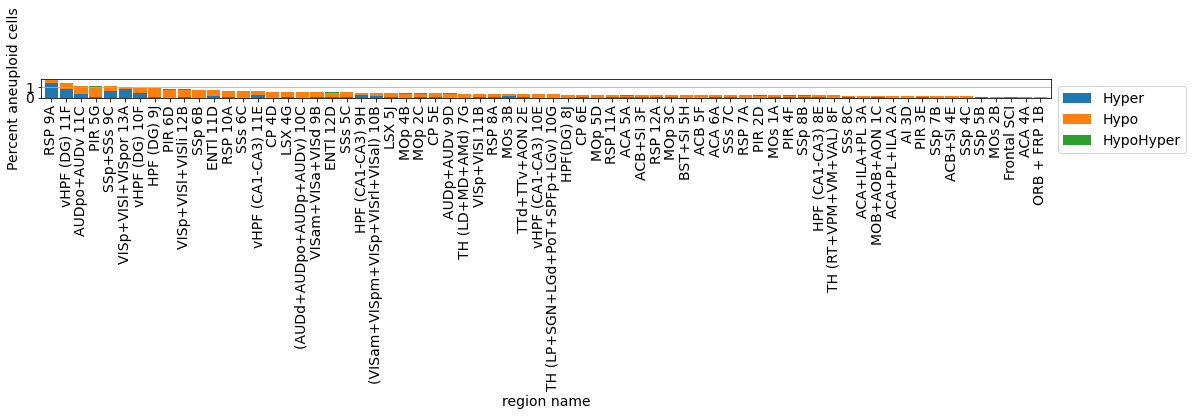

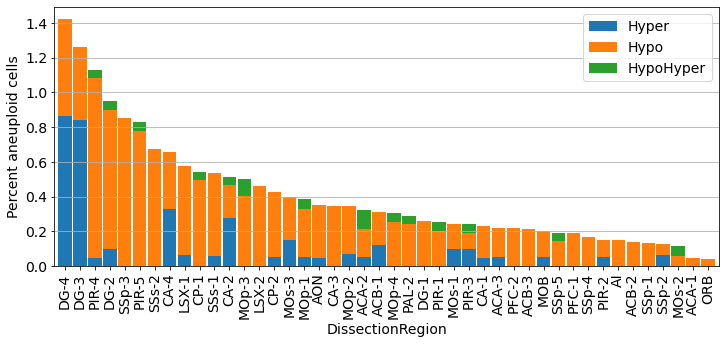

/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


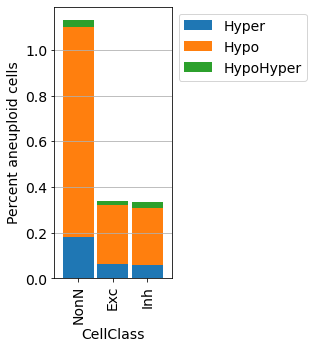

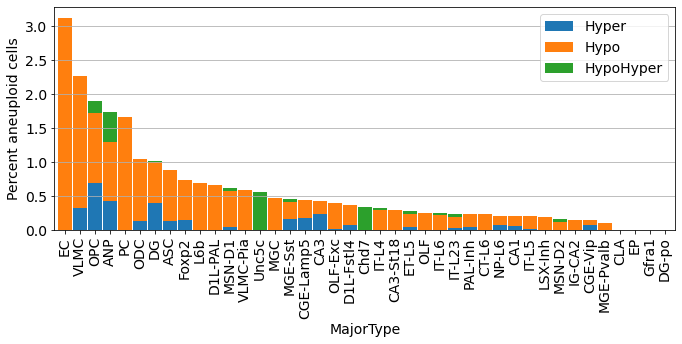

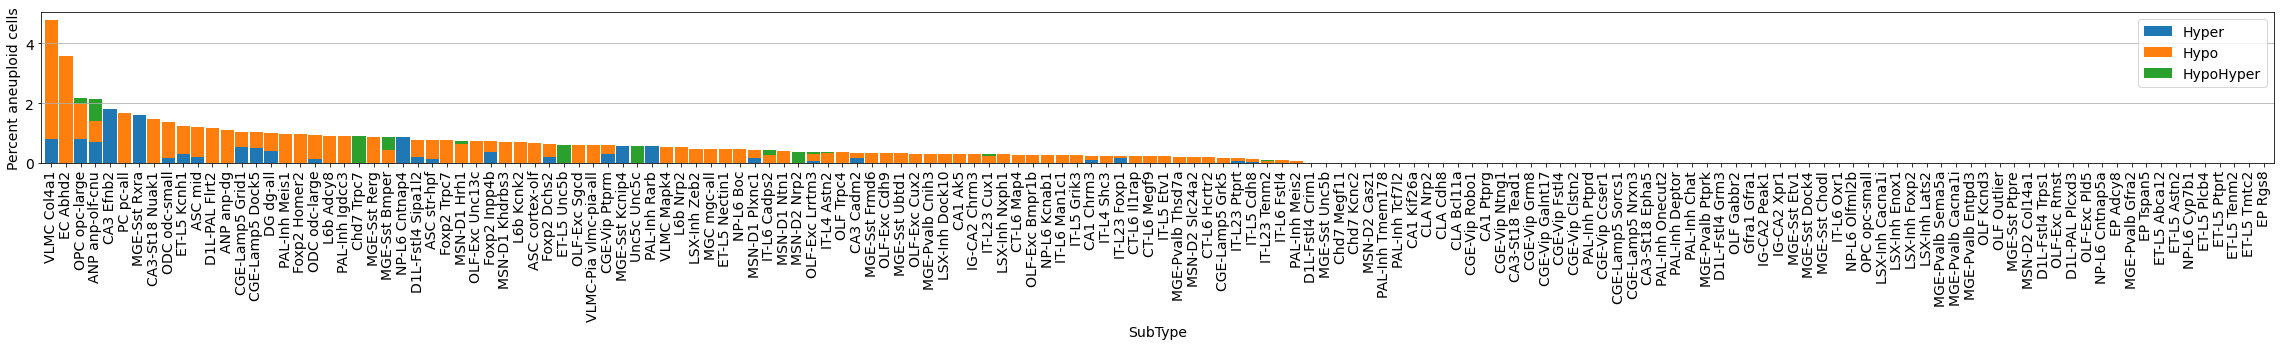

In [369]:
for cat in ['SubRegion','DissectionRegion','CellClass','MajorType','SubType']:
    df_barplot=barplot_ncells(allcells_df_good,cat);
    np.argsort
# allcells_df_good.groupby([groupclass,'Relative ploidy'])['cell_id1'].count().plot(kind='bar')

In [331]:
allcells_df_good.columns

Index(['cell_id1', 'cluster_ID', 'tsne_x', 'tsne_y', 'CellID', 'CCC_Rate',
       'CG_RateAdj', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads',
       'FACS_Date', 'Slice', 'CellClass', 'MajorType', 'SubType', 'l1-umap_0',
       'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'l2-tsne_0', 'l2-tsne_1',
       'l2-umap_0', 'l2-umap_1', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0',
       'l3-tsne_1', 'MajorRegion', 'SubRegion', 'DissectionRegion', 'MAD',
       'Reads', 'Bins', 'Mean', 'Std', 'Disp', 'Min', '25th', 'Median', '75th',
       'Max', 'sample', 'Aneuploid', 'region code', 'source region code',
       'ABA name (based on posterior face of the slice)',
       'ABA name (all regions included in this dissection)', 'Broad region',
       'Broad region description', 'region name', 'Relative ploidy'],
      dtype='object')

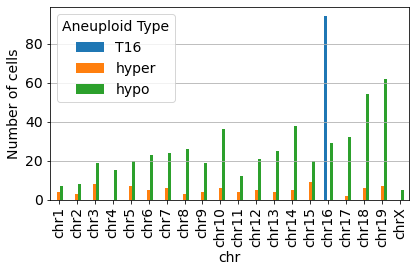

In [75]:
min_frac_aneuploid = 0.9
aneu_df = aneu_cells_df[(aneu_cells_df['FracAneuploid']>min_frac_aneuploid) & (aneu_cells_df['Reads']>min_reads)]
aneu_df = aneu_df[['cell','chr','ploidy','length','FracAneuploid']]

aneu_df['Aneuploid Type'] = ''
aneu_df.loc[aneu_df['ploidy']<2,'Aneuploid Type'] = 'hypo'
aneu_df.loc[aneu_df['ploidy']>2,'Aneuploid Type'] = 'hyper'
aneu_df.loc[(aneu_df['ploidy']>1) & (aneu_df['chr']=='chrX'),'Aneuploid Type'] = 'hyper'
aneu_df.loc[(aneu_df['ploidy']==3) & (aneu_df['chr']=='chr16'),'Aneuploid Type'] = 'T16'

dfu = aneu_df.groupby(['Aneuploid Type','chr'])['cell'].count().unstack().fillna(0)
chroms = [f'chr{i+1}' for i in range(19)]+['chrX']
dfu = dfu[chroms].T
dfu.plot(kind='bar')
plt.ylabel('Number of cells')
plt.grid(axis='y')
plt.savefig('Plots/CEMBA_nAneuploidCells_per_Chrom_barplot.pdf')

In [77]:
# aneu_df['cell2'] = samples2cells(aneu_df['cell'])
# dfu_annot = dfu.merge(allcells_df_good.reset_index()[['Slice','CellClass','MajorType',
#                                               'SubType','MajorRegion','SubRegion','DissectionRegion','sample','index']],
#               right_on='index',left_on='cell2')

<Figure size 432x720 with 0 Axes>

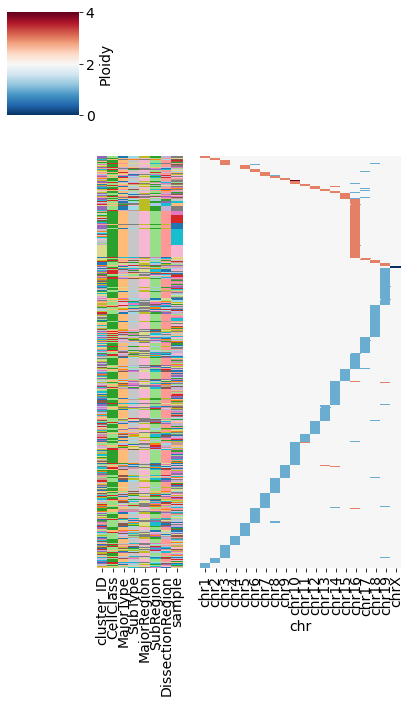

In [126]:
dfu = aneu_df.groupby(['cell','chr'])['ploidy'].first().unstack().fillna(2).astype(int)
dfu = dfu[chroms].sort_values(chroms,ascending=False)
dfu.index = samples2cells(dfu.index)
allcells_df_good.index = samples2cells(allcells_df_good.index)
_,dfu_annot = dfu.align(allcells_df_good[['cluster_ID','CellClass', 'MajorType', 'SubType','MajorRegion', 'SubRegion', 'DissectionRegion','sample']],
                        axis=0,join='inner')

# Heatmap of all pairwise correlations
# Clustermap
def cat2colors(metadata_df):
    cm = plt.cm.tab20.colors*100
    col_df = pd.DataFrame(index=metadata_df.index)
    metadata_df=metadata_df.fillna('-')
    i=0
    for k in metadata_df:
        vals=metadata_df[k].unique()
        vals=np.random.choice(vals,replace=False,size=len(vals))
        lut = dict(zip(vals, cm[i:]))
        col_df[k] = metadata_df[k].map(lut)
        i+=metadata_df[k].nunique()
    return col_df

row_colors = cat2colors(dfu_annot)

# dfu.map({0:'Euploid'})
plt.figure(figsize=(6,10))
sns.clustermap(dfu,row_colors=row_colors,
               col_cluster=False,row_cluster=False,
            yticklabels=False,xticklabels=True,
               
            cmap=plt.cm.RdBu_r,center=2,figsize=(6,10),
               cbar_kws={'label':'Ploidy'}
           )


In [116]:
cells_df['cell_id'] = samples2cells(cells_df.index.get_level_values('cell'))

In [117]:
dfu = aneu_df[['cell','Aneuploid Type']]
dfu['cell'] = samples2cells(dfu['cell'])
dfu = cell_clusters.merge(dfu[['cell','Aneuploid Type']],on='cell',how='left')
dfu['Aneuploid Type'].fillna('Euploid',inplace=True)
dfu=dfu.merge(cells_df[['cell_id','region name','region code','source region code','ABA name (based on posterior face of the slice)',
       'ABA name (all regions included in this dissection)', 'Broad region',
       'Broad region description']], left_on='cell',right_on='cell_id')
dfu['Aneuploid Type'].value_counts()

/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Euploid    85394
hypo         479
hyper         85
T16           75
Name: Aneuploid Type, dtype: int64

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


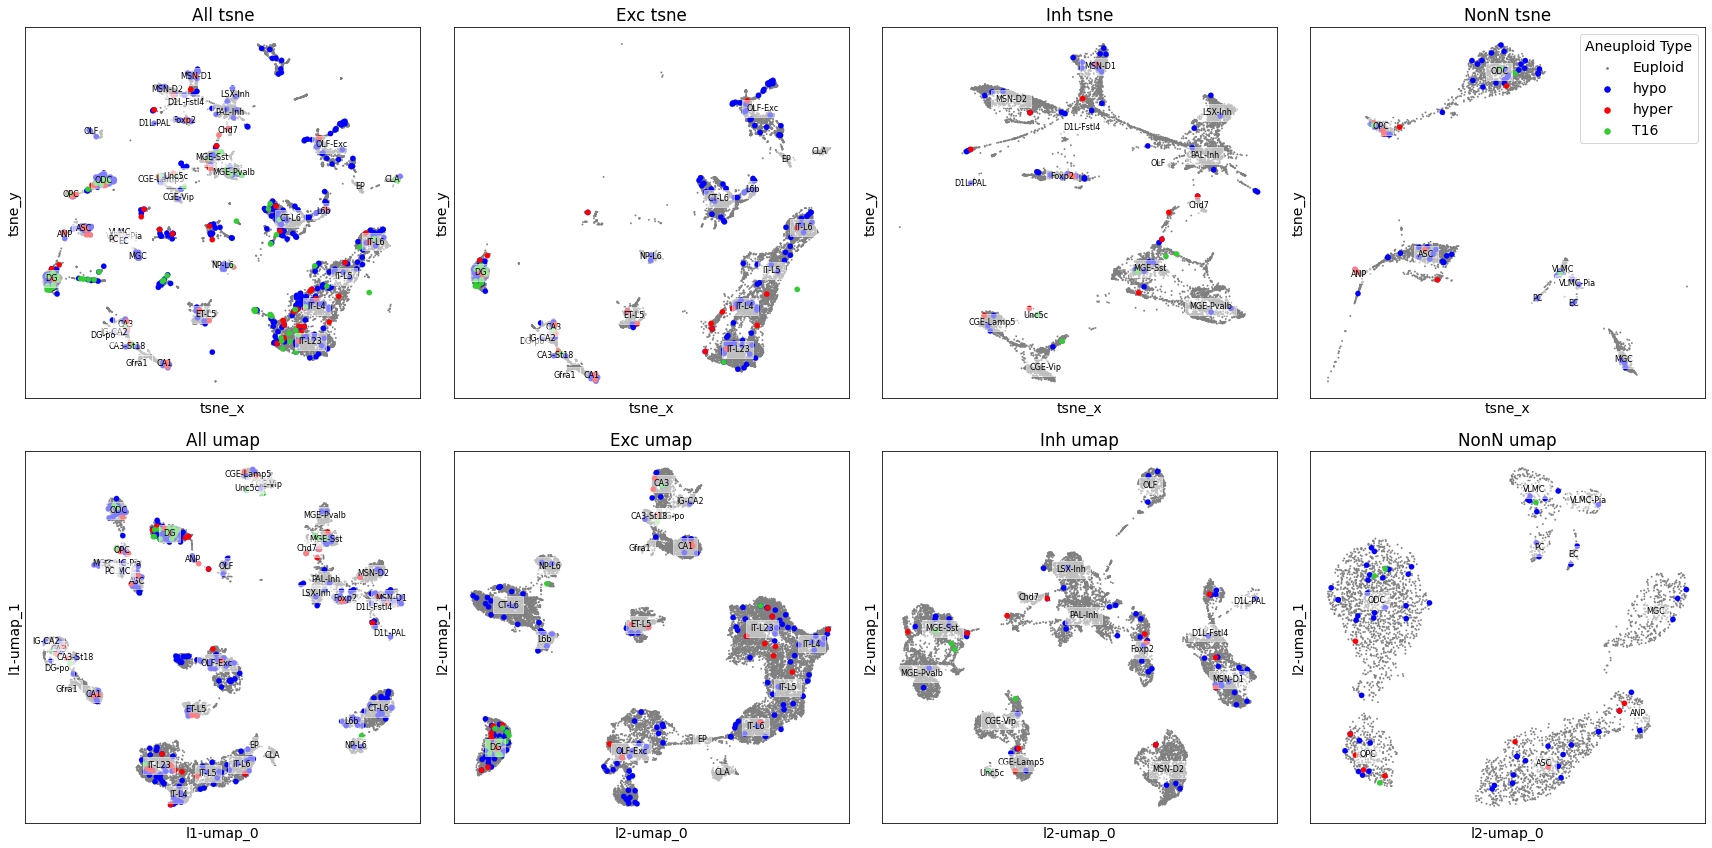

In [89]:
# UMAP and tSNE with aneuploid cells marked
annot='MajorType'
nshow = 20000

fig,axs=plt.subplots(2,4,sharex=False,sharey=False,figsize=(24,12))
for i,cellclass in enumerate(['All','Exc','Inh','NonN']):
    for j,embedding in enumerate(['tsne','umap']):
        ax=axs[j,i]
        if cellclass=='All':
            dfuu = dfu.copy()
        else:
            dfuu = dfu[dfu['CellClass']==cellclass]
        if dfuu.shape[0]>nshow: # Downsample points
            dfuu = pd.concat((dfuu[dfuu['Aneuploid Type']=='Euploid'].sample(nshow, random_state=1),
                              dfuu[dfuu['Aneuploid Type']!='Euploid']),axis=0)
        ploidy_map={'Euploid':0,'hypo':1,'hyper':2,'T16':3}
        dfuu = dfuu.sort_values('Aneuploid Type',key=lambda x: x.map(ploidy_map))
        if embedding=='tsne':
            x,y='tsne_x','tsne_y'
            dfuu[[x,y]] = dfuu[[x,y]] - dfuu[[x,y]].median()
            # Remove outliers
            outliers = dfuu[x].abs()>(1.5*dfuu[x].abs().quantile(.95))
            outliers += dfuu[y].abs()>(1.5*dfuu[y].abs().quantile(.95))
            dfuu = dfuu[~outliers]
        else:
            if cellclass=='All':
                x,y='l1-umap_0','l1-umap_1'
            else:
                x,y='l2-umap_0','l2-umap_1'
                
        sns.scatterplot(data=dfuu,
                        x=x,y=y,
                        ax=ax,
                        edgecolor=None,
                        hue='Aneuploid Type',
                        legend=(i==3)&(j==0),
                        hue_order=['Euploid', 'hypo', 'hyper', 'T16'],
                        palette={'Euploid':'gray', 'hypo':'b', 'hyper':'r', 'T16':'limegreen'},
                        size='Aneuploid Type',
                        sizes={'Euploid':3, 'hypo':30, 'hyper':30, 'T16':30},
                       )
        
        # add cluster labels
        for label in dfuu[annot].unique():
            t=ax.annotate(label, 
                         dfuu.loc[dfuu[annot]==label,[x,y]].median(),
                         horizontalalignment='center',
                         verticalalignment='center',
                         size=8,
                         color='black',
                         backgroundcolor='white',
                       ) 
            t.set_bbox(dict(alpha=.5,edgecolor='w',facecolor='w'))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{cellclass} {embedding}')
plt.savefig('Plots/CEMBA_UMAP_tSNE_aneu.png',dpi=300)

<AxesSubplot:ylabel='region name'>

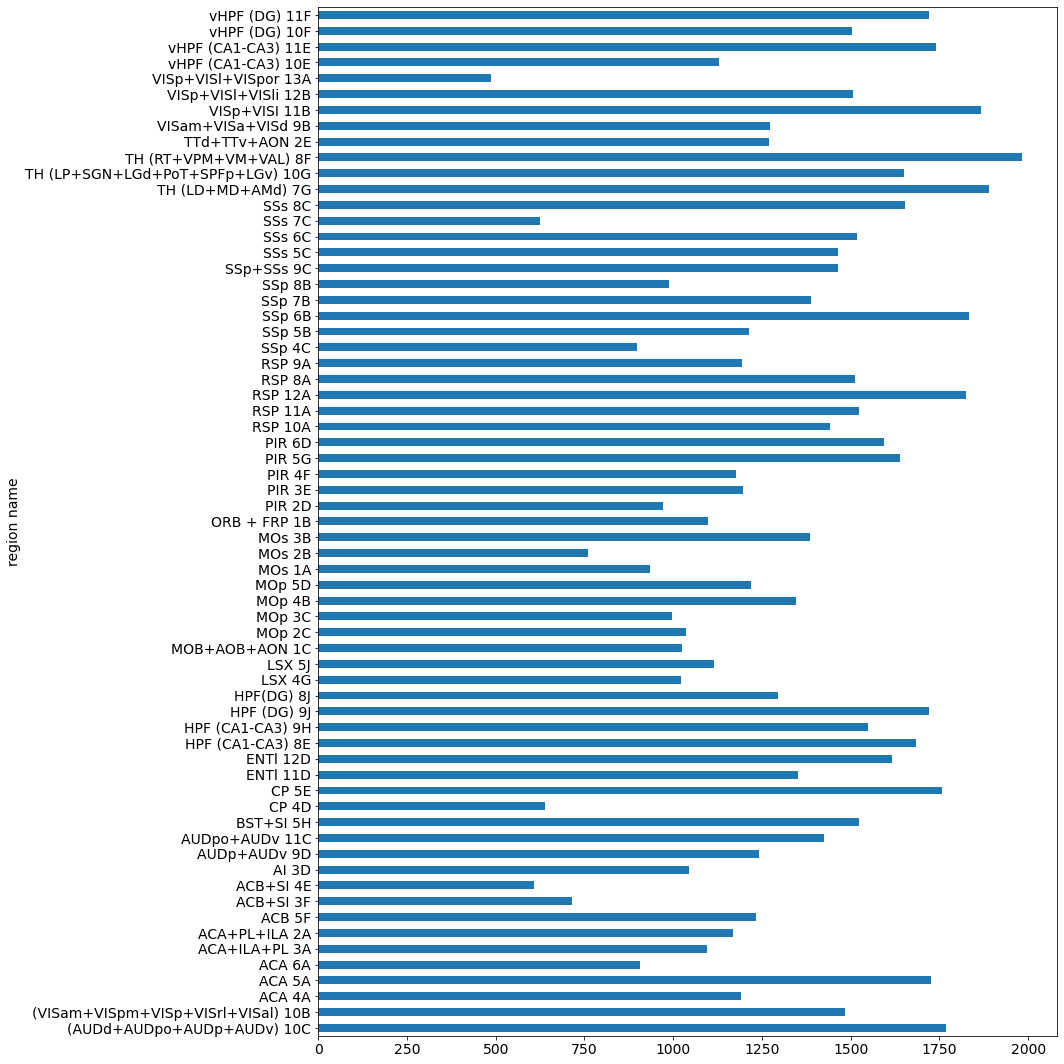

In [121]:
# dfu['region name'] = dfu['DissectionRegion']+' ('+dfu['source region code'].astype(str)+')'
# dfu['region name'].fillna(dfu['source region code'],inplace=True)
plt.figure(figsize=(15,15))
dfu.groupby('region name')['region code'].count().plot(kind='barh')


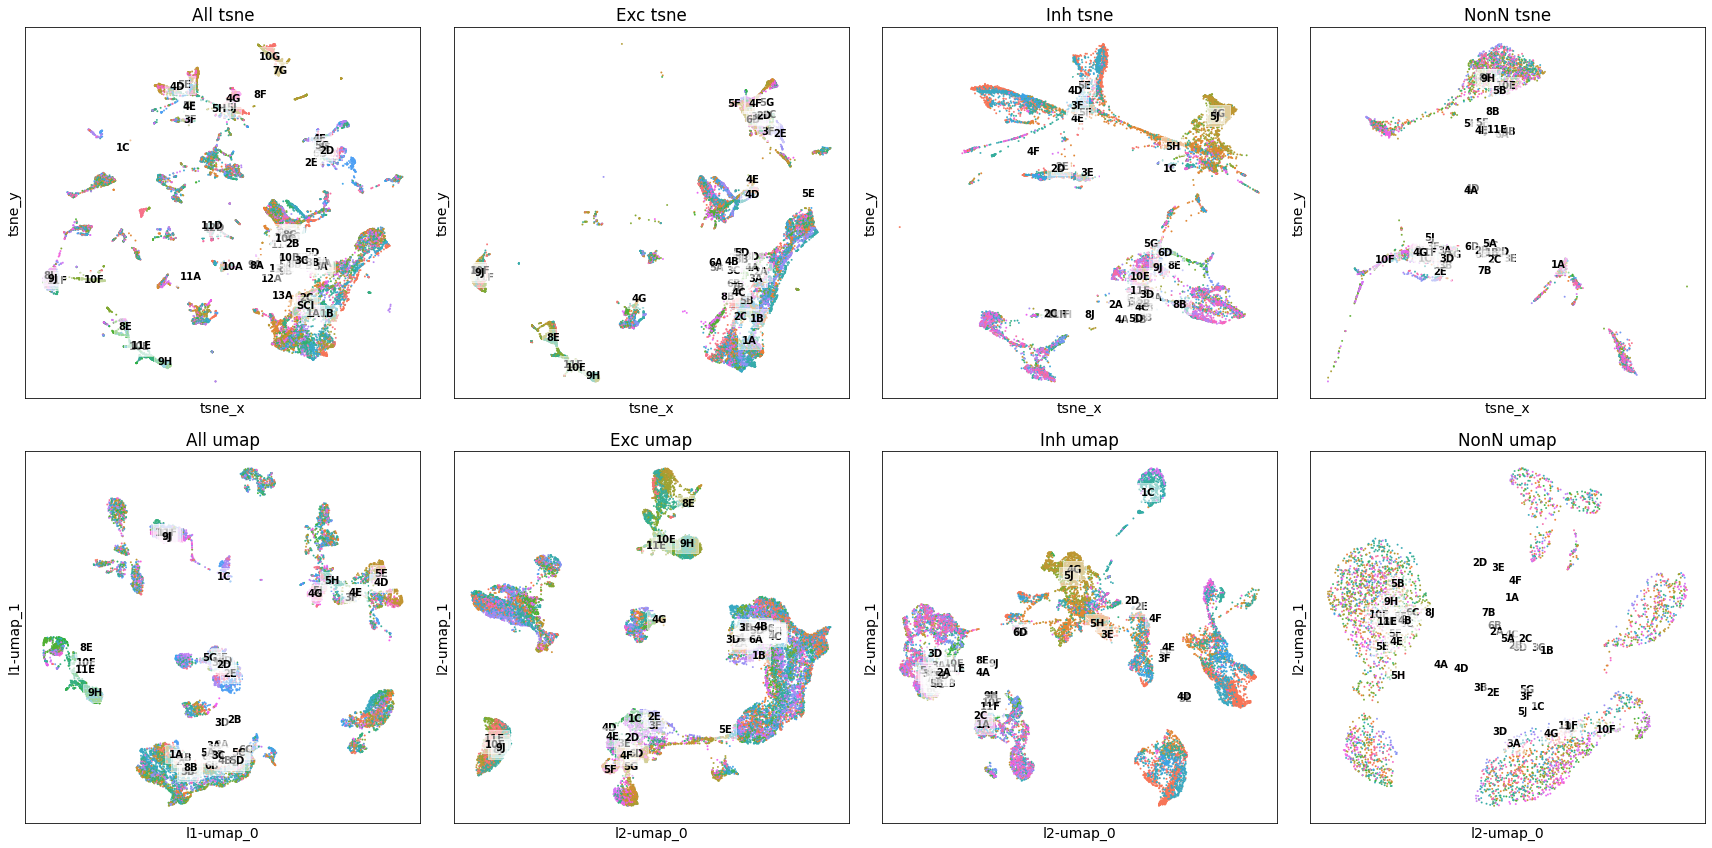

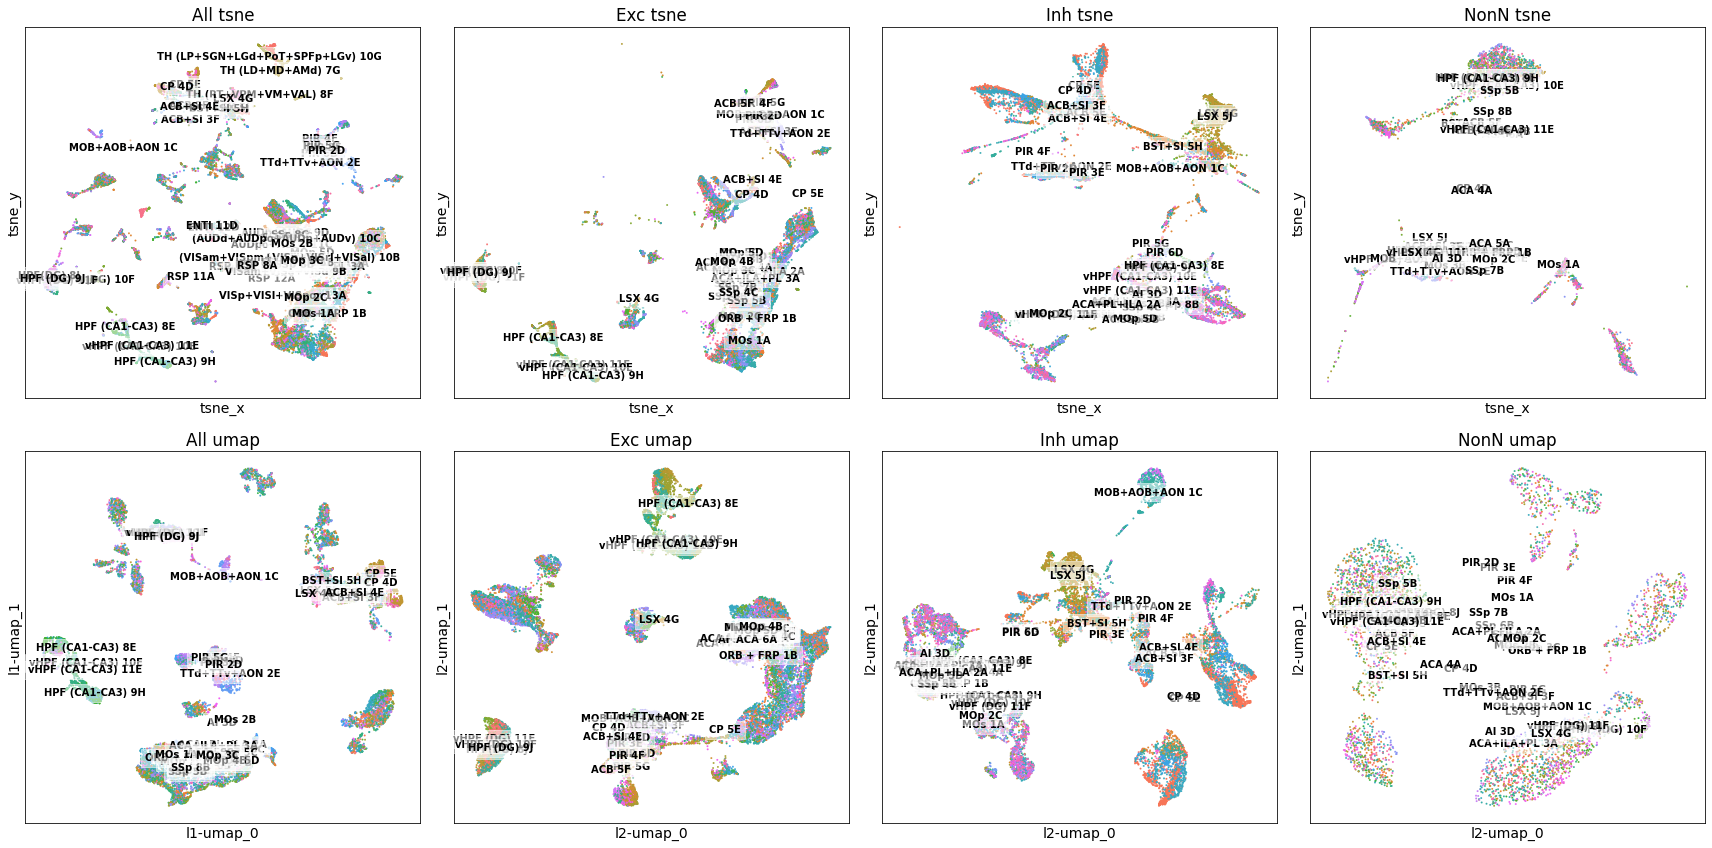

In [120]:
# UMAP and tSNE with cell type annotations
annot='MajorType'
# for annot in ['CellClass', 'MajorType','MajorRegion', 'SubRegion','DissectionRegion']:
for annot in ['source region code','region name']:
    nshow = 20000

    fig,axs=plt.subplots(2,4,sharex=False,sharey=False,figsize=(24,12))
    for i,cellclass in enumerate(['All','Exc','Inh','NonN']):
        for j,embedding in enumerate(['tsne','umap']):
            ax=axs[j,i]
            if cellclass=='All':
                dfuu = dfu.copy()
            else:
                dfuu = dfu[dfu['CellClass']==cellclass]
            if dfuu.shape[0]>nshow: # Downsample points
                dfuu = pd.concat((dfuu[dfuu['Aneuploid Type']=='Euploid'].sample(nshow, random_state=1),
                                  dfuu[dfuu['Aneuploid Type']!='Euploid']),axis=0)
            ploidy_map={'Euploid':0,'hypo':1,'hyper':2,'T16':3}
            dfuu = dfuu.sort_values('Aneuploid Type',key=lambda x: x.map(ploidy_map))
            if embedding=='tsne':
                x,y='tsne_x','tsne_y'
                dfuu[[x,y]] = dfuu[[x,y]] - dfuu[[x,y]].median()
                # Remove outliers
                outliers = dfuu[x].abs()>(1.5*dfuu[x].abs().quantile(.95))
                outliers += dfuu[y].abs()>(1.5*dfuu[y].abs().quantile(.95))
                dfuu = dfuu[~outliers]
            else:
                if cellclass=='All':
                    x,y='l1-umap_0','l1-umap_1'
                else:
                    x,y='l2-umap_0','l2-umap_1'

            sns.scatterplot(data=dfuu,
                            x=x,y=y,
                            ax=ax,
                            edgecolor=None,
                            hue=annot,
                            legend=False,
                            s=3
                           )
            # add cluster labels
            for label in dfuu[annot].unique():
                t=ax.annotate(label, 
                             dfuu.loc[dfuu[annot]==label,[x,y]].median(),
                             horizontalalignment='center',
                             verticalalignment='center',
                             size=10,
                             weight='bold',
                             color='black',
                             backgroundcolor='white',
                           ) 
                t.set_bbox(dict(alpha=.5,edgecolor='w',facecolor='w'))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'{cellclass} {embedding}')
    plt.savefig(f'Plots/CEMBA_UMAP_tSNE_{annot}.png',dpi=300)

# Heatmaps of SegNorm

<Figure size 432x720 with 0 Axes>

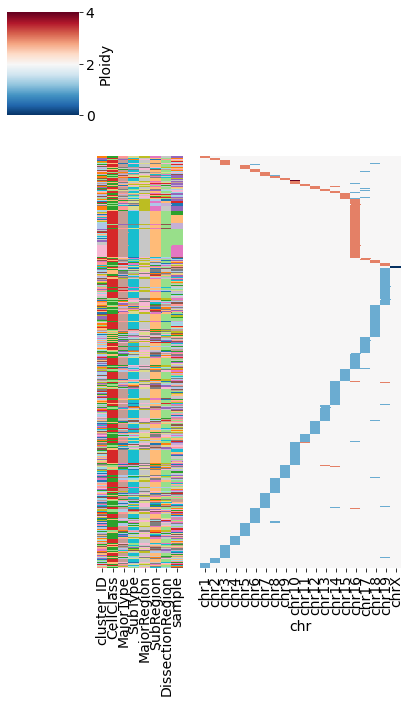

In [244]:
dfu = aneu_df.groupby(['cell','chr'])['ploidy'].first().unstack().fillna(2).astype(int)
dfu = dfu[chroms].sort_values(chroms,ascending=False)
dfu.index = samples2cells(dfu.index)
cells_order=dfu.index
allcells_df_good.index = samples2cells(allcells_df_good.index)
_,dfu_annot = dfu.align(allcells_df_good[['cluster_ID','CellClass', 'MajorType', 'SubType','MajorRegion', 'SubRegion', 'DissectionRegion','sample']],
                        axis=0,join='inner')

# Heatmap of all pairwise correlations
# Clustermap
def cat2colors(metadata_df):
    cm = plt.cm.tab20.colors*100
    col_df = pd.DataFrame(index=metadata_df.index)
    metadata_df=metadata_df.fillna('-')
    i=0
    for k in metadata_df:
        vals=metadata_df[k].unique()
        vals=np.random.choice(vals,replace=False,size=len(vals))
        lut = dict(zip(vals, cm[i:]))
        col_df[k] = metadata_df[k].map(lut)
        i+=metadata_df[k].nunique()
    return col_df

row_colors = cat2colors(dfu_annot)

# dfu.map({0:'Euploid'})
plt.figure(figsize=(6,10))
sns.clustermap(dfu,row_colors=row_colors,
               col_cluster=False,row_cluster=False,
            yticklabels=False,xticklabels=True,
               
            cmap=plt.cm.RdBu_r,center=2,figsize=(6,10),
               cbar_kws={'label':'Ploidy'}
           )

In [245]:
# Define functions for plotting segcopy and segnorm
def resample_bins(df,binsize,normalize=False):
    df = df.reset_index(drop=True)
    df['bin']=np.floor(df['bin']/binsize)*binsize
    df['bin']=df['bin'].astype(int)
    if normalize:
        df=df.groupby(['chr','bin']).mean()
    else:
        df=df.groupby(['chr','bin']).sum()
    return df

def load_segcopy(sample,cells,binsize=1e6):
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    t0=time.time()
    segcopy = pd.read_csv(sampledir+'/SegCopy.gz', sep='\t',
                  usecols=['CHR','START','END']+list(cells),)
    segnorm = pd.read_csv(sampledir+'/SegNorm.gz', sep='\t',
                  usecols=['CHR','START','END']+list(cells),)

    # Keep only the bins with the normative binsize
    input_binsize=(segcopy['END']-segcopy['START']).median()
    goodbins = (segcopy['END']-segcopy['START'] == input_binsize) & (segcopy['CHR']!='1')
    segcopy = segcopy.loc[goodbins]
    segcopy = segcopy.drop(columns='END')
    segcopy = resample_bins(segcopy.reset_index(drop=True).rename(columns={'START':'bin','CHR':'chr'}),binsize=binsize,normalize=True)
    segcopy.columns.names=['cell']
    segcopy = pd.concat({sample: segcopy}, names=['sample'],axis=1)
    
    goodbins = (segnorm['END']-segnorm['START'] == input_binsize) & (segnorm['CHR']!='1')
    segnorm = segnorm.loc[goodbins]
    segnorm = segnorm.drop(columns='END')
    segnorm = resample_bins(segnorm.reset_index(drop=True).rename(columns={'START':'bin','CHR':'chr'}),binsize=binsize,normalize=True)
    segnorm.columns.names=['cell']
    segnorm = pd.concat({sample: segnorm}, names=['sample'],axis=1)

    return segcopy,segnorm

def my_load_segcopy(cells):
    # cells - dataframe with sample, cell
    samples=cells['sample'].unique()
    cells_lists = []
    for sample in samples:
        cells_lists.append(cells.loc[cells['sample']==sample,'cell'])
    with Pool() as p:
        data = p.starmap(load_segcopy, zip(samples, cells_lists))
    segcopy = data[0][0].join([i[0] for i in data[1:]])
    segnorm = data[0][1].join([i[1] for i in data[1:]])
    return segcopy,segnorm

In [201]:
cellsu = cells_df[cells_df['Aneuploid2']].reset_index()[['sample','cell']]

In [248]:
cells_order

Index(['CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004',
       'CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001',
       'CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006',
       'CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007',
       'CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004',
       'CEMBA190725.10B.3.CEMBA190725.10B.4.A7_ad006',
       '5B.CEMBA180529.5B.3.CEMBA180529.5B.4.G10_ad006',
       'CEMBA190214.11F.3.CEMBA190214.11F.4.C11_ad002',
       'CEMBA190530.9C.1.CEMBA190530.9C.2.A9_ad004',
       'CEMBA191031.12D.3.CEMBA191031.12D.4.E11_ad001',
       ...
       'CEMBA191114.8A.1.CEMBA191114.8A.2.G12_ad004',
       '3C.MOp.CEMBA171207.3C.3.CEMBA171207.3C.4.E12_ad004',
       '2A.CEMBA180123.2A.1.CEMBA180123.2A.2.A12_ad004',
       'CEMBA190131.6D.3.CEMBA190131.6D.4.F12_ad006',
       'CEMBA190205.5A.3.CEMBA190205.5A.4.C12_ad007',
       'CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001',
       'CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002',
       'CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007',

In [322]:
%time segcopy,segnorm=my_load_segcopy(cellsu)

# Limit to good bins
badbins = pd.read_csv('ginkgo_1000kb/global_badbins.bed',sep='\t',index_col=['CHR','START'])
segcopy = segcopy.drop(index=badbins.index)
segnorm = segnorm.drop(index=badbins.index)

CPU times: user 867 ms, sys: 760 ms, total: 1.63 s
Wall time: 6.91 s


In [324]:
# Fix cell names
def fix_cells(df):
    x = np.stack(df.columns.to_numpy())
    x[:,1] = samples2cells(x[:,1])
    x = pd.DataFrame(x, columns=['sample','cell'])
    df.columns = pd.MultiIndex.from_frame(x)
    return df

segcopy=fix_cells(segcopy)
segnorm=fix_cells(segnorm)

In [298]:
cellsu['female'] = cellsu['sample'].str.contains(r'.*RS2_.*[A-Z]f[0-9].*',regex=True)
cellsu['female'].value_counts()
cellsu['sample'].unique()

array(['CEMBA_10A_190423', 'CEMBA_10A_190525', 'CEMBA_10B_190725',
       'CEMBA_10B_190730', 'CEMBA_10C_190411', 'CEMBA_10C_190418',
       'CEMBA_10E_190625', 'CEMBA_10E_190627', 'CEMBA_10F_190625',
       'CEMBA_10F_190627', 'CEMBA_10G_190423', 'CEMBA_10G_190523',
       'CEMBA_11A_191107', 'CEMBA_11A_191114', 'CEMBA_11B_190314',
       'CEMBA_11B_190325', 'CEMBA_11C_190530', 'CEMBA_11C_190620',
       'CEMBA_11D_191024', 'CEMBA_11D_191031', 'CEMBA_11E_190214',
       'CEMBA_11E_190305', 'CEMBA_11F_190214', 'CEMBA_11F_190305',
       'CEMBA_12A_191008', 'CEMBA_12A_191017', 'CEMBA_12B_190314',
       'CEMBA_12B_190325', 'CEMBA_12D_191024', 'CEMBA_12D_191031',
       'CEMBA_13A_190725', 'CEMBA_13A_200102', 'CEMBA_1A_180226',
       'CEMBA_1A_180227', 'CEMBA_1B_180213', 'CEMBA_1C_180208',
       'CEMBA_1C_180212', 'CEMBA_2A_180123', 'CEMBA_2B_180305',
       'CEMBA_2B_180306', 'CEMBA_2C_180409', 'CEMBA_2C_180410',
       'CEMBA_2D_180313', 'CEMBA_2D_180319', 'CEMBA_2D_180403',
       '

In [326]:
df_show

chr                                                             chr1  chr1  \
sample           cell                                                        
CEMBA_8B_180430  CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004      3.0   3.0   
CEMBA_5E_181206  CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001      3.0   3.0   
CEMBA_11F_190305 CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006    3.0   3.0   
                 CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007    3.0   3.0   
CEMBA_5J_180910  CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004      2.0   2.0   
...                                                              ...   ...   
CEMBA_9J_190219  CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001      1.0   1.0   
CEMBA_12B_190325 CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002    1.0   1.0   
CEMBA_10F_190627 CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007   1.0   1.0   
CEMBA_3E_180326  3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004   1.0   1.0   
CEMBA_3B_180312  3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012   1.0   1.0   

chr                                                             chr1  chr1  \
sample           cell                                                        
CEMBA_8B_180430  CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004      3.0   3.0   
CEMBA_5E_181206  CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001      3.0   3.0   
CEMBA_11F_190305 CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006    3.0   3.0   
                 CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007    3.0   3.0   
CEMBA_5J_180910  CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004      2.0   2.0   
...                                                              ...   ...   
CEMBA_9J_190219  CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001      1.0   1.0   
CEMBA_12B_190325 CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002    1.0   1.0   
CEMBA_10F_190627 CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007   1.0   1.0   
CEMBA_3E_180326  3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004   1.0   1.0   
CEMBA_3B_180312  3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012   1.0   1.0   

chr                                                             chr1  chr1  \
sample           cell                                                        
CEMBA_8B_180430  CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004      3.0   3.0   
CEMBA_5E_181206  CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001      3.0   3.0   
CEMBA_11F_190305 CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006    3.0   3.0   
                 CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007    3.0   3.0   
CEMBA_5J_180910  CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004      2.0   2.0   
...                                                              ...   ...   
CEMBA_9J_190219  CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001      1.0   1.0   
CEMBA_12B_190325 CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002    1.0   1.0   
CEMBA_10F_190627 CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007   1.0   1.0   
CEMBA_3E_180326  3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004   1.0   1.0   
CEMBA_3B_180312  3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012   1.0   1.0   

chr                                                             chr1  chr1  \
sample           cell                                                        
CEMBA_8B_180430  CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004      3.0   3.0   
CEMBA_5E_181206  CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001      3.0   3.0   
CEMBA_11F_190305 CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006    3.0   3.0   
                 CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007    3.0   3.0   
CEMBA_5J_180910  CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004      2.0   2.0   
...                                                              ...   ...   
CEMBA_9J_190219  CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001      1.0   1.0   
CEMBA_12B_190325 CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002    1.0   1.0   
CEMBA_10F_190627 CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007   1.0   1.0   
CEMBA_3E_180326  3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004   1.0   1.0   
CEMBA_3B_180312  3B

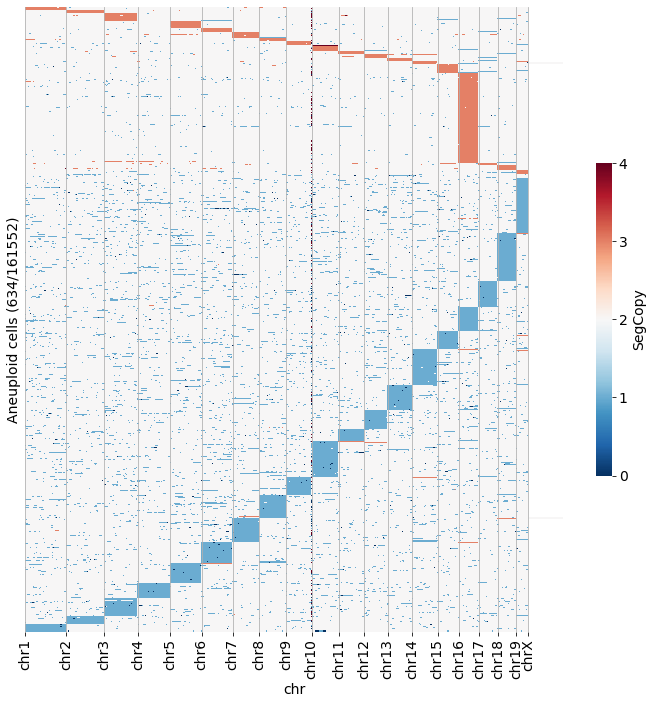

In [338]:
plt.figure(figsize=(10,10))
ix = pd.IndexSlice
df_show = segcopy.loc[:,ix[:,cells_order]].T[chroms]
male = df_show[~df_show.index.get_level_values('sample').str.contains('.*_RS2_*[A-Z]f[0-9].*',regex=True)].index
df_show.loc[male,'chrX'] *=2
df_show.columns = df_show.columns.droplevel(1)
# df_show = df_show.div(df_show.median(axis=1),axis=0)*2

sns.heatmap(df_show,vmin=0,vmax=4,
           cmap='RdBu_r',
           yticklabels=False,
           cbar_kws={'shrink':0.5,'label':'SegCopy','ticks':[0,1,2,3,4]},
           center=2)
plt.xticks(np.where(~df_show.columns.duplicated())[0], labels=df_show.columns[~df_show.columns.duplicated()]);
plt.ylabel('Aneuploid cells (%d/%d)' % (df_show.shape[0],tot_cells))
plt.grid(True, axis='x')
plt.savefig('Plots/CEMBA_SegCopy_Heatmap.png',dpi=300)

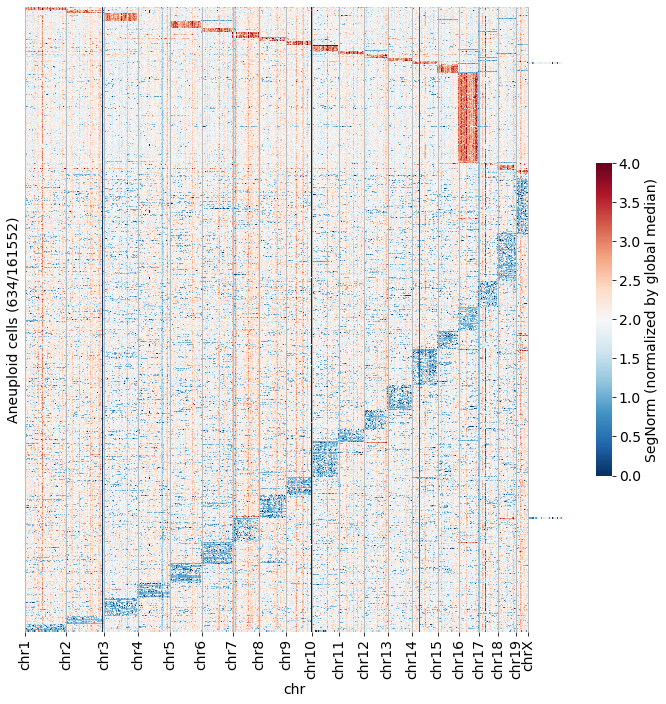

In [340]:
ix = pd.IndexSlice
df_show = segnorm.loc[:,ix[:,cells_order]].T[chroms]
male = df_show[~df_show.index.get_level_values('sample').str.contains('.*_RS2_*[A-Z]f[0-9].*',regex=True)].index
df_show.loc[male,'chrX'] *=2
df_show.columns = df_show.columns.droplevel(1)
df_show = df_show.div(df_show.median(axis=1),axis=0)*2

plt.figure(figsize=(10,10))
sns.heatmap(df_show,vmin=0,vmax=4,
           cmap='RdBu_r',
           yticklabels=False,
           cbar_kws={'shrink':0.5,'label':'SegNorm (normalized by global median)'},
           center=2)
plt.xticks(np.where(~df_show.columns.duplicated())[0], labels=df_show.columns[~df_show.columns.duplicated()]);
plt.ylabel('Aneuploid cells (%d/%d)' % (df_show.shape[0],tot_cells))
plt.grid(True, axis='x')
plt.savefig('Plots/CEMBA_SegNorm_Heatmap.png',dpi=300)

# Load mC data for aneuploid cells

In [397]:
# Helper functions for plotting
def sort_by_chromnum(df,chrom='CHR',pos='START'):
    df['chr_num'] = [i.strip('chr').replace('X','100') for i in df[chrom]]
    df['chr_num'] = df['chr_num'].astype(int)
    df = df.sort_values(['chr_num',pos]).drop(columns='chr_num')
    return df

def resample_bins(df,binsize,normalize=False):
    df = df.reset_index()
    df['bin']=np.floor(df['bin']/binsize)*binsize
    if normalize:
        df=df.groupby(['chr','bin']).mean()
    else:
        df=df.groupby(['chr','bin']).sum()
    return df

def run_load_mc(sample,df,ctxts=['CH','CG','CA']):
    cells = df.loc[df['sample']==sample,'cell']
    cells = [cell.replace('.','-').strip('X') for cell in cells]
    cols_mc=[f'm{i}_{cell}' for cell in cells for i in ctxts]
    cols_h=[f'{i}_{cell}' for cell in cells for i in ctxts]
    
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_data2/%s' % sample
    mc_h=pd.read_csv(f'{sampledir}/binc_{sample}_1000kb.tsv.gz',
                     sep='\t',usecols=['chr','bin']+cols_mc+cols_h,
                     index_col=['chr','bin'],
                     dtype={'chr':str,'bin':int})
    mc = mc_h[cols_mc]
    h = mc_h[cols_h]
    return mc,h
    
def load_mc(df,hthresh=100,
            ctxts=['CH','CG','CA'],
            binsize=None,):
    t0=time.time()
    samples=df['sample'].unique()
    with Pool() as p:
        mc_h = p.starmap(run_load_mc, zip(samples,
                                [df for i in range(len(samples))],
                                [ctxts for j in range(len(samples))]
                               )
                        )
    mc = [i[0] for i in mc_h]
    h = [i[1] for i in mc_h]
    mc = mc[0].join(mc[1:])
    h = h[0].join(h[1:])
    if binsize is not None:
        mc = resample_bins(mc,binsize)
        h = resample_bins(h,binsize)
    mc=mc.reset_index()
    mc['chr']='chr'+mc['chr']
    mc['bin']=mc['bin'].astype(int)
    mc=mc.set_index(['chr','bin'])
    h=h.reset_index()
    h['chr']='chr'+h['chr']
    h['bin']=h['bin'].astype(int)
    h=h.set_index(['chr','bin'])

    mc = mc.rename(columns=lambda x: re.sub('^mC','C',x))
    ml = mc / h
    return ml,mc,h

In [410]:
%%time
ml,mc,h=load_mc(cellsu,binsize=1e6)

# Remove bad bins
ml = ml.drop(index=badbins.index)
mc = mc.drop(index=badbins.index)
h = h.drop(index=badbins.index)

CPU times: user 1.07 s, sys: 1.02 s, total: 2.09 s
Wall time: 11.5 s


In [452]:
df_show

CG_CEMBA190423-10A-1-CEMBA190423-10A-2-E12_ad001  \
chr  bin                                                           
chr1 5000000                                            0.713592   
     6000000                                            0.770667   
     7000000                                            0.732365   
     8000000                                            0.712963   
     9000000                                            0.653409   
...                                                          ...   
chrX 166000000                                          0.785965   
     167000000                                          0.708000   
     168000000                                          0.653153   
     170000000                                          0.721519   
     171000000                                               NaN   

                CG_CEMBA190423-10A-3-CEMBA190423-10A-4-B12_ad010  \
chr  bin                                                           
chr1 5000000                                            0.640264   
     6000000                                            0.756813   
     7000000                                            0.754237   
     8000000                                            0.866221   
     9000000                                            0.745665   
...                                                          ...   
chrX 166000000                                          0.759425   
     167000000                                          0.751196   
     168000000                                          0.717262   
     170000000                                          0.441176   
     171000000                                               NaN   

                CG_CEMBA190423-10A-3-CEMBA190423-10A-4-D12_ad004  \
chr  bin                                                           
chr1 5000000                                            0.670669   
     6000000                                            0.632168   
     7000000                                            0.753145   
     8000000                                            0.710583   
     9000000                                            0.625832   
...                                                          ...   
chrX 166000000                                          0.734247   
     167000000                                          0.697509   
     168000000                                          0.718367   
     170000000                                          0.794872   
     171000000                                               NaN   

                CG_CEMBA190525-10A-1-CEMBA190525-10A-2-C12_ad010  \
chr  bin                                                           
chr1 5000000                                            0.711799   
     6000000                                            0.780731   
     7000000                                            0.747573   
     8000000                                            0.800539   
     9000000                                            0.685786   
...                                                          ...   
chrX 166000000                                          0.811280   
     167000000                                          0.846608   
     168000000                                          0.748571   
     170000000                                          0.761905   
     171000000                                               NaN   

                CG_CEMBA190525-10A-1-CEMBA190525-10A-2-D12_ad001  \
chr  bin                                                           
chr1 5000000                                            0.777188   
     6000000                                            0.721022   
     7000000                                            0.787763   
     8000000                                            0.785553   
     9000000                                            0.724199   


In [460]:
mlu = pd.concat({'CG': ml.filter(like='CG_').rename(columns=lambda x: x.replace('CG_','')),
                 'CH': ml.filter(like='CH_').rename(columns=lambda x: x.replace('CH_','')),
                 'CA': ml.filter(like='CA_').rename(columns=lambda x: x.replace('CA_',''))},axis=0).T
mlu.index = samples2cells(mlu.index)
cells_orderu = [i.strip('X') for i in cells_order]

In [465]:
df_show = mlu['CG'].loc[cells_orderu]
df_show
# mlu['CG']

chr                                                chr1                      \
bin                                           5000000   6000000   7000000     
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     0.694199  0.714958  0.817143   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     0.896930  0.840868  0.927152   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006   0.777143  0.697422  0.833102   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007   0.785965  0.752857  0.861852   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004     0.817204  0.872093  0.860215   
...                                                 ...       ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001     0.733333  0.625000  0.823308   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002   0.801724  0.863454  0.861345   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  0.809524  0.822222  0.865997   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004  0.846154  0.907692  0.913043   
3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012  0.784314  0.878378  0.808511   

chr                                                                          \
bin                                           8000000   9000000   10000000    
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     0.854410  0.670695  0.794613   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     0.976321  0.789916  0.940226   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006   0.861157  0.720693  0.793631   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007   0.849903  0.656136  0.705234   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004     0.921429  0.824645  0.809045   
...                                                 ...       ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001     0.870523  0.846608  0.750000   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002   0.909722  0.672241  0.819712   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  0.859008  0.773196  0.533333   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004  0.896552  0.676856  0.805556   
3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012  0.900000  0.867188  0.747423   

chr                                                                          \
bin                                           11000000  12000000  13000000    
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     0.806650  0.782774  0.760443   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     0.928854  0.926897  0.783650   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006   0.852375  0.809372  0.734568   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007   0.829982  0.796448  0.795181   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004     0.956044  0.908333  0.792763   
...                                                 ...       ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001     0.810345  0.860656  0.824593   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002   0.917864  0.848333  0.831814   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  0.912281  0.838710  0.718182   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004  0.906040  0.953917  0.863946   
3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012  0.856522  0.900990  0.794595   

chr                                                      ...      chrX  \
bin                                           14000000   ... 161000000   
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     0.784014  ...  0.797101   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     0.897616  ...  0.879781   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006   0.782110  ...  0.847751   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007   0.835762  ...  0.767327   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004     0.853333  ...  0.855072   
...                                                 ...  ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001     0.776995  ...  0.702564   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002   0.807267  ...  0.806950   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  0.681818  ...  0.723647   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004  0.926702  ...  0.820000   
3B.CEMBA180312.3B.3.CEMBA180

In [509]:
df_show.div(df_show.median(axis=1),axis=0)

chr                                                chr1      chr1      chr1  \
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     0.610412  1.056627  0.605554   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     0.861924  1.018635  0.848999   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006   0.904992  0.849980  0.702607   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007   0.740968  0.877961  0.777493   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004     0.978971  1.550115  0.856139   
...                                                 ...       ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001     1.182613  0.781302  0.784674   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002   0.578455  1.165810  0.672923   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  0.553213  0.682185  0.560362   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004  0.745369  0.979751  0.721250   
3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012  0.813342  1.292953  0.846645   

chr                                                chr1      chr1      chr1  \
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     0.663067  0.756005  0.682130   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     0.849971  0.919118  0.979722   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006   0.755486  0.827057  0.696406   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007   0.686099  0.879423  0.746767   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004     2.047069  1.895545  1.427352   
...                                                 ...       ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001     0.580164  0.879615  0.000000   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002   0.618916  0.937739  0.884680   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  1.927958  4.337354  6.057773   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004  0.796389  0.774222  0.860742   
3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012  0.806123  0.818185  0.728787   

chr                                                 chr1      chr1      chr1  \
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004      0.687850  1.139372  0.968005   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001      1.000859  1.226769  0.842533   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006    0.870316  1.104630  1.004470   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007    0.872649  1.083298  0.987401   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004      2.790753  0.759929  0.758759   
...                                                  ...       ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001      2.919131  1.340532  0.950332   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002    0.975527  1.252040  1.066570   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  17.035543  0.673869  1.306648   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004   0.922246  0.892307  1.073410   
3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012   0.783857  1.029521  0.976800   

chr                                                chr1  ...      chrX  \
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     1.363196  ...  0.907494   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     1.162299  ...  0.901242   
CEMBA190305.11F.1.CEMBA190305.11F.2.D7_ad006   1.248585  ...  1.311378   
CEMBA190305.11F.1.CEMBA190305.11F.2.E4_ad007   1.474118  ...  1.583470   
CEMBA180910.5J.1.CEMBA180910.5J.2.E4_ad004     0.836371  ...  0.355189   
...                                                 ...  ...       ...   
CEMBA190219.9J.3.CEMBA190219.9J.4.H6_ad001     1.264976  ...  1.207114   
CEMBA190325.12B.1.CEMBA190325.12B.2.F4_ad002   1.257658  ...  1.309416   
CEMBA190627.10F.1.CEMBA190627.10F.2.E11_ad007  1.824495  ...  1.020490   
3E.CEMBA180326.3E.3.CEMBA180326.3E.4.G7_ad004  1.383802  ...  1.531409   
3B.CEMBA180312.3B.3.CEMBA180312.3B.4.G4_ad012  1.358362  ...  1.443823   

chr                                                chrX      chrX      chrX  \
CEMBA180430.8B.1.CEMBA180430.8B.2.B3_ad004     1.518188  1.515458  1.192913   
CEMBA181206.5E.3.CEMBA181206.5E.4.B9_ad001     0.655712  0.961911  1.219716   
CEMBA190305.11F

In [516]:
ax.set_x

<AxesSubplot:xlabel='chr'>

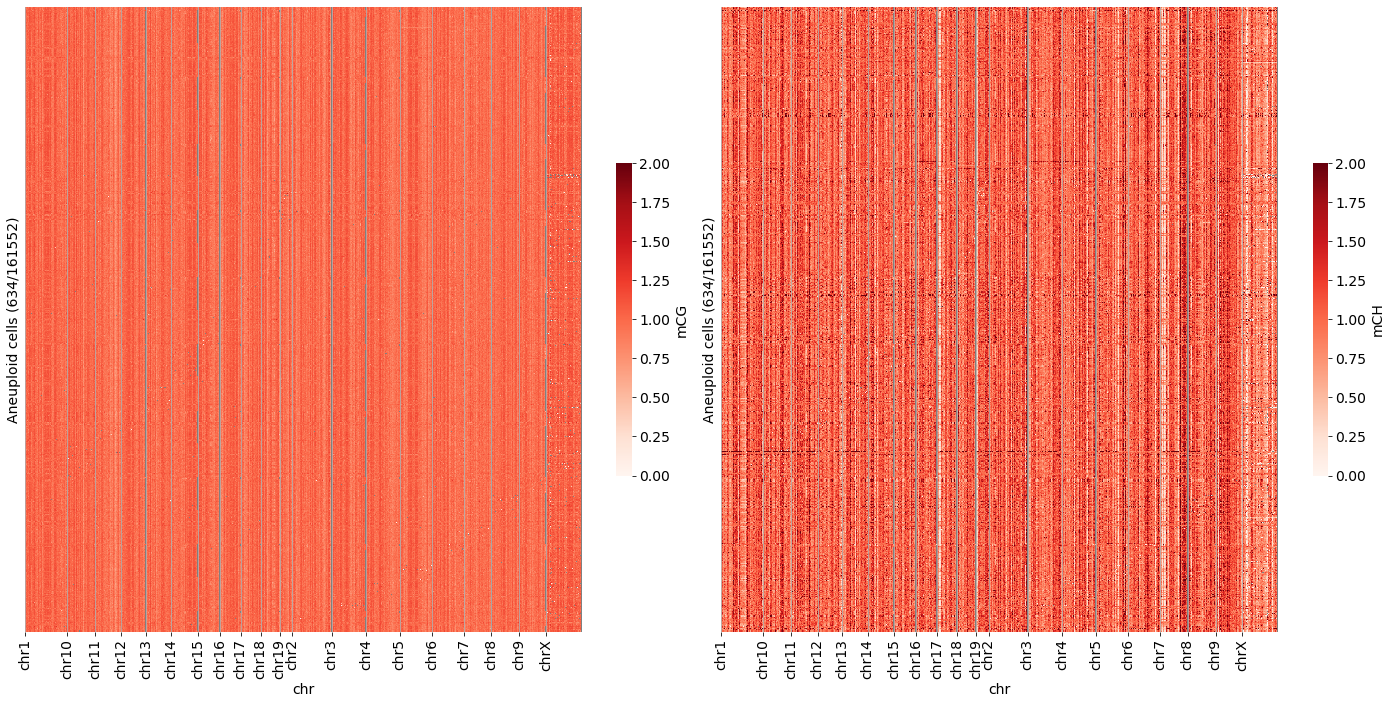

In [520]:
import copy
cmap = copy.copy(plt.cm.Reds)
cmap.set_bad('gray')

fig,axs=plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
for ax,ctxt in zip(axs,['CG','CH']):
    df_show = mlu[ctxt].loc[cells_orderu]
    df_show.columns=df_show.columns.droplevel('bin')
    df_show = df_show.div(df_show.median(axis=1),axis=0)
#     vminmax=df_show.quantile([.01,.99],axis=1).mean()
    sns.heatmap(df_show,
                vmin=0,vmax=2,center=1,
                cmap=cmap,
                yticklabels=False,xticklabels=False,
                cbar_kws={'shrink':0.5,'label':f'm{ctxt}'},
                ax=ax,
               )
    ax.set_xticks(np.where(~df_show.columns.duplicated())[0], );
    ax.set_xticklabels(labels=df_show.columns[~df_show.columns.duplicated()],rotation=90)
    ax.set_ylabel('Aneuploid cells (%d/%d)' % (df_show.shape[0],tot_cells))
    ax.grid(True, axis='x')
plt.savefig('Plots/CEMBA_mCG_mCH_Heatmap.png',dpi=300)

In [ ]:
mcg_show = mlu['CG'].loc[cells_orderu].T
mch_show = mlu['CH'].loc[cells_orderu].T
segcopy_show = segcopy.copy().astype(int)
segcopy_show.columns=segcopy_show.columns.droplevel('sample')
# segcopy_show.columns=samples2cells(segcopy_show.columns)
# ml_show.columns=samples2cells(ml_show.columns)

a,b=ml_show.align(segcopy_show,join='inner')

segcopy_show = segcopy_show.stack()
mcg_show = mcg_show.stack()
mch_show = mch_show.stack()

In [610]:
df_show = pd.concat((segcopy_show,mcg_show,mch_show),axis=1, names=['SegCopy','mCG','mCH'])
df_show.columns=['SegCopy','mCG','mCH']

In [613]:
df_show.index.names=['chr','bin','cell']

In [614]:
# sns.boxplot(data=df_show,x='SegCopy',y='mCH')
df_show['ploidy'] = df_show['SegCopy']
df_show.loc[df_show['SegCopy']>3,'ploidy'] = 'Hyper >3'
df_show.loc[df_show['SegCopy']==2,'ploidy'] = 'Euploid (2)'
df_show.loc[df_show['SegCopy']<2,'ploidy'] = 'Hypo ('+df_show.loc[df_show['SegCopy']<2,'ploidy'].astype(int).astype(str)+')'
df_show.loc[df_show['SegCopy']==3,'ploidy'] = 'Hyper (3)'
df_show.loc[('chr16',(df_show['SegCopy']==3)),'ploidy'] = 'T16'
df_show['ploidy'].unique()

array([nan, 'Euploid (2)', 'Hypo (1)', 'Hyper (3)', 'Hypo (0)',
       'Hyper >3', 'T16'], dtype=object)

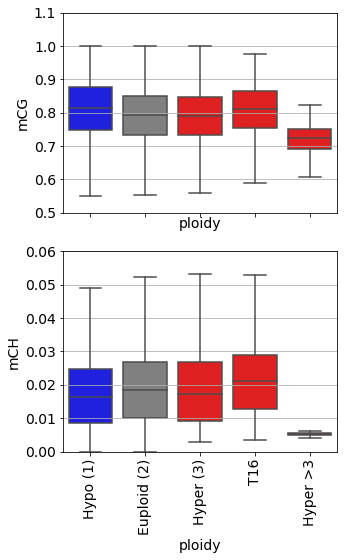

In [625]:
# Box plot of mCG and mCH level vs. ploidy
fig,axs=plt.subplots(2,1,sharex=True,sharey=False,figsize=(5,8))
for ax,ctxt,ylims in zip(axs,['CG','CH'],[(0.5,1.1),(0,.06)]):
    sns.boxplot(data=df_show,
                x='ploidy',y=f'm{ctxt}',
                fliersize=0,
                order=['Hypo (1)','Euploid (2)', 'Hyper (3)', 'T16', 'Hyper >3'],
                palette={'Hypo (1)':'b','Euploid (2)':'gray', 'Hyper (3)':'r', 'T16':'r', 'Hyper >3':'r'},
                ax=ax,
               )
    ax.set_ylim(ylims)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y')
plt.savefig('Plots/CEMBA_mCG_mCH_boxplot_vs_ploidy.pdf')

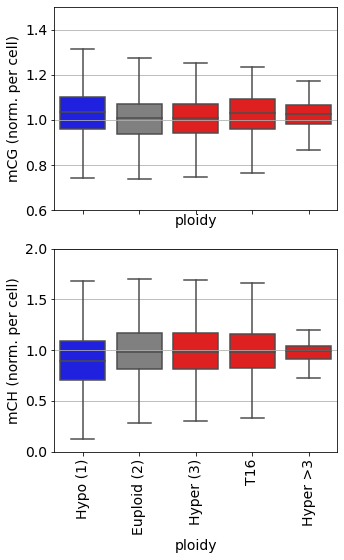

In [624]:
# Normalize by each cell's euploid mC level
mc_euploid = df_show[df_show['SegCopy']==2].groupby('cell')[['mCG','mCH']].mean()
df_show_norm = df_show.copy()
df_show_norm[['mCG (norm. per cell)','mCH (norm. per cell)']] = df_show[['mCG','mCH']] / mc_euploid

# Box plot of mCG and mCH level vs. ploidy
fig,axs=plt.subplots(2,1,sharex=True,sharey=False,figsize=(5,8))
for ax,ctxt,ylims in zip(axs,['CG','CH'],[(0.6,1.5),(0,2)]):
    sns.boxplot(data=df_show_norm,
                x='ploidy',y=f'm{ctxt} (norm. per cell)',
                fliersize=0,
                order=['Hypo (1)','Euploid (2)', 'Hyper (3)', 'T16', 'Hyper >3'],
                palette={'Hypo (1)':'b','Euploid (2)':'gray', 'Hyper (3)':'r', 'T16':'r', 'Hyper >3':'r'},
                ax=ax,
               )
    ax.set_ylim(ylims)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y')
plt.savefig('Plots/CEMBA_mCG_mCH_normalized_boxplot_vs_ploidy.pdf')

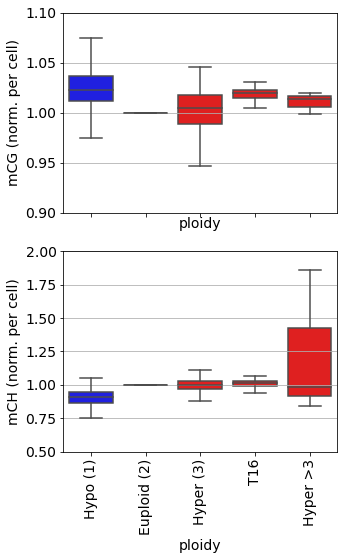

In [633]:
df_show_norm_cellmean = df_show_norm.groupby(['cell','ploidy'])[['mCG (norm. per cell)','mCH (norm. per cell)']].mean().dropna()
df_show_norm_cellmean = df_show_norm_cellmean.reset_index('ploidy')

# Box plot of mCG and mCH level vs. ploidy
fig,axs=plt.subplots(2,1,sharex=True,sharey=False,figsize=(5,8))
for ax,ctxt,ylims in zip(axs,['CG','CH'],[(0.9,1.1),(0.5,2)]):
    sns.boxplot(data=df_show_norm_cellmean,
                x='ploidy',y=f'm{ctxt} (norm. per cell)',
                fliersize=0,
                order=['Hypo (1)','Euploid (2)', 'Hyper (3)', 'T16', 'Hyper >3'],
                palette={'Hypo (1)':'b','Euploid (2)':'gray', 'Hyper (3)':'r', 'T16':'r', 'Hyper >3':'r'},
                ax=ax,
               )
    ax.set_ylim(ylims)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y')
plt.savefig('Plots/CEMBA_mCG_mCH_normalized_CellMean_boxplot_vs_ploidy.pdf')

In [416]:
def mC_plot(df,ax,sample='',cell=''):
    # Plot the segnorm and segcopy information for a cell
    dfr = df.reset_index()
    xtu,xt = np.unique(dfr['chr'],return_index=True)
    xt = np.sort(xt)
    xtu = dfr.iloc[xt,:]['chr']

    yt=[0,np.max(df.values[df.values<1])*1.1]
    plt.sca(ax)
    zebra_stripes(xt,yt)
    plt.plot(df.values,'.',markersize=1)
    plt.xticks(xt,labels=xtu);
    plt.text(plt.xlim()[0],0,'%s\n%s'%(sample.replace('CEMBA_',''), cell),fontdict={'size':7},
            )
    plt.ylim(yt)

def mC_plots(cells=[], df=None):
    # Make a combined plot for many cells
    t0=time.time()
    if df is None:
        ncells = cells.shape[0]
        print('Loading data for %d samples; ' % ncells)
        df=load_mc(cells,hthresh=10,ctxts=['CG'])
    else:
        ncells = df.shape[1]
    
    # Make the plots
    nrows = np.min([ncells,10])
    ncols = np.ceil(ncells/nrows).astype(int)
    fig,axs=plt.subplots(nrows,ncols,figsize=(20,1.5*nrows),sharex=True,sharey=False)
    axs=axs.flatten()
    for i,sample_cell in enumerate(df):
        sample,cell = sample_cell.split(' ')
        mC_plot(df.loc[:,sample_cell],axs[i],sample=sample,cell=cell)
    axs[0].set_ylabel('Copy number')
    axs[0].set_title('Aneuploidies on %s: %d cells' % (chrom,dfu.shape[0]))
    return fig,axs

ValueError: not enough values to unpack (expected 2, got 1)

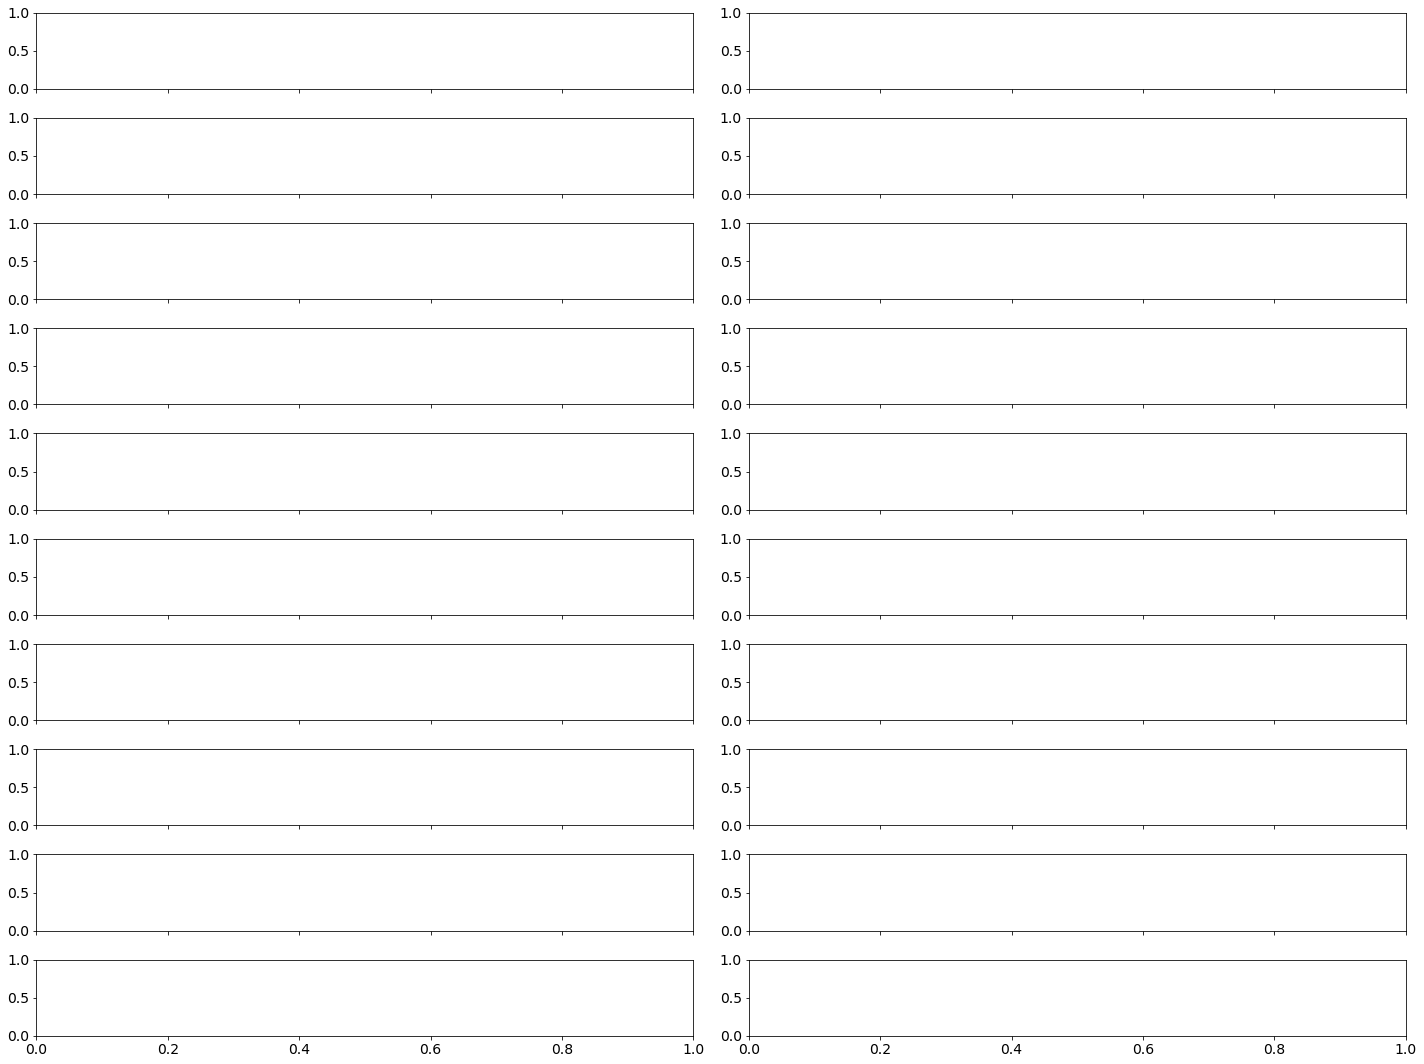

In [417]:
x=mC_plots(df=ml.iloc[:,:20])

In [ ]:
sample='sdlfkj_RS2_sdlkfj.'
re.match(r'.*_RS2_.*',sample) is None

In [ ]:
ginkgo_list

In [ ]:
segcopy_mean_dfs = []
for sampledir in ginkgo_list:
    try:
        sample = re.search('ginkgo_1000kb/CEMBA_(.*)$',sampledir).group(1)

        segnorm = pd.read_csv(sampledir+'/SegNorm.gz', 
                           sep='\t',
                          )
        segnorm = segnorm.drop(columns='END').set_index(['CHR','START'])
        segcopy = pd.read_csv(sampledir+'/SegCopy.gz', 
                           sep='\t',
                          )
        segcopy = segcopy.drop(columns='END').set_index(['CHR','START'])

        i = np.argsort(segnorm.std(axis=0))[::-1]
        segnorm = segnorm.iloc[:,i]
        segcopy = segcopy.iloc[:,i]

        bins = segnorm.index.to_frame()
        _,bins['chr_num'] = np.unique(bins['CHR'],return_inverse=True)

        # Filter bad bins
        thresh = 0.5
        goodbins = ((segnorm.mean(axis=1)*1>thresh) & (bins['CHR']!="chrX")) | ((segnorm.mean(axis=1)*2>thresh) & (bins['CHR']=='chrX'))
        print('Keeping %3.3f%% of bins with normalized signal>%3.3f' % (100*np.mean(goodbins),thresh))

        segnorm = segnorm.loc[goodbins,:]
        segcopy = segcopy.loc[goodbins,:]

        # Group by chromosome
    #     segnorm_mean = segnorm.groupby('CHR').mean()
    #     segnorm_std = segnorm.groupby('CHR').std()
        segcopy_mean = segcopy.groupby('CHR').mean()
    #     segcopy_std = segcopy.groupby('CHR').std()

        segcopy_mean_dfs.append(segcopy_mean)
        print('Finished loading %s' % sample)
    except:
        print('Failed to load %s' % sampledir)

In [ ]:
# Group by chromosome
segnorm_mean = segnorm.groupby('CHR').mean()
segnorm_std = segnorm.groupby('CHR').std()
segcopy_mean = segcopy.groupby('CHR').mean()
segcopy_std = segcopy.groupby('CHR').std()

In [ ]:
# Load Ginkgo results for a set of cells
datadir='/cndd2/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/'
ginkgo_list = glob.glob(datadir+'/CEMBA*')

In [ ]:
plt.figure(figsize=(20,3))
plt.pcolormesh(segcopy_mean.iloc[:,:200],
               vmin=1,vmax=3,
               cmap='RdBu_r'
              )

In [ ]:
# plt.boxplot(segnorm_mean, labels=segnorm_mean.index, showfliers=False);
segnorm_mean.T.boxplot(showfliers=False,grid=False)
plt.xticks(rotation=90);


In [ ]:
# plt.plot(segcopy_mean, segcopy_std, '.');
plt.loglog(segnorm_mean, segnorm_std, '.');

In [ ]:
bins = segnorm.index.to_frame()
_,bins['chr_num'] = np.unique(bins['CHR'],return_inverse=True)
xt = np.where(np.diff(bins['chr_num']))[0]
xt = np.insert(xt,0,0)
xtl = bins['CHR'].iloc[xt+1].values

In [ ]:
plt.figure(figsize=(25,3))
plt.plot(np.arange(segnorm.shape[0]),2*segnorm.mean(axis=1),'k.',markersize=0.5)
plt.scatter(np.arange(segcopy.shape[0]),segcopy.mean(axis=1),
            s=2,c=bins['chr_num'],
           cmap='prism')
plt.xticks(xt, xtl)
plt.grid(axis='x')
plt.axis('tight')
plt.ylim([0,4])
plt.xlim([0,segnorm.shape[0]])
plt.title(sample)
plt.ylabel('Copy number')

In [ ]:
nshow = 200;
plt.figure(figsize=(25,8*nshow/100))
plt.pcolormesh(segcopy.iloc[:,:nshow].T,
              vmin=0,vmax=4,
              cmap='RdBu_r');
plt.xticks(xt, xtl)
plt.grid(axis='x')
plt.colorbar(label='Normalized signal')

In [ ]:
data.index.get_level_values('START')

# ####

In [ ]:
y,x=np.histogram(cells_df['CNV total length per cell'].values,bins=np.arange(0,3e9,1e7),)

In [ ]:
hist_bins=np.arange(0,3e9,1e7)
def my_hist(x):
    y=np.histogram(x,bins=hist_bins)[0]
    y=pd.Series(y,index=hist_bins[:-1])
    return y

cnv_length_hists=pd.DataFrame(index=ginkgo_list,columns=hist_bins)
for sample in tqdm(ginkgo_list):
    if sample in cells_df.index:
        cnv_length_hists.loc[sample] = my_hist(cells_df.loc[sample,'CNV total length per cell'])
    
# cnv_length_hists = cells_df['CNV total length per cell'].groupby('sample').agg(my_hist)

In [ ]:
# Histogram of CNV length
plt.plot(hist_bins, cnv_length_hists.sum(axis=0), color='k');
tot_cells=all_samples['ncells'].sum()
plt.ylabel(f'Num. cells (out of N={tot_cells})')
plt.xlabel(f'Total CNV length per cell (bp)')
plt.title(f'CNV length≥{(min_cnv_length/1e6)} Mbp')
plt.grid()
# plt.ylim([0,2000])
plt.yscale('log')
plt.savefig('CEMBA_CNV_totlength_histogram.pdf')

In [ ]:
# cnv_length_hists_u = 
# all_samples['ncells'].plot(kind='hist')
big_samples = all_samples[all_samples['ncells']>500]['sample']
dfu = cnv_length_hists.loc[big_samples]
# Normalize each cell by the number of cells in that sample
dfu = dfu.div(all_samples[all_samples['ncells']>500].set_index('sample')['ncells'],axis=0)

In [ ]:
dfu_cumsum=dfu.sort_index(axis=1,ascending=False).cumsum(axis=1)
dfu_cumsum=dfu_cumsum.sort_index(axis=1,ascending=True)

In [ ]:
plt.errorbar(hist_bins, dfu_cumsum.mean(axis=0), dfu_cumsum.std(axis=0),
            errorevery=5)
plt.ylabel(f'Cum. fraction of cells per sample\nwith CNVs <X')
plt.xlabel('X=Total CNV length per cell (bp)')
plt.ylim([0,.2])
plt.savefig('CEMBA_CNV_totlength_FracCells_histogram.pdf')

In [ ]:
sns.scatterplot(data=cells_df,x='Reads',y='CNV total length per cell',
                hue='Std',
                edgecolor=None,s=3)
plt.xscale('log')

In [ ]:
cells_df['Num. CNV chromosomes'].plot(kind='hist',bins=np.arange(23))
plt.xlabel('Number of chromosomes with a CNV')
plt.ylabel(f'Cells (out of {tot_cells})')
plt.savefig('Plots/CEMBA_CNV_nchroms_hist.pdf')

In [ ]:
# sns.pairplot(cells_df,x_vars=['Reads'],y_vars=['CNV total length per cell',])
sns.violinplot(data=cells_df,x='Reads',y='Num. CNV chromosomes')

In [ ]:
plt.plot(hist_bins, cnv_length_hists.values.T, color='gray');
plt.plot(hist_bins, cnv_length_hists.mean(axis=0), color='k');
plt.ylim([0,100])


In [ ]:
cnv_length_hists

In [ ]:
cells_df.sample(100).groupby('sample')['CNV total length per cell'].hist()

In [ ]:
# Total length of CNVs per cell
sns.displot(data=cells_df,x='CNV total length per cell',hue='sample')

In [ ]:
# Quality control: 
sns.scatterplot(data=cells_df, x='Reads', y='MAD', linewidth=0)

In [ ]:
# Relative ploidy
euploid = cells_df[['ploidy']].copy()
euploid.loc[:,'ploidy'] = 2
euploid.loc[(cells_df['chr']=='chrX') & (cells_df['sex']=='m'),'ploidy'] = 1
cells_df['Relative ploidy'] = 'euploid'
cells_df.loc[(cells_df['ploidy']>euploid['ploidy']), 'Relative ploidy'] = 'duplication (non-chr16)'
cells_df.loc[(cells_df['ploidy']<euploid['ploidy']), 'Relative ploidy'] = 'deletion'
cells_df.loc[(cells_df['chr']=='chr16') & (cells_df['ploidy']==3), 'Relative ploidy'] = 'T16'
cells_df['Relative ploidy'].value_counts()

In [ ]:
cells_df.iloc[0]

In [ ]:
# cells_df['NonAneuploid_CNV_length'].hist(by=cells_df['Relative ploidy'])
sns.boxplot(data=cells_df,x='Relative ploidy',y='NonAneuploid_CNV_length')
plt.yscale('log')

In [ ]:
chroms= ['chr%d'%(i+1) for i in range(19)]+['chrX']
sns.countplot(data=cells_df,x='chr',hue='Relative ploidy',order=chroms)
plt.xticks(rotation=90);
plt.grid(True,axis='y')
plt.ylabel('Number of cells')
plt.savefig(plotsdir+'/NumAneuploid_PerChrom_barplot_%s.pdf' % (today))

In [ ]:
cells_df.columns

In [ ]:
plt.figure(figsize=(5,6))
sns.countplot(data=cells_df.loc[cells_df['Relative ploidy']=='T16'],x='sample',hue='Relative ploidy')
plt.xticks(rotation=90)
plt.grid(True,axis='y')

# Distribution of cell types

In [ ]:
def samples2cells(samples):
    # Convert sample names (e.g. 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_....) to cell names
    # (e.g. CEMBA171206.3C.1.CEMBA171206.3C.3.A10_ad001)
    cells = samples
    cells = [re.sub(r'^X?[0-9]{6}_CEMBA_mm_P56_P63_',r'',i) for i in cells]
    cells = [re.sub(r'.indexed[.]?',r'',i) for i in cells]
    cells = [re.sub(r'[_-]',r'.',i) for i in cells]
    cells = [re.sub(r'\.(AD|ad)([0-9]+)$',r'_ad\2',i) for i in cells]
    return cells

In [ ]:
cells_df.shape

In [ ]:
cell_clusters['cluster_annotation'] = ''

In [ ]:
cells_df

In [ ]:
cell_clusters['cell'] = samples2cells(cell_clusters['sample'])
cell_clusters['cluster'] = cell_clusters['cluster_annotation']+' '+cell_clusters['cluster_ID']
cell_clusters['cluster'] = [re.sub(r'^NA \((.*)\)',r'\1',i).replace('cluster_','C').strip('m') for i in cell_clusters['cluster']]
cells_df3 = cells_df.merge(cell_clusters[['cell','cluster','CellClass', 'MajorType', 'SubType','MajorRegion', 'SubRegion', 'DissectionRegion',
                                         'l1-umap_0', 'l1-umap_1','l2-umap_0', 'l2-umap_1','l3-umap_0', 'l3-umap_1']],on='cell',
                          how='left')
# cells_df3 = cells_df.merge(cell_clusters,on='cell',
#                           how='left')

In [ ]:
cells_df3['sample']

In [ ]:
cell_clustersu = cell_clusters.sample(n=20000)

# for embedding in ['l1-umap','l2-umap','l3-umap']:
embedding = 'l1-umap'

fig,axs=plt.subplots(2,1,figsize=(8,12))
plt.sca(axs[0])
plt.scatter(cell_clustersu[embedding+'_0'],cell_clustersu[embedding+'_1'],s=2,c='gray')
sns.scatterplot(data=cells_df3,x=embedding+'_0',y=embedding+'_1',hue='Relative ploidy',
               palette='bright',
               ax=axs[0])
plt.xticks([])
plt.yticks([]);
plt.legend(bbox_to_anchor=(1,.5))

plt.sca(axs[1])
# plt.scatter(cell_clustersu[embedding+'_0'],cell_clustersu[embedding+'_1'],s=1,c='gray')
sns.scatterplot(data=cell_clustersu,
                x=embedding+'_0',y=embedding+'_1',
                hue='MajorType',
                size=1,
                linewidth=0,
#                 palette='bright',
                ax=axs[1],
                legend=False
               )
cluster_centroids = cell_clusters.groupby('MajorType')[[embedding+'_0',embedding+'_1']].mean()
for i,c in cluster_centroids.iterrows():
    plt.text(c[embedding+'_0'],c[embedding+'_1'],i,horizontalalignment='center')
plt.xticks([])
plt.yticks([]);
plt.legend(bbox_to_anchor=(1,.5))
plt.savefig(plotsdir+'/Embedding_%s_AneuploidCells_scatterplot_%s.pdf' % (embedding,today))

In [ ]:
cells_df3.columns

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(20,10),sharex=False,sharey=True)
axs=axs.reshape(-1,1).squeeze()
for i,grouping in enumerate(['SubType','MajorType','MajorRegion','SubRegion']):
    plt.sca(axs[i])
    sns.countplot(data=cells_df3,x=grouping,hue='Relative ploidy',ax=axs[i])
    plt.xticks(rotation=90)
    plt.grid(True,axis='y')
    plt.legend(bbox_to_anchor=(1,.5))
plt.savefig(plotsdir+'/Countplot_AneuploidCells_%s.pdf' % (today))

In [ ]:
# for embedding in ['l1-umap','l2-umap','l3-umap']:
cell_clustersu = cell_clusters
embedding = 'l3-umap'
typeshow='DG'
cell_clustersuu = cell_clustersu.loc[cell_clustersu['MajorType']==typeshow]
cells_df3u = cells_df3.loc[cells_df3['MajorType']==typeshow]

fig,axs=plt.subplots(2,1,figsize=(8,12))
plt.sca(axs[0])
plt.scatter(cell_clustersuu[embedding+'_0'],cell_clustersuu[embedding+'_1'],s=2,c='gray')
sns.scatterplot(data=cells_df3u,x=embedding+'_0',y=embedding+'_1',hue='Relative ploidy',
               palette='bright',
                hue_order=['hypoploid','hyperploid','T16'],
               ax=axs[0])
plt.xticks([])
plt.yticks([]);
plt.legend(bbox_to_anchor=(1,.5))

plt.sca(axs[1])
# plt.scatter(cell_clustersu[embedding+'_0'],cell_clustersu[embedding+'_1'],s=1,c='gray')
sns.scatterplot(data=cell_clustersuu,
                x=embedding+'_0',y=embedding+'_1',
                hue='MajorType',
                size=1,
                linewidth=0,
#                 palette='bright',
                ax=axs[1],
                legend=False
               )
# cluster_centroids = cell_clusters.groupby('MajorType')[[embedding+'_0',embedding+'_1']].mean()
# for i,c in cluster_centroids.iterrows():
#     plt.text(c[embedding+'_0'],c[embedding+'_1'],i,horizontalalignment='center')
plt.xticks([])
plt.yticks([]);
plt.legend(bbox_to_anchor=(1,.5))
plt.savefig(plotsdir+'/Embedding_%s_AneuploidCells_%s_%s_%s.pdf' % (embedding,typeshow,embedding,today))

In [ ]:
cells_df3.shape, cells_df.shape

In [ ]:
pd.options.display.max_rows=99
cells_df3.loc[cells_df3['Relative ploidy']=='T16']

In [ ]:
plt.figure(figsize=(8,6))
df_plot = cells_df3.loc[cells_df['Relative ploidy']=='T16'].groupby(['sample','SubType'])
# sns.countplot(data=cells_df3.loc[cells_df['Relative ploidy']=='T16'],x='sample',hue='SubType',
#              stacked=True)
df_plot.
plt.xticks(rotation=90)
plt.grid(True,axis='y')
plt.legend(bbox_to_anchor=(1,.5))



In [ ]:
cells_dfu = cells_df3.loc[ (cells_df['Relative ploidy']=='T16')]
plt.figure(figsize=(6,5))

ncells_per_cluster = cell_clusters.groupby('MajorType')['cell'].count()
sns.countplot(data=cells_dfu,x='MajorType',
#               hue='ABA name (based on posterior face of the slice)'
             )
# (cells_dfu.groupby('MajorType')['cell'].count()/ncells_per_cluster).plot(kind='bar')

plt.xticks(rotation=90)
cells_dfu.columns

In [ ]:
from statsmodels.stats.proportion import proportion_confint

fig,axs=plt.subplots(2,1,figsize=(8,8),sharex=True,sharey=True)
for i,grouping in enumerate(['MajorType', 'SubType']):
    plt.sca(axs[i])
    for j,aneuploidy in enumerate(['hyperploid','hypoploid','T16']):
        cells_dfu = cells_df3.loc[cells_df3['Relative ploidy']==aneuploidy]
        aneuploid_percluster = (cells_dfu.groupby(grouping)['cell'].nunique()).to_frame()
        ncell_percluster = cell_clusters.groupby(grouping)['cell'].count()

        aneuploid_percluster = aneuploid_percluster.rename(columns={'cell':'aneuploid'})
        aneuploid_percluster['tot'] = ncell_percluster
        aneuploid_percluster['frac'] = aneuploid_percluster['aneuploid']/ncell_percluster
        aneuploid_percluster['ci_low'],aneuploid_percluster['ci_hi'] = proportion_confint(aneuploid_percluster['aneuploid'], 
                                                                                          aneuploid_percluster['tot'],
                                                                                          method='jeffreys')
        aneuploid_percluster = aneuploid_percluster.sort_values('frac',ascending=False)

        ci=np.stack((aneuploid_percluster['frac']-aneuploid_percluster['ci_low'],
              aneuploid_percluster['ci_hi']-aneuploid_percluster['frac']))
        plt.errorbar(aneuploid_percluster['tot']*(1.02**(j+1)), 100*aneuploid_percluster['frac'], 
                     yerr=100*ci, fmt='o',
                    label=aneuploidy)
        
        tolabel = (aneuploid_percluster['ci_low']>1e-3) & (aneuploid_percluster['tot']>1e3)
        for j,cell in aneuploid_percluster.loc[tolabel].iterrows():
            plt.text(cell['tot']*1.1,100*cell['frac'],j)
    plt.xscale('log')
#     plt.yscale('log')
    plt.grid(True)
    plt.ylabel('% aneuploid cells')
    plt.title('%s' % grouping)
plt.xlabel('Number of cells')
plt.legend(bbox_to_anchor=[1,1])
# plt.xlim([50,1e5])
plt.ylim([1e-3,.5])
plt.savefig(plotsdir+'/FracAneuploid_vs_Total_per_Celltype_%s.pdf' % today)

In [ ]:
from statsmodels.stats.proportion import proportion_confint

cells_dfu = cells_df3.loc[cells_df3['chr']=='chr16']
fig,ax=plt.subplots()
for i,grouping in enumerate(['MajorRegion', 'SubRegion', 'DissectionRegion']):
    aneuploid_percluster = (cells_dfu.groupby(grouping)['cell'].nunique()).to_frame()
    ncell_percluster = cell_clusters.groupby(grouping)['cell'].count()

    aneuploid_percluster = aneuploid_percluster.rename(columns={'cell':'aneuploid'})
    aneuploid_percluster['tot'] = ncell_percluster
    aneuploid_percluster['frac'] = aneuploid_percluster['aneuploid']/ncell_percluster
    aneuploid_percluster['ci_low'],aneuploid_percluster['ci_hi'] = proportion_confint(aneuploid_percluster['aneuploid'], 
                                                                                      aneuploid_percluster['tot'],
                                                                                      method='jeffreys')
    aneuploid_percluster = aneuploid_percluster.sort_values('frac',ascending=False)

    ci=np.stack((aneuploid_percluster['frac']-aneuploid_percluster['ci_low'],
          aneuploid_percluster['ci_hi']-aneuploid_percluster['frac']))
    plt.errorbar(aneuploid_percluster['tot'], 100*aneuploid_percluster['frac'], 
                 yerr=100*ci, fmt='o',
                label=grouping)
    for j,cell in aneuploid_percluster.loc[aneuploid_percluster['ci_low']>1e-3].iterrows():
        plt.text(cell['tot'],100*cell['frac'],j)
plt.xscale('log')
plt.yscale('log')
plt.xlim([50,1e5])
plt.ylim([1e-3,5])
plt.grid(True)
plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('% aneuploid cells')
plt.title('Ploidy=%d\nError bars = 95%% confidence interval' % ploidy_keep)
plt.savefig(plotsdir+'/FracAneuploid_vs_Total_per_Region_Ploidy%d.pdf' % ploidy_keep)

# cell_clusters.columns

In [ ]:
# Simple bar plot of number of aneuploidies per chromosome
for ploidy_keep in []
cells_df['chr'].value_counts().plot(kind='bar')
plt.ylabel('Number of cells')
plt.xlabel('Aneuploid chromosome')
plt.savefig(plotsdir+'/NumAneuploid_per_chrom_Ploidy%d_%s.pdf' % (ploidy_keep, today))
chroms=cells_df['chr'].value_counts().index

In [ ]:
# Number of chromosomes with hyper/hypoploidy, as a function of chromosome 
from matplotlib.colors import LogNorm
chroms= ['chr%d'%(i+1) for i in range(19)]+['chrX']
# chroms = chroms[i in df_chr_cell.columns for i in chroms]

for grpfn in ['nunique','count']:
    fig,axs=plt.subplots(2,2,figsize=(12,6),
                         sharex=False,
                         sharey=False,
                         gridspec_kw={'width_ratios': [3, 1]})
    ploidy_df = cells_df.copy().reset_index()
    ploidy_df['chrX'] = 'Autosome'
    ploidy_df.loc[ploidy_df['chr']=='chrX','chrX']='chrX'
    ploidy_df.groupby(['chrX','ploidy'])['cell'].agg(grpfn).unstack().T.plot(kind='barh',stacked=True,ax=axs[1,1])
    plt.xlabel('Number of cells' if grpfn=='nunique' else 'Number of chromosomes')
    plt.legend()
    plt.ylim([-.5,6.5])
    plt.yticks(np.arange(7));

    plt.sca(axs[0,0])
    ploidy_df = cells_df.copy()
    ploidy_df['HyperHypo'] = '-'
    ploidy_df.loc[(ploidy_df['chr']!='chrX') & (ploidy_df['ploidy']<2),'HyperHypo']='Hypoploid'
    ploidy_df.loc[(ploidy_df['chr']=='chrX') & (ploidy_df['ploidy']<1),'HyperHypo']='Hypoploid'
    ploidy_df.loc[(ploidy_df['chr']!='chrX') & (ploidy_df['ploidy']>2),'HyperHypo']='Hyperploid'
    ploidy_df.loc[(ploidy_df['chr']=='chrX') & (ploidy_df['ploidy']>1),'HyperHypo']='Hyperploid'
    ploidy_df.groupby(['chr','HyperHypo'])['cell'].agg(grpfn).unstack().loc[chroms].plot(kind='bar',stacked=True,ax=axs[0,0])
    plt.ylabel('Number of cells' if grpfn=='nunique' else 'Number of chromosomes')
    plt.legend(loc=(1,.5))

    plt.sca(axs[1,0])
    ploidy_table = cells_df.copy()
    ploidy_table['ploidy'] = np.minimum(ploidy_table['ploidy'],6).astype(int)
    ploidy_table = ploidy_table.groupby(['chr','ploidy'])['cell']
    ploidy_table = ploidy_table.agg(grpfn).unstack().T[chroms].fillna(0)
    ax=sns.heatmap(np.maximum(ploidy_table,0.1),
                    xticklabels=True,yticklabels=True,cmap='jet',
                   cbar_kws={'label':'Num. cells' if grpfn=='nunique' else 'Num. chromosomes',
                             'shrink':0.5},
                  norm=LogNorm(vmin=1, vmax=120),
                  vmin=1,vmax=100)
    ax.invert_yaxis()
    fig.delaxes(axs[0,1])
    plt.savefig(plotsdir+'/NumAneuploid'+('Cells' if grpfn=='nunique' else 'Chrom')+'_per_chrom_Ploidy%d_heatmap_%s.pdf' % (ploidy_keep,today))


In [ ]:
cells_df.groupby('cell')['chr'].count().plot(kind='hist',bins=np.arange(21),label='Data')
ncells_aneuploid = cells_df['cell'].nunique()
plt.xlabel('Number of aneuploid chromosomes')
plt.ylabel('Number of cells')
all_samples=pd.read_csv('/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/all_samples',sep=' ',
                       header=None,names=['sample','ncells'])
ncells_tot=all_samples['ncells'].sum()
plt.title('%d/%d aneuploid cells (%3.3f%%) in %d samples' % 
          (ncells_aneuploid, ncells_tot, ncells_aneuploid/ncells_tot, all_samples.shape[0]))

from scipy import stats
# Compare with an independent (binomial) model
p = cells_df.shape[0]/(ncells_tot*20)
# plt.plot(np.arange(21), np.random.binomial)
plt.plot(np.arange(1,21)+.5, stats.binom.pmf(np.arange(1,21),20,p)*ncells_tot,'o-', label='Binomial model (independent events)')
plt.ylim([1,plt.ylim()[1]*2])
plt.xticks(np.arange(21));
plt.yscale('log')
plt.legend()
plt.xlim([0,5])
plt.savefig(plotsdir+'/NumAneuploidChromsomesPerCell_barplot_Ploidy%d_%s.pdf' % (ploidy_keep, today))

In [ ]:
df_chr_cell=cells_df.set_index(['chr','cell'])['FracAneuploid'].unstack().fillna(0).T
chroms = [i for i in chroms if i in df_chr_cell.columns]
df_chr_cell=df_chr_cell[chroms]
order = (df_chr_cell>0).sort_values(by=df_chr_cell.columns.to_list()).index
df_chr_cell = df_chr_cell.loc[order]

# x=x.loc[chroms]
plt.figure(figsize=(5,np.minimum(0.05*df_chr_cell.shape[0],10)))
sns.heatmap(df_chr_cell,
               yticklabels=False,xticklabels=True,
               cmap='Reds',
               vmin=0,vmax=1,
               cbar_kws={'label':'Fraction aneuploid',
                        'shrink':0.5}
              )
plt.savefig(plotsdir+'/AneuploidChroms_heatmap_Ploidy%d_%s.pdf' % (ploidy_keep,today))

In [ ]:
plotsdir='/cndd/emukamel/Aneuploidy/CEMBA/Plots/Plots_Ploidy%d' % ploidy_keep
! mkdir -p {plotsdir}
def makelinks(cells_df,plotsdir=plotsdir):
    # Create a folder with symlinks to the plots for aneuploid cells
    
    def my_samples2cells(samples):
        # Convert sample names (e.g. 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_....) to cell names
        # (e.g. CEMBA171206.3C.1.CEMBA171206.3C.3.A10_ad001)
        cells = [re.sub(r'^X?[0-9]+_.*CEMBA_.*(CEMBA[0-9]+.*_CEMBA[0-9]+.*)_indexed$',r'\1',i) for i in samples]
        cells = [re.sub(r'_',r'.',i) for i in cells]
        cells = [re.sub(r'\.AD([0-9]+)$',r'_ad\1',i) for i in cells]
        return cells
    
    ! rm -f {plotsdir}/*_CN.jpeg
    cells_df['cell_original'] = my_samples2cells(cells_df['sample'])
    cells_df = cells_df[['cell','sample','cell_original','chr','ploidy']].drop_duplicates()
    cells_df = cells_df.reset_index()
    with open('makelinks.sh','w') as file:
        for i,f in cells_df.iterrows():
            si = '%03d' % i
            file.write('ln -f -s /cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s/plots/%s_CN.jpeg %s/%s_%s_%d_%s_CN.jpeg\n' % 
                       (f['sample'],f['cell'],plotsdir,si,f['chr'],f['ploidy'],f['sample']))
    ! sh ./makelinks.sh

In [ ]:
cells_df['chr_num'] = [i.strip('chr') for i in cells_df['chr']]
cells_df.loc[cells_df['chr_num']=='X','chr_num'] = '100'
cells_df['chr_num'] = cells_df['chr_num'].astype(int)

In [ ]:
makelinks(cells_df.sort_values(['ploidy','chr_num']))

In [ ]:
# all_samples
if 'Sample cells' in cells_df.columns:
    cells_df = cells_df.drop(columns='Sample cells')

cells_df = cells_df.merge(all_samples,on='sample').rename(columns={'ncells':'Sample cells'})
cells_df = cells_df.loc[:,~cells_df.columns.duplicated()]
cells_df

In [ ]:
ncells_per_region = cells_df.groupby('sample')[['cell','Sample cells']].agg({'cell':'nunique','Sample cells':'max'})
ncells_per_region.index.duplicated().any()

In [ ]:
regionsu='ABA name (based on posterior face of the slice)'
ncells_per_region = cells_df.groupby('sample')[['cell','Sample cells']].agg({'cell':'nunique','Sample cells':'max'})
ncells_per_region['Fraction aneuploid'] = ncells_per_region['cell']/ncells_per_region['Sample cells']
ncells_per_region['% aneuploid'] = 100*ncells_per_region['cell']/ncells_per_region['Sample cells']

# Add region information
ncells_per_region = ncells_per_region.reset_index()
ncells_per_region['region code'] = [i.replace('CEMBA_','').replace('RS2_','').split('_')[0] for i in ncells_per_region['sample']]
aba_regions=pd.read_csv('CEMBA RS1 LIMS - ABA regions.csv', usecols=range(5))
ncells_per_region = ncells_per_region.merge(aba_regions, left_on=['region code'],right_on=['Code'], how='left').drop(columns='Code')
ncells_per_region = ncells_per_region.dropna().sort_values([regionsu,'region code'])
ncells_per_ABA_region = ncells_per_region.groupby('ABA name (based on posterior face of the slice)')[['cell','Sample cells']].sum()
ncells_per_ABA_region['Fraction aneuploid'] = ncells_per_ABA_region['cell']/ncells_per_ABA_region['Sample cells']
ncells_per_ABA_region['% aneuploid'] = 100*ncells_per_ABA_region['cell']/ncells_per_ABA_region['Sample cells']

# Order the regions by the median % aneuploid cells
order = ncells_per_region.groupby(regionsu)['% aneuploid'].median().sort_values().index
ncells_per_region = ncells_per_region.set_index(regionsu).loc[order].reset_index()

In [ ]:
# Bar plot of the number of aneuploid cells per sample
cmap=plt.cm.tab20.colors
regions=ncells_per_region['region code'].unique()
# _,i=np.unique(ncells_per_region['region code'],return_inverse=True)
_,i=np.unique(ncells_per_region[regionsu],return_inverse=True)
colors=[cmap[ii%len(cmap)] for ii in i]

fig,axs=plt.subplots(1,1,figsize=(25,6),sharex=True)
plt.sca(axs)
plt.bar(np.arange(ncells_per_region.shape[0]), ncells_per_region['% aneuploid'],color=colors);
plt.ylabel('% of cells with aneuploidy')
plt.grid(True,axis='y')
labels=ncells_per_region[regionsu].copy()
labels.loc[ncells_per_region[regionsu].duplicated()] = ''
labels = labels+' '+ncells_per_region['region code']
# labels = labels+' '+ncells_per_region['sample']
plt.xticks(np.arange(ncells_per_region.shape[0]), labels=labels,rotation=90);
# plt.xticks(np.arange(ncells_per_region.shape[0]), labels=ncells_per_region['region code'],rotation=90);
plt.xlim([-1,ncells_per_region.shape[0]])
plt.title('Ploidy = %d' % ploidy_keep)
plt.savefig(plotsdir+'/PctAneuploidPerRegion_Barplot_Ploidy%d_%s.pdf' % (ploidy_keep, today))

In [ ]:
# Fraction of cells and number of chromosomes in each region with aneuploidy
plt.figure(figsize=(12,6))
sns.boxplot(data=ncells_per_region,x=regionsu,y='% aneuploid',
            order=order,
#             color=[cmap[ii%len(cmap)] for ii in range(len(regionsu))]
            palette=cmap,
            )
sns.swarmplot(data=ncells_per_region,x=regionsu,y='% aneuploid',
            order=order,
              color='black'
            )
plt.xticks(rotation=90)
plt.ylabel('% of aneuploid cells')
plt.grid(True,axis='y')
plt.title('Ploidy = %d' % ploidy_keep)
plt.savefig(plotsdir+'/PctAneuploidPerRegion_Boxplot_Ploidy%d_%s.pdf' % (ploidy_keep, today))

# Heatmap of mC and SegCopy for all cells

In [ ]:
# Hyperploid:
# df_chr_cell=cells_df.loc[(cells_df['ploidy']>2) | ((cells_df['ploidy']>1) & (cells_df['chr']=='chrX')),:]
# Hypoploid:
df_chr_cell=cells_df.loc[(cells_df['ploidy']<2) | ((cells_df['ploidy']==0) & (cells_df['chr']=='chrX')),:]
df_chr_cell=cells_df
df_chr_cell=df_chr_cell.set_index(['chr','cell'])['FracAneuploid'].unstack().fillna(0).T
df_chr_cell

In [ ]:
df_chr_cell=df_chr_cell[chroms[:-1]]
df_chr_cell=df_chr_cell.sort_values(by=df_chr_cell.columns.to_list())

cells_order = df_chr_cell.index
cellsu = cells_df.set_index('cell').loc[cells_order,['sample']].reset_index().drop_duplicates()

In [ ]:
def resample_bins(df,binsize,normalize=False):
    df = df.reset_index()
    df['bin']=np.floor(df['bin']/binsize)*binsize
    if normalize:
        df=df.groupby(['chr','bin']).mean()
    else:
        df=df.groupby(['chr','bin']).sum()
    return df

def load_segcopy(sample,cells,binsize=2e6):
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    t0=time.time()
    segcopy = pd.read_csv(sampledir+'/SegCopy.gz', sep='\t',
                  usecols=['CHR','START','END']+list(cells),)
    segnorm = pd.read_csv(sampledir+'/SegNorm.gz', sep='\t',
                  usecols=['CHR','START','END']+list(cells),)

    # Keep only the bins with the normative binsize
    goodbins = (segcopy['END']-segcopy['START'] == 99999) & (segcopy['CHR']!='1')
    segcopy = segcopy.loc[goodbins]
    segcopy = segcopy.drop(columns='END')
    segcopy = resample_bins(segcopy.reset_index().rename(columns={'START':'bin','CHR':'chr'}),binsize=binsize,normalize=True)
    segcopy = pd.concat({sample: segcopy}, names=['Sample'],axis=1)
    
    goodbins = (segnorm['END']-segnorm['START'] == 99999) & (segnorm['CHR']!='1')
    segnorm = segnorm.loc[goodbins]
    segnorm = segnorm.drop(columns='END')
    segnorm = resample_bins(segnorm.reset_index().rename(columns={'START':'bin','CHR':'chr'}),binsize=binsize,normalize=True)
    segnorm = pd.concat({sample: segnorm}, names=['Sample'],axis=1)
    print('%s t=%3.3f s' % (sample, time.time()-t0))

    return segcopy,segnorm

def my_load_segcopy(cells):
    samples=cells['sample'].unique()
    cells_lists = []
    for sample in samples:
        cells_lists.append(cells.loc[cells['sample']==sample,'cell'])
    with Pool(5) as p:
        data = p.starmap(load_segcopy, zip(samples, cells_lists))
    segcopy = data[0][0].join([i[0] for i in data[1:]])
    segnorm = data[0][1].join([i[1] for i in data[1:]])
    return segcopy,segnorm

In [ ]:
%time segcopy,segnorm=my_load_segcopy(cellsu)

In [ ]:
plt.figure(figsize=(20,20))
df_show = segcopy.reorder_levels([1,0],axis=1)[cells_order].T[chroms]
df_show.columns = df_show.columns.droplevel(1)
df_show.loc[:,'chrX']=2*df_show['chrX']
df_show = df_show.div(df_show.median(axis=1),axis=0)*2

sns.heatmap(df_show,vmin=0,vmax=4,
           cmap='RdBu_r',
           yticklabels=False,
           cbar_kws={'shrink':0.5,'label':'SegCopy (normalized by global median)'},
           center=2)
plt.xticks(np.where(~df_show.columns.duplicated())[0], labels=df_show.columns[~df_show.columns.duplicated()]);
plt.ylabel('Aneuploid cells (%d/%d)' % (df_show.shape[0],all_samples['ncells'].sum()))
plt.grid(True, axis='x')
plt.savefig(plotsdir+'/SegCopy_Heatmap_Ploidy%d_%s.png' % (ploidy_keep, today),dpi=300)

In [ ]:
plt.figure(figsize=(20,20))
df_show = segnorm.reorder_levels([1,0],axis=1)[cells_order].T[chroms]
df_show.columns = df_show.columns.droplevel(1)
df_show.loc[:,'chrX']=2*df_show['chrX']

sns.heatmap(df_show,
            vmin=0.5,vmax=1.5,
           cmap='RdBu_r',
           yticklabels=False,
            xticklabels=False,
           cbar_kws={'shrink':0.5,'label':'SegNorm'},
           center=1)
plt.xticks(np.where(~df_show.columns.duplicated())[0], labels=df_show.columns[~df_show.columns.duplicated()]);
plt.ylabel('Aneuploid cells (%d/%d)' % (df_show.shape[0],all_samples['ncells'].sum()))
plt.grid(True, axis='x')
plt.savefig(plotsdir+'/SegNorm_Heatmap_Ploidy%d_%s.png' % (ploidy_keep, today),dpi=300)

In [ ]:
# Helper functions for plotting
def sort_by_chromnum(df,chrom='CHR',pos='START'):
    df['chr_num'] = [i.strip('chr').replace('X','100') for i in df[chrom]]
    df['chr_num'] = df['chr_num'].astype(int)
    df = df.sort_values(['chr_num',pos]).drop(columns='chr_num')
    return df

def run_load_mc(sample,df,ctxts):
    t0=time.time()
    cells = df.loc[df['sample']==sample,'cell']
    cells = [cell.replace('.','-').strip('X') for cell in cells]
    cols=[i+'_'+cell for cell in cells for i in ['mCH','mCG','mCA']]
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    mc=pd.read_csv(sampledir+'/binc_%s_1000kb.tsv.gz' % sample,
                     sep='\t',usecols=['chr','bin']+[i+'_'+cell for cell in cells for i in ['m'+c for c in ctxts]],
                     index_col=['chr','bin'],
                     dtype={'chr':str,'bin':int})
    h=pd.read_csv(sampledir+'/binc_%s_1000kb.tsv.gz' % sample,
                  sep='\t',usecols=['chr','bin']+[i+'_'+cell for cell in cells for i in ctxts],
                    index_col=['chr','bin'],
                     dtype={'chr':str,'bin':int})
    mc = mc.rename(columns=lambda x: re.sub('^mC','C',x))

    def fix_columns(df):
        # Create multiindex for columns
        cols = [(i.split('_')[0], i[3:].replace('_indexed','')) for i in df.columns]
        df.columns=pd.MultiIndex.from_tuples(cols,names=['ctxt','cell'])
        df = pd.concat({sample: df}, names=['sample'],axis=1)
        return df
    mc = fix_columns(mc)
    h = fix_columns(h)
    print('Loaded %s, t=%3.3f s' % (sample,time.time()-t0))
    return mc,h
    
def load_mc(df,hthresh=100,
            ctxts=['CH','CG','CA'],
            binsize=None,
           maxpools=None):
    t0=time.time()
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    samples=df['sample'].unique()
    with Pool() as p:
        mc_h = p.starmap(run_load_mc, zip(samples,
                                [df for i in range(len(samples))],
                                [ctxts for j in range(len(samples))]
                               )
                        )
    mc = [i[0] for i in mc_h]
    h = [i[1] for i in mc_h]
    mc = mc[0].join(mc[1:])
    h = h[0].join(h[1:])
    if binsize is not None:
        mc = resample_bins(mc,binsize)
        h = resample_bins(h,binsize)
    mc = sort_by_chromnum(mc.reset_index(),chrom='chr',pos='bin').set_index(['chr','bin'])
    h = sort_by_chromnum(h.reset_index(),chrom='chr',pos='bin').set_index(['chr','bin'])
    h[h<hthresh] = np.nan
    mc = mc.rename(columns=lambda x: re.sub('^mC','C',x))
    ml = mc / h
    
    print(time.time()-t0)
    return ml,mc,h

In [ ]:
%time ml,mc,h = load_mc(cellsu,ctxts=['CG','CA'],binsize=2e6)

In [ ]:
def samples2cells(samples):
    # Convert sample names (e.g. 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_....) to cell names
    # (e.g. CEMBA171206.3C.1.CEMBA171206.3C.3.A10_ad001)
    cells = samples
    cells = [re.sub(r'^X?[0-9]{6}_CEMBA_mm_P56_P63_',r'',i) for i in cells]
    cells = [re.sub(r'.indexed[.]?',r'',i) for i in cells]
    cells = [re.sub(r'[_-]',r'.',i) for i in cells]
    cells = [re.sub(r'\.(AD|ad)([0-9]+)$',r'_ad\2',i) for i in cells]
    return cells

In [ ]:
# df_show.div(df_show.median(axis=1))
df_show.median(axis=0)

In [ ]:
# Select one context
vmax={'CG':1,'CA':0.1}
normalize=False
for ctxt in ['CG','CA']:
    df_show = ml.iloc[:,ml.columns.get_level_values('ctxt')==ctxt]

    # Reorganize the df. Reformat cell names, reorder cells and chromosomes
    df_show.columns = df_show.columns.droplevel('ctxt')
    df_ind = np.stack(df_show.columns.to_numpy())

    df_ind[:,1] = samples2cells(df_ind[:,1])
    df_ind = pd.MultiIndex.from_arrays(df_ind.T)
    df_show.columns=df_ind

    df_show = df_show.reorder_levels([1,0],axis=1)[samples2cells(cells_order)].T[[i.strip('chr') for i in chroms]]
    df_show.columns = df_show.columns.droplevel(1)

    df_show = df_show.reset_index(drop=True)
    if normalize:
        df_show = df_show - df_show.median(axis=0)+1
        df_show = df_show.div(df_show.median(axis=1),axis=0)
        vmaxu=.1+1
        vminu=-.1+1
    else:
        vminu=0
        vmaxu = vmax[ctxt]
        
    plt.figure(figsize=(20,20))
    cmap = plt.cm.RdBu_r
    cmap.set_bad('gray')

    sns.heatmap(df_show,
                vmin=vminu,vmax=vmaxu,
               cmap=cmap,
               yticklabels=False,
                xticklabels=False,
               cbar_kws={'shrink':0.5,'label':'m'+ctxt})
    plt.xticks(np.where(~df_show.columns.duplicated())[0], labels=df_show.columns[~df_show.columns.duplicated()]);
    plt.ylabel('Aneuploid cells (%d/%d)' % (df_show.shape[0],all_samples['ncells'].sum()))
    plt.grid(True, axis='x')
    plt.savefig(plotsdir+'/'+'m'+ctxt+'%s_Ploidy%d_Heatmap.png' % ('_normalized' if normalize else '', ploidy_keep),dpi=300)

# Distribution of cell types

In [ ]:
def samples2cells(samples):
    # Convert sample names (e.g. 171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_....) to cell names
    # (e.g. CEMBA171206.3C.1.CEMBA171206.3C.3.A10_ad001)
    cells = samples
    cells = [re.sub(r'^X?[0-9]{6}_CEMBA_mm_P56_P63_',r'',i) for i in cells]
    cells = [re.sub(r'.indexed[.]?',r'',i) for i in cells]
    cells = [re.sub(r'[_-]',r'.',i) for i in cells]
    cells = [re.sub(r'\.(AD|ad)([0-9]+)$',r'_ad\2',i) for i in cells]
    return cells

In [ ]:
cell_clusters['cluster_annotation'] = ''

In [ ]:
cell_clusters['cell'] = samples2cells(cell_clusters['sample'])
cell_clusters['cluster'] = cell_clusters['cluster_annotation']+' '+cell_clusters['cluster_ID']
cell_clusters['cluster'] = [re.sub(r'^NA \((.*)\)',r'\1',i).replace('cluster_','C').strip('m') for i in cell_clusters['cluster']]
cells_df3 = cells_df.merge(cell_clusters[['cell','cluster','CellClass', 'MajorType', 'SubType','MajorRegion', 'SubRegion', 'DissectionRegion']],on='cell',how='inner')
cells_df3

In [ ]:
cells_dfu = cells_df3.loc[cells_df3['chr']=='chr16']
fig,axs=plt.subplots(3,2,figsize=(10,15))
for i,grouping in enumerate(['CellClass', 'MajorType', 'SubType']):
    plt.sca(axs[i,0])
    ncell_percluster = cell_clusters.groupby(grouping)['cell'].count()
    frac_cell_percluster = (100*(cells_dfu.groupby(grouping)['cell'].nunique()/ncell_percluster))
    frac_cell_percluster = frac_cell_percluster.sort_values(ascending=False)[:20]
    frac_cell_percluster.plot(kind='bar',ax=axs[i,0])
    plt.ylabel('%% of aneuploid cells\nPloidy=%d' % ploidy_keep)
    plt.grid(True,axis='y')

    plt.sca(axs[i,1])
    aneuploid_percluster = (cells_dfu.groupby(grouping)['cell'].nunique()).to_frame()
    aneuploid_percluster['tot_cells'] = ncell_percluster
    aneuploid_percluster = aneuploid_percluster.sort_values(ascending=False)[:20]
    aneuploid_percluster.plot(kind='bar',ax=axs[i,1])
    ncell_percluster.plot(kind='bar',ax=axs[i,1])
    plt.ylabel('Num. of aneuploid cells\nPloidy=%d' % ploidy_keep)
    plt.grid(True,axis='y')

plt.savefig(plotsdir+'/NumAneuploidCells_per_Celltype_Ploidy%d.pdf' % ploidy_keep)

In [ ]:
from statsmodels.stats.proportion import proportion_confint

cells_dfu = cells_df3.loc[cells_df3['chr']=='chr16']
fig,ax=plt.subplots()
for i,grouping in enumerate(['CellClass', 'MajorType', 'SubType']):
    aneuploid_percluster = (cells_dfu.groupby(grouping)['cell'].nunique()).to_frame()
    ncell_percluster = cell_clusters.groupby(grouping)['cell'].count()

    aneuploid_percluster = aneuploid_percluster.rename(columns={'cell':'aneuploid'})
    aneuploid_percluster['tot'] = ncell_percluster
    aneuploid_percluster['frac'] = aneuploid_percluster['aneuploid']/ncell_percluster
    aneuploid_percluster['ci_low'],aneuploid_percluster['ci_hi'] = proportion_confint(aneuploid_percluster['aneuploid'], 
                                                                                      aneuploid_percluster['tot'],
                                                                                      method='jeffreys')
    aneuploid_percluster = aneuploid_percluster.sort_values('frac',ascending=False)

    ci=np.stack((aneuploid_percluster['frac']-aneuploid_percluster['ci_low'],
          aneuploid_percluster['ci_hi']-aneuploid_percluster['frac']))
    plt.errorbar(aneuploid_percluster['tot'], 100*aneuploid_percluster['frac'], 
                 yerr=100*ci, fmt='o',
                label=grouping)
    for j,cell in aneuploid_percluster.loc[aneuploid_percluster['ci_low']>1e-3].iterrows():
        plt.text(cell['tot'],100*cell['frac'],j)
plt.xscale('log')
plt.yscale('log')
plt.xlim([50,1e5])
plt.ylim([1e-3,5])
plt.grid(True)
plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('% aneuploid cells')
plt.title('Ploidy=%d\nError bars = 95%% confidence interval' % ploidy_keep)
plt.savefig(plotsdir+'/FracAneuploid_vs_Total_per_Celltype_Ploidy%d.pdf' % ploidy_keep)

In [ ]:
from statsmodels.stats.proportion import proportion_confint

cells_dfu = cells_df3.loc[cells_df3['chr']=='chr16']
fig,ax=plt.subplots()
for i,grouping in enumerate(['MajorRegion', 'SubRegion', 'DissectionRegion']):
    aneuploid_percluster = (cells_dfu.groupby(grouping)['cell'].nunique()).to_frame()
    ncell_percluster = cell_clusters.groupby(grouping)['cell'].count()

    aneuploid_percluster = aneuploid_percluster.rename(columns={'cell':'aneuploid'})
    aneuploid_percluster['tot'] = ncell_percluster
    aneuploid_percluster['frac'] = aneuploid_percluster['aneuploid']/ncell_percluster
    aneuploid_percluster['ci_low'],aneuploid_percluster['ci_hi'] = proportion_confint(aneuploid_percluster['aneuploid'], 
                                                                                      aneuploid_percluster['tot'],
                                                                                      method='jeffreys')
    aneuploid_percluster = aneuploid_percluster.sort_values('frac',ascending=False)

    ci=np.stack((aneuploid_percluster['frac']-aneuploid_percluster['ci_low'],
          aneuploid_percluster['ci_hi']-aneuploid_percluster['frac']))
    plt.errorbar(aneuploid_percluster['tot'], 100*aneuploid_percluster['frac'], 
                 yerr=100*ci, fmt='o',
                label=grouping)
    for j,cell in aneuploid_percluster.loc[aneuploid_percluster['ci_low']>1e-3].iterrows():
        plt.text(cell['tot'],100*cell['frac'],j)
plt.xscale('log')
plt.yscale('log')
plt.xlim([50,1e5])
plt.ylim([1e-3,5])
plt.grid(True)
plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('% aneuploid cells')
plt.title('Ploidy=%d\nError bars = 95%% confidence interval' % ploidy_keep)
plt.savefig(plotsdir+'/FracAneuploid_vs_Total_per_Region_Ploidy%d.pdf' % ploidy_keep)

# cell_clusters.columns

In [ ]:
cell_clusters.groupby('MajorType')['cell'].count().sort_values()
cells_df3.fillna('NA').groupby('MajorType')['cell'].count().sort_values()
cells_df3.columns
pd.set_option('display.max_rows', 200)

cells_dfu[['chr','ploidy','MajorType','Broad region','ABA name (all regions included in this dissection)']].sort_values(['chr','MajorType'])

In [ ]:
(100*(cells_df3.groupby('cluster')['cell'].nunique()/ncell_percluster)).plot(kind='bar',figsize=(15,3))
plt.ylabel('% of aneuploid cells')
plt.grid(True,axis='y')
plt.savefig(plotsdir+'/NumAneuploidCells_per_Celltype_Ploidy%d.pdf' % ploidy_keep)

In [ ]:
frac_aneuploid = (100*(cells_df3.groupby('cluster')['cell'].nunique()/ncell_percluster))
plt.semilogy(ncell_percluster, frac_aneuploid, 'o')
plt.plot(np.sort(ncell_percluster), 100/np.sort(ncell_percluster), 'k--', label='1 cell')
plt.plot(np.sort(ncell_percluster), 10*100/np.sort(ncell_percluster), 'k-', label='10 cells')
plt.xlabel('Num. cells in cluster')
plt.ylabel('% aneuploid')
plt.legend()


In [ ]:
df_show = (cells_df3.groupby(['cluster','chr'])['cell'].nunique()/ncell_percluster).unstack()[chroms]
df_show=df_show.iloc[np.argsort(df_show.sum(axis=1))]
df_show = 100*df_show

In [ ]:
# df_show = df_show.sort_values()
plt.figure(figsize=(6,10))
cmap = plt.cm.Reds
cmap.set_bad('gray')
sns.heatmap(df_show,
            xticklabels=True,yticklabels=True,
            vmin=0,vmax=.5,
           square=True,
            cmap=cmap,
           cbar_kws={'shrink':0.5,'label':'% aneuploid cells',
                    })
plt.title('%d cells which have annotated cell type' % cells_df3['cell'].nunique())

plt.savefig(plotsdir+'/NumAneuploidCells_per_CelltypeAndChrom_heatmap_Ploidy%d.pdf' % ploidy_keep)

# Plot individual cells

In [ ]:
# Helper functions for plotting
def sort_by_chromnum(df,chrom='CHR',pos='START'):
    df['chr_num'] = [i.strip('chr').replace('X','100') for i in df[chrom]]
    df['chr_num'] = df['chr_num'].astype(int)
    df = df.sort_values(['chr_num',pos]).drop(columns='chr_num')
    return df

def get_segnorm(sample,cell):
    # Load "SegNorm" and "SegCopy" data produced by ginkgo
    # These files contain the normalized coverage (normalized by GC content) in 100kb bins,
    # as well as the estimated copy number
    sampledir='/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s' % sample
    cell = cell.replace('.ad','_ad')
    segnorm = pd.read_csv(sampledir+'/SegNorm.gz', sep='\t',
                      usecols=['CHR','START','END',cell],)
    autosomes = [i not in ['chrY','1'] for i in segnorm.CHR]
    segnorm = segnorm.loc[autosomes]
    
    # Keep only the bins with the normative binsize
    goodbins = segnorm['END']-segnorm['START'] == 99999
    segnorm = segnorm.loc[goodbins]

    # Add SegCopy
    segcopy = pd.read_csv(sampledir+'/SegCopy.gz', sep='\t',
                  usecols=['CHR','START','END',cell],)
    segdata = segnorm.join(segcopy.set_index(['CHR','START','END']), on=['CHR','START','END'], how='left',
                          rsuffix='_copy')
    segdata = segdata.rename(columns={cell:'SegNorm',cell+'_copy':'SegCopy'})

#     segdata['chr_num'] = [i.strip('chr').replace('X','100') for i in segdata['CHR']]
#     segdata['chr_num'] = segdata['chr_num'].astype(int)
#     segdata = segdata[goodbins].sort_values(['chr_num','START'])
    segdata = segdata[goodbins]
    segdata = sort_by_chromnum(segdata,chrom='CHR',pos='START')
#     segdata = segdata.drop(columns='chr_num')
    return segdata,sample,cell

# Make a plot 
def zebra_stripes(xt,yt):
    # Show gray and white stripes for chromosomes
    plt.bar(xt[::2],yt[1],width=xt[1::2]-xt[::2],
            align='edge',
            color='gray',alpha=0.5)

def CNplot(segdata,ax,sample='',cell=''):
    # Plot the segnorm and segcopy information for a cell
    xtu,xt = np.unique(segdata['CHR'],return_index=True)
    xt = np.sort(xt)
    xtu = segdata.iloc[xt]['CHR']

    yt=[0,np.max([np.max(segdata['SegCopy'])+1,4])]
    zebra_stripes(xt,yt)
    plt.sca(ax)
    plt.plot(segdata['SegNorm']*2,'.',markersize=1)
    plt.plot(segdata['SegCopy'],'r-',markersize=1)
    plt.ylim(yt)
    plt.xticks(xt,labels=xtu);
    plt.text(plt.xlim()[0],yt[1]-1,'%s\n%s'%(sample.replace('CEMBA_',''), cell),fontdict={'size':7})

def CNplots(cells):
    # Make a combined plot for many cells
    #
    # cells: dataframe with columns 'sample', 'cell'
    t0=time.time()
    ncells = cells.shape[0]
    print('Loading data for %d samples; ' % ncells)
    with Pool() as p:
        segdatas = p.starmap(get_segnorm, zip(cells['sample'],cells['cell']))
    print('Loaded data; time=%3.3f s' % (time.time()-t0))
#     for s in segdatas:
#         l.update(s)
        
    # Make the plots
    nrows = np.min([ncells,10])
    ncols = np.ceil(ncells/nrows).astype(int)
    fig,axs=plt.subplots(nrows,ncols,figsize=(20,1.5*nrows),sharex=True,sharey=True)
    axs=axs.flatten()
    for ax,segdata in zip(axs,segdatas):
        CNplot(segdata[0],ax,sample=segdata[1],cell=segdata[2])
    axs[0].set_ylabel('Copy number')
    axs[0].set_title('Aneuploidies on %s: %d cells' % (chrom,dfu.shape[0]))
    return segdatas,fig,axs

In [ ]:
plotsdir='/cndd/emukamel/Aneuploidy/CEMBA/Plots'
# for chrom in aneuploid_cells['Max aneuploid chrom id'].unique():
for chrom in ['chr16']:
    dfu = cells_df.loc[cells_df['chr']==chrom]
    data,fig,axs=CNplots(dfu[:10])
    print(fig.dpi)
    plt.savefig(plotsdir+'/TopAneuploidCells_%s.png'%chrom,dpi=150)

# Enrichment of aneuploid cells by region

In [ ]:
for c in ['ABA name (based on posterior face of the slice)',
       'ABA name (all regions included in this dissection)', 'Broad region',
       'Broad region description']:
    cells_df[c].fillna(cells_df['region code'],inplace=True)
cells_df=cells_df.sort_values('ABA name (based on posterior face of the slice)')

In [ ]:
# Tabulate the number of cells per sample
ncells_df = cells_df.groupby('sample')['cell'].count().to_frame()
ncells_df['naneuploid'] = cells_df.groupby('sample')['aneuploid'].sum()

ncells_df['region code'] = [i.replace('CEMBA_','').replace('RS2_','').split('_')[0] for i in ncells_df.index]
ncells_df = ncells_df.reset_index()
ncells_df = ncells_df.merge(aba_regions,left_on=['region code'],right_on=['Code'], how='left').drop(columns='Code')
ncells_df.loc[ncells_df['sample']=='CEMBA_SCI_2017','ABA name (based on posterior face of the slice)'] = 'ACA+PL+ILA'
ncells_df.loc[ncells_df['sample']=='CEMBA_SCI_2017','Broad region'] = 'Isocortex'
ncells_df.loc[ncells_df['sample']=='CEMBA_SCI_2017','Broad region description'] = 'Isocortex'
ncells_df.rename(columns={'cell':'ncells'}, inplace=True)

labels=ncells_df['ABA name (based on posterior face of the slice)']+' '+ncells_df['region code']
ncells_df['label']=labels.fillna(ncells_df['sample'])

# Get total number of cells for each sample

all_samples=pd.read_csv('/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/all_samples',sep=' ',
                       header=None,names=['sample','ncells'])
ncells_df=ncells_df.merge(all_samples,on='sample',suffixes=('','_total'))
ncells_df['pct_aneuploid'] = ncells_df['naneuploid']/ncells_df['ncells_total']
ncells_df


In [ ]:
# Ignore RS2 samples
ncells_dfu = ncells_df.set_index('sample').filter(axis=0,regex=r'^(?!CEMBA_RS2)')
# ncells_dfu=ncells_df
ncells_dfu=ncells_dfu.sort_values('ABA name (based on posterior face of the slice)')
ncells_dfu = ncells_dfu.loc[ncells_dfu['ncells_total']>500]

In [ ]:
# Bar plot of the number of aneuploid cells per sample
cmap=plt.cm.tab20.colors
regions=ncells_dfu['region code'].unique()
# colors = {regions[r]:cmap[r%len(cmap)] for r in range(len(regions))}
_,i=np.unique(ncells_dfu['region code'],return_inverse=True)
_,i=np.unique(ncells_dfu['ABA name (based on posterior face of the slice)'],return_inverse=True)
colors=[cmap[ii%len(cmap)] for ii in i]

fig,axs=plt.subplots(3,1,figsize=(0.25*ncells_dfu.shape[0],8),sharex=True)
plt.sca(axs[0])
plt.bar(np.arange(ncells_dfu.shape[0]),ncells_dfu['ncells_total'],color=colors);
plt.ylabel('Num. cells')
plt.grid(True,axis='y')

plt.sca(axs[1])
plt.bar(np.arange(ncells_dfu.shape[0]), ncells_dfu['naneuploid'],label='Aneuploid cells',
        color=colors)
plt.ylabel('Num. aneuploid cells')
plt.grid(True,axis='y')

plt.sca(axs[2])
plt.bar(np.arange(ncells_dfu.shape[0]), ncells_dfu['pct_aneuploid'],
        color=colors)
plt.axis('tight')
plt.xlim([-0.5,ncells_dfu.shape[0]+.5])
plt.ylabel('Fraction aneuploid')
plt.grid(True,axis='y')
plt.xticks(np.arange(ncells_dfu.shape[0]),labels=ncells_dfu['label'],rotation=90);
# ncells_df.sort_values('ncells')[:10]
plt.savefig(plotsdir+'/NumCells_barplot.pdf')

# Enrichment of aneuploid cells by region and chromosome

In [ ]:
chroms= ['chr%d'%(i+1) for i in range(19)]+['chrX']

In [ ]:
np.mean(cells_df['Max aneuploid chrom id']=='chr7')

In [ ]:
cells_df.loc[cells_df['aneuploid']==True]

In [ ]:
# Tabulate the number of cells per sample
cells_dfu = cells_df.loc[cells_df['aneuploid']==True]
ncells_df = cells_dfu.set_index('sample').filter(axis=0,regex=r'^(?!CEMBA_RS2)').reset_index()
all_samples=pd.read_csv('/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/all_samples',sep=' ',
                       header=None,names=['sample','ncells'],index_col='sample')
ncells_df = ncells_df.groupby(['sample','Max aneuploid chrom id'],sort=False)['cell'].count().unstack().fillna(0).drop(columns=1)
frac_cells_df = ncells_df.div(all_samples['ncells'],axis=0)

ncells_df = ncells_df[chroms]
frac_cells_df = frac_cells_df[chroms]
# frac_cells_df = frac_cells_df.filter(axis=0,regex=r'^(?!CEMBA_RS2)')

In [ ]:
ncells_df.sum(axis=0).plot(kind='bar')

In [ ]:
ncells_df
fig=plt.figure(figsize=(6,8))
g=sns.clustermap(ncells_df,
                 cbar_kws={'label':'Num. aneuploid cells', 'shrink':0.5},
                 xticklabels=True,yticklabels=True,
                 col_cluster=False,
                 vmin=0,vmax=5,
                 cmap='Reds'
             )

In [ ]:
fig=plt.figure(figsize=(6,8))
g=sns.clustermap(frac_cells_df,
                 cbar_kws={'label':'Frac. aneuploid cells', 'shrink':0.5},
                 xticklabels=True,yticklabels=True,
                 col_cluster=False,
                 vmin=0,vmax=0.02,
                 cmap='Reds_r'
             )

In [ ]:
ncells_df['region code'] = [i.replace('CEMBA_','').replace('RS2_','').split('_')[0] for i in ncells_df.index]
ncells_df = ncells_df.reset_index()
ncells_df = ncells_df.merge(aba_regions,left_on=['region code'],right_on=['Code'], how='left').drop(columns='Code')
ncells_df.loc[ncells_df['sample']=='CEMBA_SCI_2017','ABA name (based on posterior face of the slice)'] = 'ACA+PL+ILA'
ncells_df.loc[ncells_df['sample']=='CEMBA_SCI_2017','Broad region'] = 'Isocortex'
ncells_df.loc[ncells_df['sample']=='CEMBA_SCI_2017','Broad region description'] = 'Isocortex'
ncells_df.rename(columns={'cell':'ncells'}, inplace=True)

ncells_df['pct_aneuploid'] = ncells_df['naneuploid']/ncells_df['ncells']
labels=ncells_df['ABA name (based on posterior face of the slice)']+' '+ncells_df['region code']
ncells_df['label']=labels.fillna(ncells_df['sample'])

# Get total number of cells for each sample
for sample in ncells_df['sample']:
    x=pd.read_csv('/cndd/emukamel/Aneuploidy/CEMBA/ginkgo_1000kb/%s/%s.tsv.gz'%(sample,sample),
                  nrows=1,sep='\t')
    x=x.drop(columns=['chr','bin_end'])
    ncells_df.loc[ncells_df['sample']==sample,'ncells'] = x.shape[1]

In [ ]:
ncells_dfu